In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import itertools

In [138]:
flex_dir = "PPOvsA1CvsDQN/A2C/dynamic/"
minimal_dir = "PPOvsA1CvsDQN/A2C/min/"
maximal_dir = "PPOvsA1CvsDQN/A2C/max/"

In [9]:
learning_steps = 1024000
n_steps_value = 2048
number_of_rollouts = learning_steps / n_steps_value

In [10]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def string_to_list_of_lists(string):
    res = []
    string = string[1:-1]
    string = string.replace(" ", "")
    outer_list = string.split("],")
    for inner_list in outer_list:
        tmp_str = inner_list+"]"
        res.append(tmp_str)
    res[-1] = res[-1][:-1]
    return [_list.strip("[]").split(",") for _list in res]

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def combine_lists_distribution(list_of_text_files, folder_name):
    res = []
    for file in list_of_text_files:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list_of_lists(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

def mean_min_max_distribution(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in itertools.zip_longest(*list_of_lists, fillvalue=0):
        float_elements = [float(x) for x in elements]
        _min.append(min(float_elements))
        _max.append(max(float_elements))
        _mean.append(sum(float_elements)/len(float_elements))
    return _mean, _min, _max

In [11]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_min_max)))
    
    plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
    plt.plot(_x, _y_max_mean, color="red")
    plt.grid()
    learning_step_ticks = [i*n_steps_value for i in _x]
    #_x_ticks = np.arange(min(learning_step_ticks), max(learning_step_ticks)+1, n_steps_value)
    #plt.xticks(_x[::15], _x_ticks[::15], rotation=45)
    _x_ticks = list(range(len(_y_flex_mean)))
    
    plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    plt.autoscale()
    plt.savefig(f"{metric}.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    for run in last_ten_trajectories:
        _xs = []
        _ys = []
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1]-95) # width / 2 - sprite / 2
        plt.plot(_xs, _ys)
    #plt.show()
    
    
def plot_distribution(last_ten_distributions):
    for run in last_ten_distributions:
        run = sum(run, [])
        _xs = list(range(len(run)))
        _ys = []
        
        for coordinate in run:
            _ys.append(coordinate)
        plt.plot(_xs, _ys, color='g')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    
def plot_complete_distribution(distribution):
    distri_list_flex = [path for path in os.listdir(flex_dir) if distribution in path]
    distri_list_min = [path for path in os.listdir(minimal_dir) if distribution in path]
    distri_list_max = [path for path in os.listdir(maximal_dir) if distribution in path]

    _flex_distris_outer = combine_lists_distribution(distri_list_flex, flex_dir)
    _flex_distri_combined = list(itertools.chain.from_iterable(_flex_distris_outer))

    _min_distris_outer = combine_lists_distribution(distri_list_min, minimal_dir)
    _min_distri_combined = list(itertools.chain.from_iterable(_min_distris_outer))

    _max_distris_outer = combine_lists_distribution(distri_list_max, maximal_dir)
    _max_distri_combined = list(itertools.chain.from_iterable(_max_distris_outer))

    combined_lists = _flex_distri_combined + _min_distri_combined + _max_distri_combined
    _y_combined_mean, _y_combined_min, _y_combined_max = mean_min_max_distribution(combined_lists)

    _x = list(range(len(_y_combined_mean)))

    plt.plot(_x, _y_combined_mean, color="blue")
    plt.fill_between(_x, _y_combined_min, _y_combined_max, alpha=0.3, color="blue", label="dynamic")
    plt.grid()
    plt.savefig(f"distribution_average.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)
    
    
def combine_distri_trajectory(trajectory, distribution):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[0][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[0])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[0]))]
    d_ys = []   
    for coordinate in distribution[0]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination.png",facecolor='white', dpi=300, transparent=False)
    plt.show()
    
                 

In [12]:
def plot_histogram(_type, rollout, dir_type):
    if dir_type == "min":
        dir_format = minimal_dir
    elif dir_type == "max":
        dir_format = maximal_dir
    elif dir_type == "dynamic":
        dir_format = flex_dir
    path = "{}histograms/{}_{}.txt".format(dir_format, rollout, _type)
    with open(path, "r") as f:
        data = f.read().split(",")
    # removing parentheses
    data[0] = data[0][1:]
    data[-1] = data[-1][:-1]
    if _type == "agent_angles":
        n_bins = 180
    elif _type == "algo_angles":
        n_bins = 180
    elif _type == "distribution":
        rounded_data = [round(float(num)) for num in data]
        n_bins = abs(max(rounded_data)-min(rounded_data))
    elif _type == "agent_y":
        rounded_data = [round(float(num)) for num in data]
        n_bins = 160
    else:
        print("Wrong type parameter.")
    rounded_data = [round(float(num)) for num in data]
    plt.hist(rounded_data, bins=n_bins)
    plt.savefig("histogram_{}_{}.png".format(_type, rollout), dpi=300)
    

def overlap_histogram(_type, rollouts, dir_type):
    if dir_type == "min":
        dir_format = minimal_dir
    elif dir_type == "max":
        dir_format = maximal_dir
    elif dir_type == "dynamic":
        dir_format = flex_dir
    res = []
    for rollout in rollouts:
        path = "{}/histograms/{}_{}.txt".format(dir_type, rollout, _type)
        with open(path, "r") as f:
            data = f.read().split(",")
            data[0] = data[0][1:]
            data[-1] = data[-1][:-1]
            rounded_data = [round(float(num)) for num in data]
            res.append(rounded_data)
        
        if _type == "agent_angles":
            n_bins = 180
        elif _type == "algo_angles":
            n_bins = 180
        elif _type == "distribution":
            n_bins = abs(max(rounded_data)-min(rounded_data))
        elif _type == "agent_y":
            n_bins = 160
        else:
            print("Wrong type parameter.")
        
    #plt.hist(res, bins=n_bins)
    for hist in res:
        plt.hist(hist, bins=n_bins, alpha=0.5)
    plt.savefig("histogram_{}_{}_overlap.png".format(_type, rollout), dpi=300)
    
def plot_boxplot(rollouts, dir_type):
    if dir_type == "min":
        dir_format = minimal_dir
    elif dir_type == "max":
        dir_format = maximal_dir
    elif dir_type == "dynamic":
        dir_format = flex_dir
    res = []
    for rollout in rollouts:
        path = "{}histograms/{}_agent_y.txt".format(dir_type, rollout)
        with open(path, "r") as f:
            data = f.read().split(",")
            data[0] = data[0][1:]
            data[-1] = data[-1][:-1]
            converted_data = [float(num) for num in data]
            #res.append([rollout, converted_data])
            res.append(converted_data)
    #print(res)
    plt.grid()
    plt.boxplot(res)
    plt.savefig("boxplot_agent_y_{}.png".format(rollout), dpi=300)
            

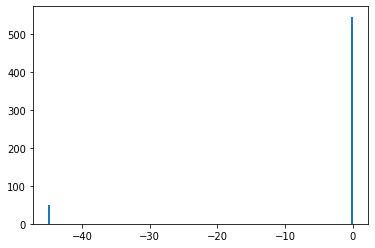

In [151]:
plot_histogram("agent_angles", 8192*25, "max")
#plot_histogram("agent_angles", 180, "dynamic")
#plot_histogram("algo_angles", 120, "max")
#plot_histogram("distribution", 120, "dynamic")
#overlap_histogram("agent_angles", [10,120], "dynamic")
#plot_boxplot([10,20,30,40,50,60,70,80,90,100,110,120])

In [139]:
plot_by_metric("commitment")
plot_by_metric("distance_traveled")
plot_by_metric("number_of_actions") #todo this metrics values are most likely wrong
plot_by_metric("rewards")
plot_by_metric("wins")
#plot_by_metric("avg_steps_per_episode")
#plot_by_metric("optimum_deviation")
plot_complete_distribution("complete_distribution")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'PPOvsA1CvsDQN/A2C/dynamic/'

In [142]:
def combine_distri_trajectory(trajectory, distribution, index):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[index][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[index])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[index]))]
    d_ys = []   
    for coordinate in distribution[index]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination_{}.png".format(index),facecolor='white', dpi=300, transparent=False)
    plt.show()

def preprocess_flex_max(_list):
    new_res = []
    for run in _list:
        empty_sub = []
        for sublist in run:
            for element in sublist:
                empty_sub.append([element])

        new_res.append(empty_sub)
    return str(new_res)

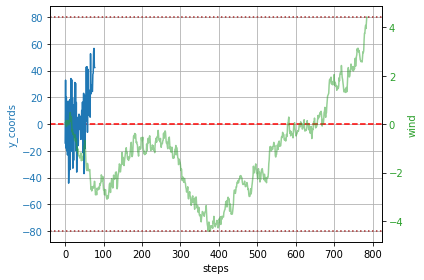

In [144]:
t="[[[48.22067, -12.568792], [58.318363, 34.80924], [91.2146, -0.39349133], [130.52219, 32.303165], [177.82793, 18.049686], [222.65208, 1.5986705], [267.86038, 26.501963], [302.23126, -10.710455], [306.8292, 35.063744], [333.29697, -10.36252], [333.297, 38.76506], [360.19476, 2.8168535], [402.14963, 32.511375], [440.4102, -3.3655689], [474.95346, 20.954252], [505.2236, -35.544586], [508.7479, -7.2695646], [517.80975, 22.104788], [532.2803, -46.35708], [532.28033, -17.575926], [548.9457, 6.8050404], [598.9359, -22.887875], [598.9359, -2.2810092], [638.5419, -0.1641061], [640.59033, 26.643805], [670.6732, -34.22339], [670.6732, -10.929275], [676.48816, 9.59154], [724.2667, -9.3392725], [738.2749, 10.323301], [788.18, -24.09573], [788.18, -5.3181453], [790.52045, 7.1892285], [839.97046, -25.378979], [839.97046, -14.67969], [843.4994, -1.9720777], [865.5543, 7.0357685], [905.8714, 4.7451267], [948.6251, 9.600769], [994.7779, 9.58554], [1044.5969, -12.01807], [1053.6235, 23.17072], [1102.8369, -2.9337053], [1102.8369, 26.636526], [1148.176, -17.58272], [1180.027, -4.3494577], [1186.4507, 17.453064], [1235.619, -19.363522], [1237.4252, 8.085234], [1276.0458, 15.325845], [1325.5531, -15.303957], [1343.8252, 6.4519916], [1390.7687, -11.399804], [1418.4696, -3.1067655], [1433.9016, 14.143789], [1480.7823, 8.991103], [1518.771, 20.79164], [1566.7153, -12.991765], [1569.0704, 13.557454], [1618.4889, -10.4255085], [1621.6929, 2.06543], [1626.955, 4.3031945], [1658.5033, -2.6788464], [1671.5682, 0.43934923], [1686.7076, -2.3091805], [1695.8687, -6.6483707], [1720.8988, -17.291521], [1733.712, -21.661434], [1753.0753, -29.056032], [1753.0753, -35.132076], [1756.5927, -44.05021], [1790.7008, -65.68328], [1804.7269, -72.22899], [1804.7269, -74.13178], [1808.0559, -73.57897], [1808.0559, -74.73365], [1810.79, -75.21157], [0.0, 0.0]], [[47.75797, -14.098237], [67.506714, 32.918285], [88.2679, -17.913607], [88.2679, 20.080011], [130.47441, -19.806211], [130.47441, 15.990333], [177.51836, -23.007994], [177.51836, 0.88781595], [202.00282, 17.237902], [234.58826, -44.129173], [260.131, -29.979534], [260.13104, -7.471725], [267.486, 18.43088], [307.16705, -33.952187], [307.16705, -0.65381527], [319.36276, 34.086277], [361.08197, -6.8844585], [368.4344, 33.22174], [385.94534, -20.402514], [385.94534, 19.810953], [411.69077, -32.94114], [411.69077, 8.534427], [453.99377, -27.024162], [456.68405, 14.427022], [504.4918, -6.1247296], [528.6377, 31.148527], [564.8818, -10.0819435], [564.8818, 30.606405], [597.0753, -19.910261], [597.0753, 16.217686], [636.32623, -35.874733], [636.32623, -11.3862915], [654.34375, 4.884879], [692.94275, 5.076631], [741.18195, -15.982093], [752.8852, -5.2115593], [760.0465, 7.4564376], [798.9817, -4.001236], [809.5695, 3.5974946], [844.66, -2.2859745], [859.6509, 5.8719215], [906.10034, -11.401309], [926.9155, 1.5927005], [951.6807, 10.227868], [1001.08887, -8.443677], [1016.99884, 16.475866], [1065.1617, -21.371183], [1075.5747, 1.0919564], [1088.0103, 23.079231], [1115.9941, -36.997986], [1115.9941, -8.2150955], [1115.9941, 21.525595], [1162.8094, -18.367878], [1162.8094, 20.290245], [1212.1595, 2.078086], [1212.1595, 42.770035], [1252.2408, 7.1388674], [1281.0507, 42.895382], [1297.3082, -6.1004844], [1300.4745, 41.074883], [1342.4364, 10.649887], [1390.2527, 24.75358], [1440.2007, 25.441818], [1486.9214, 6.321671], [1533.9097, 21.997135], [1580.8624, 5.219904], [1604.6111, 52.66631], [1641.643, 22.566355], [1690.5237, 24.394028], [1738.8394, 29.117147], [1784.4205, 24.973991], [1830.4292, 24.418476], [1880.321, 37.351448], [1927.4517, 38.147915], [1976.9996, 54.048317], [2021.641, 56.640285], [2046.4747, 42.572266], [2086.7637, 42.32044], [0.0, 0.0]], [[49.87172, -4.0273952], [65.13309, 40.357307], [76.41543, -3.9132936], [92.64031, 54.210514], [126.25917, 27.570087], [161.35658, 4.54917], [203.05943, -11.529689], [207.31711, 47.34314], [243.84235, 19.124352], [283.72327, -4.861757], [303.8657, 42.249435], [344.14645, 15.601704], [377.09604, -9.015999], [377.09604, 55.936893], [420.94684, 41.493557], [431.14505, 2.7500138], [472.80447, 40.59818], [505.29758, 12.45961], [548.67725, 0.93366057], [571.2697, 60.206673], [613.4869, 38.595436], [654.0833, 11.370755], [704.0736, 13.727047], [753.5713, 9.85483], [802.94995, 16.55604], [847.0368, -10.969665], [869.1534, 30.718494], [914.54333, 12.240914], [962.9874, 32.378845], [1001.5239, 3.9735124], [1027.3977, 50.782288], [1073.6758, 39.195805], [1101.6978, 4.078668], [1127.0709, 47.912495], [1162.8542, 10.68006], [1207.5394, 31.254269], [1254.7964, 9.62675], [1300.9847, 25.45224], [1349.1886, 8.1836], [1392.7084, 32.59807], [1441.5798, 15.603863], [1489.2731, 18.197262], [1529.321, 35.0459], [1576.468, 8.58953], [1614.0117, 33.567535], [1662.5138, 35.515175], [1711.276, 13.95751], [1761.228, -0.88807464], [1761.7998, 23.35588], [1811.449, -13.135826], [1838.0204, 2.280959], [1843.2203, 28.361635], [1889.8796, 26.23152], [1934.2137, -25.94677], [1935.625, -6.3259044], [1935.625, 7.448918], [1972.1802, 4.05864], [1998.6506, 12.606399], [2045.7789, 0.66629297], [2045.7789, 23.41461], [2095.607, -4.989072], [2101.5886, 20.811491], [2151.357, 4.655164], [2167.4382, 31.333954], [2215.361, -4.944079], [2234.6123, 19.767921], [2284.5732, 2.2112634], [2284.5732, 37.189903], [2333.8704, 16.889124], [2382.4773, 13.610456], [2431.739, -8.376736], [2436.1738, 27.251314], [2485.2363, 5.537985], [2487.5396, 46.408215], [2536.373, 45.742115], [2579.8057, 7.870783], [2591.2798, 43.369072], [2638.0886, 17.512104], [2687.9436, 0.3012081], [2694.7336, 31.458998], [2744.4004, 17.729362], [2792.4878, 16.364944], [2831.322, 25.446117], [2876.386, 30.723383], [2924.6506, 28.878412], [2971.9607, 30.337442], [3019.575, 30.80143], [3068.313, 23.079638], [3115.9832, 19.340115], [3165.0764, -6.0300674], [3170.4065, 28.077566], [3219.3867, 19.440586], [3258.7832, 24.495607], [3306.5315, 5.9377556], [3306.5315, 12.731834], [3320.273, 15.211977], [3359.4207, 4.7308297], [3361.5754, 19.010977], [3398.6318, 16.20849], [3447.6204, -11.771199], [3447.6204, 8.495361], [3467.502, 26.160065], [3505.715, 27.251848], [3554.3975, 6.803238], [3558.7083, 20.85384], [3602.148, 17.914062], [3646.3208, 15.619589], [3658.6296, 38.696434], [3708.5378, 22.31849], [3752.819, 29.203766], [3799.53, 25.771019], [3849.5173, -2.0302677], [3851.507, 17.790535], [3898.5205, 6.3380637], [3904.014, 33.212353], [3945.3, 39.48037], [3993.5618, 26.539194], [4032.5369, 26.66939], [4066.3206, 32.639626], [4115.6133, -7.562993], [4115.6133, 18.210457], [4143.8174, 38.08629], [4184.5464, 51.297184], [4234.071, 48.94974], [4281.239, 15.637306], [4303.4136, 43.318035], [4349.9985, 35.932766], [4399.963, 11.898712], [4399.963, 41.34239], [4446.93, 42.710587], [4496.8022, 26.935196], [4541.3086, 35.512848], [4589.9087, 32.99104], [4638.3193, 25.541447], [4679.027, 44.646942], [4728.9316, 41.31355], [4775.4165, 51.65347], [0.0, 0.0]], [[47.185917, -16.781193], [47.185917, 39.23234], [50.732216, -5.440659], [50.73222, 54.634064], [79.77803, 27.9686], [124.47689, 19.868795], [171.29369, 11.52845], [176.29028, -25.75874], [176.29028, 37.14821], [225.77328, 38.899742], [251.02818, -0.09365358], [267.5885, 48.889088], [305.81717, 16.08287], [353.92343, -0.031202024], [373.34872, 47.341114], [420.29245, 36.922215], [457.51965, 9.542695], [496.94666, -16.004114], [496.94666, 42.827244], [520.6916, 10.700709], [570.62524, 30.310713], [595.98883, 19.544243], [643.2075, 38.02331], [682.18634, 46.40123], [709.24664, 45.528015], [734.9329, 42.310295], [781.5069, 57.79715], [797.4283, 40.53415], [826.5768, 27.068016], [861.37115, 20.355127], [908.0311, 32.227867], [954.2078, 44.67824], [981.3722, 36.54555], [1019.23914, 39.468433], [1048.6251, 37.518078], [1076.1644, 40.20502], [1118.2214, 54.278717], [1150.4181, 56.237312], [1182.2095, 56.932842], [1211.4573, 50.96739], [1230.0414, 38.803825], [1261.4512, 33.969524], [1306.3435, 46.33503], [1352.6824, 59.05547], [1390.2144, 61.980583], [0.0, 0.0]], [[49.782097, 5.2802258], [93.14901, -15.060547], [93.14901, 38.01761], [122.48979, -2.510056], [122.48979, 49.81571], [132.51581, 3.155665], [181.51102, -6.2029495], [181.51102, 41.518387], [208.74939, 4.2867436], [252.68648, -15.492301], [252.68648, 32.36304], [275.23022, -19.7269], [275.23022, 24.512434], [316.7786, 0.68266827], [333.95343, 54.096767], [357.17075, 11.710618], [388.8195, -25.632416], [388.8195, 28.923344], [435.63843, 26.890848], [468.36578, 5.2238364], [517.1922, 25.653662], [544.8671, -5.339194], [545.6624, 57.38691], [579.6709, 36.87406], [614.9508, 14.862962], [632.24036, -25.98621], [632.24036, 30.170073], [670.9746, 6.4727154], [710.8243, 45.617275], [730.0107, 10.528727], [778.0895, 34.293953], [819.98785, 3.923453], [862.88153, 25.999075], [904.31635, -10.426015], [910.1876, 29.516176], [937.93604, -20.74366], [940.48083, 22.005278], [982.4087, -16.221128], [982.4087, 25.720755], [1023.3611, -13.062763], [1029.2515, 16.16394], [1079.2505, -6.387484], [1079.2505, 20.335405], [1126.5105, -23.417362], [1140.9247, -4.3971786], [1152.866, 11.694457], [1201.2991, -10.410227], [1204.4204, 2.4741518], [1206.5051, 20.96794], [1256.2932, -2.5361], [1284.9767, 15.237547], [1330.2521, -25.60374], [1344.5441, 8.367575], [1388.186, 24.380682], [1437.2589, 26.031048], [1484.3531, 3.0843353], [1500.7875, 46.534412], [1536.0367, 2.1640935], [1536.0367, 45.284073], [1585.1138, 28.136374], [1634.7971, 16.176239], [1675.9938, 29.20528], [1725.9869, 7.3726673], [1754.1383, 22.108595], [1803.7875, -0.83348876], [1821.3773, 13.901198], [1859.0907, 11.45582], [1907.4084, -12.831097], [1927.0139, -2.3822324], [1941.4724, 6.683195], [1958.012, 19.44624], [2008.0107, -18.171057], [2028.9382, -12.39125], [2036.5414, -0.0021125043], [2048.7283, 17.715199], [2097.7341, -2.528532], [2123.2207, 8.205753], [2135.415, 29.616884], [2183.742, -10.198832], [2207.4465, 2.6291893], [2225.846, 19.356766], [2273.699, -24.954182], [2281.7612, -11.848645], [2290.9102, 5.3746862], [2309.2932, 16.403896], [2355.8313, -39.422283], [2356.587, -30.701227], [2358.7407, -28.661316], [2384.7314, -42.7445], [2404.5461, -59.391544], [0.0, 0.0]], [[43.178642, 24.364325], [73.59145, -18.838385], [86.22638, 28.82328], [111.71132, -4.700059], [111.71132, 58.27436], [149.00151, 44.985397], [190.66672, 37.695656], [237.23671, 43.857475], [273.8326, 34.129997], [315.8037, 29.866133], [357.4747, 27.936232], [389.49255, 16.86952], [436.4787, 27.172493], [467.14847, 11.564374], [501.29013, -1.7523426], [509.4464, 65.58374], [548.034, 47.065907], [582.9534, 22.87646], [611.0508, 0.64801925], [644.54816, 64.74746], [683.8078, 64.39927], [712.1582, 55.645943], [758.97943, 72.35029], [794.82965, 67.24553], [811.1528, 55.502895], [843.9301, 51.573826], [882.08276, 57.811775], [924.8078, 69.8739], [948.53, 67.4154], [971.04034, 65.66857], [997.1543, 67.97967], [1021.4418, 59.24543], [1039.8004, 42.46877], [1066.8373, 32.713287], [1099.0546, 29.168083], [1139.3313, 40.864937], [1177.9432, 52.568867], [1209.7367, 50.899128], [1243.1516, 47.381615], [1279.6055, 44.329796], [1321.0911, 49.22342], [1359.27, 49.47328], [1386.4515, 36.45076], [1433.9917, 57.128666], [1467.9606, 56.433144], [1504.2192, 58.74872], [1543.8691, 65.02902], [1586.3289, 75.4247], [0.0, 0.0]], [[49.93516, 2.8359222], [91.90374, -27.761753], [104.14882, 17.903257], [147.29257, -2.585851], [155.20598, 59.371307], [177.35039, 36.589836], [184.34247, 11.87495], [211.20413, -5.6432605], [241.15536, 54.480186], [278.58624, 44.915657], [290.24854, 23.04767], [326.16415, 12.637904], [361.58878, 2.2196574], [387.42694, 70.763916], [423.00427, 57.390835], [455.44, 44.535896], [481.44437, 26.48229], [518.9417, 16.958815], [545.8206, 4.684499], [592.8159, 58.680836], [600.7808, 49.74849], [0.0, 0.0]], [[43.13588, -23.486906], [55.41344, 31.291914], [68.75888, -13.445078], [68.75888, 45.351906], [91.06476, 9.529944], [131.13431, -11.221307], [152.35443, 44.474815], [184.18912, 17.895025], [218.00648, -2.5402968], [229.60312, 63.769535], [278.3244, 72.34447], [315.7815, 55.894466], [360.9651, 50.008076], [395.60846, 30.247257], [425.0075, 7.7959695], [469.95682, 9.7959385], [519.95593, 33.373276], [562.55927, 30.8394], [598.9211, 19.114605], [638.6296, 8.871001], [687.67865, 43.218456], [713.8421, 33.119442], [722.45325, 19.162218], [756.83124, 21.322071], [795.612, 30.640404], [821.27905, 34.48523], [855.2301, 40.438778], [892.4899, 52.770016], [918.4659, 51.02386], [946.595, 54.31742], [966.34534, 48.876373], [997.9208, 47.128902], [1028.6171, 52.14147], [1047.3489, 51.74288], [1081.0026, 65.7084], [0.0, 0.0]], [[47.07189, 22.002256], [75.68681, -13.208276], [86.2644, 41.01011], [113.96041, 3.750589], [160.56169, -7.2497683], [160.5617, 45.70053], [198.61008, 21.969831], [236.954, 0.5849575], [255.13791, 63.407272], [283.8667, 40.19628], [315.41055, 15.955766], [343.87375, -1.1814582], [346.23944, 79.24258], [0.0, 0.0]], [[48.943264, -10.573404], [48.943268, 36.21202], [79.38909, -6.2781897], [84.27994, 36.559555], [120.04873, -3.8619158], [120.04873, 43.810802], [143.73894, 3.960345], [191.94052, -3.857379], [200.32085, 52.22815], [234.04402, 25.292713], [267.0825, -1.1352178], [300.99966, 43.39122], [346.9441, 33.564793], [380.11618, 6.9280267], [424.39166, -2.7734177], [457.62433, 51.03532], [488.95782, 27.049858], [516.9574, 5.7793365], [566.03516, 37.996166], [611.5412, 47.673878], [628.24725, 32.63693], [662.28564, 24.007782], [700.90826, 27.61892], [744.6993, 39.656227], [781.00653, 36.090534], [809.75305, 24.641193], [849.7886, 25.774946], [890.88605, 32.907257], [930.7329, 38.892315], [966.33344, 39.06488], [996.87726, 35.11637], [1022.5845, 34.076984], [1055.4493, 39.044033], [1076.5367, 37.518166], [1120.0223, 47.13542], [1148.158, 41.02212], [1182.3326, 35.669117], [1214.9603, 30.379984], [1251.1986, 28.937365], [1301.1979, 58.872368], [1336.8485, 54.1358], [1378.5583, 57.328938], [1402.3422, 42.33293], [1443.4114, 50.158134], [1474.6425, 52.10407], [1510.1271, 60.53118], [1531.0032, 58.325027], [1573.964, 79.30277], [0.0, 0.0]]]"
d=[[[0.04656531694122208, -0.06018197799611861, -0.22121853716259926, 0.06692254513926574, -0.03912994919495126, 0.17298432837348648, 0.1680344745393958, 0.18604548490890407, 0.2456064717329285, 0.08553552794792868], [0.2871891829473274, 0.05659977268410149, 0.00015583305378697593, 0.05987111834153245, -0.27942553866302144, -0.31001105937693557, -0.5118796077781763, -0.38185967440570057, -0.3687359514378523, -0.14362453230818042], [-0.22391038954159234, -0.026769358436113472, 0.09990190311850115, -0.0457879438867486, 0.27702005633942, 0.3080910939801254, 0.23479329437549923, 0.4155651860412304, 0.7659524223920378, 0.6466009202086158], [0.649553342905927, 0.4240087270284309, 0.2855496071472733, 0.2413216514761441, 0.11572056951305601, 0.31141377762170985, 0.1412151939147837, 0.051852524735440234, -0.14560330798147825, -0.28005777588347597], [-0.35263200566245184, 0.064122550503254, 0.16465742820796425, 0.2430636366495249, 0.2688932982259548, 0.3585508412060649, 0.3166937546747801, 0.27146969184975683, 0.2585794996013767, 0.3446849889130008], [0.4046079881302464, 0.5359459773324473, 0.7393458643543445, 0.7404938818726904, 0.5666965819208354, 0.7886356675181526, 0.7529862878007529, 0.5706319429698422, 0.28733072979554214, 0.31621236013743864], [0.3292623207003012, 0.40566626686859475, 0.619205394081811, 0.8232354717152455, 0.5206491032055991, 0.4447938716019927, 0.28306311597228795, 0.16293934618276712, 0.13838285025366373, -0.18294690446359851], [-0.10907811352357583, -0.19562111916446093, 0.10901776741845401, 0.08837839206095827, 0.14026437086772015, 0.12337007296400943, -0.008315791617885357, -0.19910387081535694, -0.4656675423949662, -0.3825349814728388], [-0.42704828707574544, -0.4196255560474038, -0.5712820984098279, -0.5463522600640963, -0.6406787893680606, -0.48547890374030467, -0.4215591961558741, -0.1694986710291837, -0.23932450221350593, -0.09309484223887912], [0.13258025568657256, 0.08238078919373887, -0.30297090601768906, -0.36031281337643445, -0.26600659275528404, -0.36240271321109174, -0.5440569012712526, -0.48637389513511736, -0.4865167001987279, -0.4125872523482045], [-0.344193408768513, -0.433598331031078, -0.07888736154136755, -0.2400966378972907, -0.3336299322522278, -0.09033492832764373, -0.009434706804558712, -0.06643888108433099, 0.2779730069393141, 0.4462231990023964], [0.5629230857696204, 0.6107413826646404, 0.6214426749780372, 0.6232530394849215, 0.6489736757029522, 0.6236634143893949, 0.6707020444390412, 0.5952285641338275, 0.7723613248769342, 0.4711595641962912], [0.3869082668706782, 0.2851041087365269, 0.3882503112347423, 0.2619154971037472, 0.19132175346718547, 0.34091831507604947, 0.11546058530065678, 0.3253527618044333, 0.19059190584634614, 0.009634829075981816], [-0.07790596231151377, -0.48638668446037436, -0.21646609106523385, -0.2204621748370178, -0.3387636009736619, -0.2636845195027278, -0.22779773084816204, -0.3839405463766102, -0.6239847903713082, -0.8485783487164922], [-0.9916558706098838, -1.1126706959685335, -1.2472834585464738, -1.3664375969761906, -1.0296053443963418, -1.0763379454101756, -1.2548040099751003, -1.2728192728762173, -1.2379457819436668, -1.2397882276676102], [-1.5378350753049543, -1.3250727235202504, -1.4426946852390516, -1.335009448802665, -1.4904503577124244, -1.6906613205561658, -1.8214503956273171, -1.7923917442380781, -2.053185301857899, -2.2141331812777167], [-2.5306377383010545, -2.4939762040551656, -2.392431463595349, -2.1780793917270405, -2.141760897196674, -2.021280759845946, -2.0246179084210794, -1.8814816838867434, -2.015301155470118, -1.9210492467712927], [-1.9370457763139337, -1.9697515151376384, -1.7282926210016538, -1.7860812775672195, -2.0366242013234506, -2.1329285087889702, -2.261871817222364, -2.2165989355933515, -1.824259594266007, -1.9041585355391564], [-2.027830852640434, -1.7855690355630631, -1.4037373171353977, -1.4131882934714006, -1.5830265157917105, -1.7946233778906764, -2.366043591234427, -2.726337239226591, -2.781757133113726, -2.719499543967068], [-2.5423002183294505, -2.349173995704183, -2.0207992822982237, -2.1026960792646694, -2.0046810904221415, -2.0763325678147004, -2.1836020688095217, -2.0270658990196617, -1.9441177357381656, -1.9680780502078106], [-1.748994098133707, -1.8803008087554958, -1.9130052732567422, -2.1710155986590545, -2.0976369009706253, -2.2518168873821613, -2.4044767452129223, -2.7345350913411206, -2.6786903387727206, -2.87946841706678], [-2.992078907244655, -2.896999596124078, -3.1182092954879086, -3.078644671167867, -2.9585165643016156, -3.1057709393118125, -3.089110580408353, -3.2284655444685733, -3.1131323603652405, -3.1018940245888373], [-3.0636426672605808, -3.06246435123509, -2.9579862686497993, -2.8866253081957263, -2.9571966192311665, -2.8265857352593726, -3.0221919229471945, -2.6293994685764743, -2.9534382147590033, -3.0336037173706223], [-2.8595557085407477, -2.8018514721764145, -2.7242335791259933, -2.7535164814227984, -2.82628741627738, -2.8933686725102166, -2.875972783566974, -2.8630642398702455, -2.912424230299223, -2.891133162443667], [-2.732167277871864, -2.6441729774143603, -2.46827290070789, -2.3265787313581434, -2.228711366582657, -2.310838071694407, -2.251478291508272, -2.0291282978532603, -2.0866253336493137, -2.072136576208119], [-2.1356074457544456, -1.9315519616730388, -1.9999988133090838, -1.8503517620480312, -1.8363180286008978, -2.075597258722573, -2.1693798937010054, -2.420333670264016, -2.2640682237188234, -2.2462968100862377], [-2.4048041216749763, -2.4977591680123306, -2.3400600980151087, -2.368084666113768, -2.4794045800068596, -2.399994207122308, -2.6655842616618197, -3.1656947139624076, -3.2198200771852963, -3.1646792733174394], [-2.773303326431658, -2.897874511083246, -2.900695087983885, -3.083017391286703, -2.9062880412241494, -3.038991994888029, -2.8611566423391404, -2.8201864798121505, -2.7760693078226852, -3.0823135836319606], [-3.314646533813709, -3.407900334116265, -3.586567901716423, -3.548192444100678, -3.68036475526807, -3.4214016982645212, -3.3294735199712377, -3.2104925274744693, -3.2179818060829564, -2.951825535416348], [-2.9262313495578725, -2.876615382926807, -2.8163509550168526, -2.7120292784558533, -2.698655888818395, -2.8445938799316997, -2.6798121192465585, -2.747187899395795, -3.0091307660561606, -3.024439969252076], [-3.106560004298792, -2.9993992487720273, -2.846318002674891, -3.169565921841776, -3.341973736044238, -3.1389492464545, -3.22567420277624, -3.106187942964092, -3.240734160977786, -3.1642667738713093], [-3.0172147731183343, -2.9691854273903044, -3.041783221229751, -3.0947575282017836, -3.236383922307377, -3.1209246180794947, -3.1767483465452115, -3.148420473051889, -3.1594015860592966, -3.2575952210755874], [-3.480279489861913, -3.5397948102451005, -3.778292344367235, -3.641503465628648, -3.7010278281538316, -3.7908886642006405, -4.056092679217633, -3.7960310767909395, -3.8329947961889643, -3.8209121551671155], [-3.795813645978544, -3.714616008237786, -3.9093291929477094, -4.196321622637892, -4.31008068018628, -4.171598801218488, -4.087533778725672, -3.941974234288797, -3.8779658917656525, -3.9587500563156874], [-4.019851090162648, -4.107697655414963, -3.958176877976126, -3.8290821043773207, -3.812924638914288, -3.9513922466910936, -3.970053571476773, -3.717471060796593, -3.823165208494258, -4.110896431587558], [-3.6468224174332486, -3.486954465905728, -3.692643422315249, -3.7674793529370527, -3.779840952601456, -3.865530782302689, -3.83495357516066, -3.7490778478292985, -3.6672320375594314, -3.6771655855980123], [-3.6249309827030984, -3.3950262077067914, -3.687783652785754, -3.757447973506554, -3.660951461229946, -3.5750015497478804, -3.660143552091006, -3.669224901306481, -3.5032997747799373, -3.3312752435096114], [-3.5313602527080272, -3.33243430526389, -3.317209348380984, -3.4695949074480947, -3.315658645015383, -3.3222074480692405, -3.2277836445370665, -2.998003209175933, -2.816418952502943, -2.532497073339683], [-2.3688214983801874, -2.323085622616041, -2.0509493386641897, -2.216697792337203, -2.1731955232606808, -2.168164597239791, -1.9186116373867208, -2.1226082420793695, -1.7686226457244576, -1.9588126716225283], [-1.933520477913466, -1.7116110880150828, -1.9851516602895436, -1.8223009116992017, -2.015254535860422, -1.9195559695308746, -2.0197368330557506, -2.044668497291221, -1.9624396710318168, -1.8343348264246326], [-1.743939276675967, -1.777892693830815, -1.5679424022862403, -1.778835354937413, -1.784328092116141, -1.8834854754943737, -1.9290365387807091, -1.6917769732001593, -1.6062573791139847, -1.5900262995542347], [-1.5323318814055762, -1.4950491665231156, -1.3136518401376756, -1.4330959373681542, -1.3803143858819724, -1.4503289461514222, -1.3788876331537556, -1.3625081511430752, -1.4177555273990863, -1.2257525166303251], [-1.552196150137502, -1.7864681921703973, -1.9370743270427, -1.9382751446276847, -1.6332091854359387, -1.6334987164638155, -1.6008836878205008, -1.7363858730589812, -1.746835969097836, -1.7059705010335546], [-1.8051825726369888, -2.044809806547434, -2.088481051252636, -2.093383978965056, -2.3092176603508223, -1.9940607521613702, -2.0436759724120295, -1.9900996028372684, -1.9444042166749727, -2.116453755254578], [-2.1756018699256447, -2.17076560629045, -2.3605889940231686, -2.2283163614912036, -2.0326697803588716, -2.4110160055499783, -2.393670842290262, -2.281412382450637, -2.423844632174373, -2.6612312752534426], [-2.292139855269843, -2.302376290553631, -2.4711731518435838, -2.6217148344124004, -2.4142853574164875, -2.4175486211481503, -2.44411364241296, -2.696946524646723, -2.8648032589878505, -2.783977863137076], [-2.8427132534909565, -2.9337488221307213, -2.95108954284486, -2.7423532867314244, -2.659288824737177, -2.7460847759275975, -2.7611550894020254, -2.570128225358429, -2.638785575668053, -2.9377891395194813], [-2.854721938862453, -2.9608700710917266, -3.170139025733673, -2.9680805157598042, -2.8366260356468436, -2.4435823943370534, -2.6052582243553783, -2.67858868129787, -2.6359970439193265, -2.5816344575352423], [-2.2714542284409265, -2.109129197129418, -2.0213839945077217, -2.1330605374896328, -2.2390368244550736, -2.3320350180747784, -2.4937747224827236, -2.4340936531155752, -2.227025521589874, -2.257619700413234], [-2.1423115283593486, -2.240237827180004, -2.466617973400524, -2.66560190328617, -2.620220649351145, -2.6112706814062405, -2.4067956930825365, -2.3655002919338237, -2.5442941125079215, -2.4525879324398328], [-2.471324902250279, -2.505074157099395, -2.5150239062518787, -2.2423656467223596, -2.103869343394783, -2.2333596788460435, -2.4628763740387263, -2.381040243305373, -2.293661309140711, -2.4189600771402757], [-2.2788064863923365, -2.331439292297885, -2.3650320087184693, -2.1651624611584706, -2.1676793582103464, -2.5162878758350886, -2.3757940038670116, -2.64441906539233, -2.8745706883728137, -3.066539975497802], [-3.123416904695055, -3.1125072310416058, -3.2636459787884213, -3.5006858914750256, -3.6681834561121023, -3.614941827634226, -3.805278026598677, -3.776640935207282, -3.7405969187120216, -3.459554007461182], [-3.701575315551702, -3.7831082740650466, -3.6004457633120706, -3.2618053978194332, -3.3797565017312143, -3.1804101724682967, -3.0271036142855747, -3.0393113264594747, -3.1014209496983596, -3.2572640343300194], [-3.4925143870063824, -3.3602786101686837, -3.333563653274575, -3.170202491647168, -3.1358943035268663, -2.879644276034564, -2.854988479692866, -2.6842584367474855, -2.7813936038378935, -2.615634288470289], [-2.3756759453438723, -2.2497131228429166, -2.133530516046943, -1.9760526826307314, -2.3555870123987326, -2.2732529123726257, -2.320672258728003, -2.239022774098488, -2.4101346482132673, -2.203093365541201], [-2.039362098313718, -1.8979660758811576, -1.8563884702407591, -2.0346416051292637, -2.0532777010936476, -2.1466805461725182, -2.2107262640897645, -2.2927574720251243, -2.2306249963758984, -1.946366432792609], [-1.807470509820196, -1.8915061689332888, -1.882845654789694, -1.8599789799782045, -1.9645607045556963, -2.1044670508208654, -1.9530460994820165, -1.9131198659338586, -1.9138476028700204, -2.302901975321779], [-2.056247788206898, -2.2196390055881916, -2.217970662034079, -2.324007327509173, -2.304170334957516, -2.376810684162144, -2.4853639411359847, -2.3839470441335333, -2.456760305413002, -2.570364694366938], [-2.762325427201875, -2.878992969540549, -3.1249700674747545, -3.1926142955427577, -3.1632693006338326, -3.3710137891113665, -3.3834103128843402, -3.2719145051577607, -3.209028951291151, -3.2293588545108194], [-3.406933276262674, -3.6302024874104966, -3.701161116301311, -3.6676108233949556, -3.70409807797603, -3.774192652708653, -3.875538394842343, -3.887277562582932, -3.7927827969229955, -3.9665015527025096], [-4.309144786868336, -4.27027869815957, -4.399141365325779, -4.41057749474536, -4.703135524871758, -4.819378834844069, -5.012442410526566, -5.263076159105975, -5.189437480630518, -5.107964826048124], [-4.925999116993591, -4.774368311284089, -4.7417654756966385, -4.61463681231711, -4.648777856502471, -4.557309031082964, -4.4672108786888085, -4.396383156980159, -4.377756833381998, -4.268321718403903], [-4.498288632814776, -4.6672105336182295, -4.394398181065588, -4.472551390536555, -4.398338252160884, -4.281025924518117, -4.371633938622984, -4.38757468146486, -4.746255586295463, -4.92742201497836], [-4.891664341752169, -5.164665319417966, -5.261551876418762, -5.065137468310163, -5.056738037821375, -5.027613506332579, -4.956919519879344, -4.848069704082249, -5.109921891835932, -5.019117064186984], [-5.1088994671036145, -4.90240258328905, -4.970518879872592, -5.3175946738345, -5.386587628882496, -5.601204041368742, -5.687451730617971, -5.465763453840985, -5.357951819362527, -5.694418097979997], [-5.594740031526216, -5.712847980258908, -5.709351047899724, -5.65840295994728, -5.360188599171325, -5.170708169097952, -5.088174106091379, -5.139146588804753, -5.183305722393766, -5.310142318354288], [-5.50333481017322, -5.599019255725931, -5.451186306408222, -5.237532409213302, -5.144217943400618, -5.1296093943824745, -5.072702391285497, -5.146897385089584, -5.157726713533467, -5.25800943315985], [-5.052808595818323, -5.286733381749994, -5.283489639250412, -5.465529376313528, -5.533779467596033, -5.489389497638104, -5.356126727068215, -5.341037475734264, -5.391659689077715, -5.292483492805422], [-5.361329683216625, -5.347250239660443, -5.26648938346717, -5.326999746084621, -5.519453584548533, -5.598193516711197, -5.762755143050931, -5.960432492287373, -5.992404844022978, -5.9407349044396165], [-5.80939399266378, -5.814212242702374, -5.871078491273547, -5.939551840235098, -6.007606547162181, -5.847860340602614, -5.892956128088282, -5.85590221336596, -5.788457330919194, -5.96724002963157], [-5.8145014285204075, -6.051836202311133, -6.0349336371185345, -6.094415807712852, -6.226386605851945, -5.865649103084073, -5.626581702080602, -5.461561683601294, -5.417974619310689, -5.599246672731807], [-5.5313840278454265, -5.4218314891230746, -5.50589340883793, -5.203545684675524, -5.2260651552389845, -5.274615610602328, -5.267431116157357, -5.66013151325758, -5.756469104125945, -5.690720562316045], [-5.7816235657470685, -5.418085675624759, -5.16402857675222, -5.229635523364683, -4.927244158664677, -5.017987253282082, -4.967248495635745, -5.110180396058778, -5.1445121327839916, -5.142254174748668], [-5.016939064657345, -4.7840496159131956, -4.945373956681976, -4.896651533049859, -4.883031690669588, -4.714937757387225, -4.803796591169007, -4.953411578926496, -5.082676782795217, -5.2553765220326], [-5.3020001511557515, -5.343150020484346, -5.193894863939736, -5.192814872558776, -4.958948917665972, -5.021151578586892, -5.132852204616842, -5.21423514597083, -4.957381113850529, -4.838248473219947], [-4.758374466869075, -4.8455395176293, -4.730407172820805, -4.759543807467142, -5.044009569286964, -5.055379571526589, -5.221103194546937, -5.180755577221676, -5.257871886650641, -5.550120482438545], [-5.83149411073448, -6.004128486837132, -5.888216976833421, -6.152855093481326, -6.1670650763798225]], [[0.051744713830930725, 0.027252400903059585, 0.14114370332164472, -0.10270138118001484, 0.12512644263881495, 0.15582319992115912, 0.08333605469480757, -0.0341024072265501, 0.1251281233861302, 0.13361333501440692], [-0.0032275798876504336, 0.011386952786761698, 0.41821741450461863, 0.48026781593098694, 0.319492500802361, 0.12066228429017409, 0.3011570482130078, -0.017968087385698717, -0.32306436086252355, -0.2249975138725065], [-0.4257300992102142, -0.3750499436591159, -0.40344629973875745, -0.48490189303252473, -0.6453422826099877, -0.6450760014521473, -0.443869692939731, -0.7240577424365645, -0.5983462108007442, -0.6001006901925315], [-1.0879033601975594, -0.9657428083400944, -1.0415408285523515, -1.1987682362750005, -1.034379393773766, -1.2966517697846283, -1.318658511945942, -1.320314507265, -1.4014451391883491, -1.3409775936566624], [-1.2923789182185237, -1.187987201654538, -1.5124933664021378, -1.4472335755736234, -1.3936641717911082, -1.3435096610406247, -1.4897698351320838, -1.2754038632501838, -1.2268134277755958, -0.9100480078506887], [-0.926641288670379, -0.669196769831087, -0.9181409987202549, -1.145113650908991, -1.5757957994057086, -1.8166620854578075, -1.9069667175945624, -1.9221075666563365, -1.6228381416694388, -1.699992568170502], [-1.849282016247864, -1.905282162898878, -1.9344522039618965, -1.892517565096673, -1.8749380024323965, -2.178999453086845, -2.3709578842739383, -2.6884154011478323, -2.605807109629431, -2.7605441256014327], [-2.71231260063853, -2.598453383002539, -2.62843944868258, -2.5760501815790393, -2.6409568149723204, -2.563615473268955, -2.36453054704962, -2.381039728315617, -2.7159307782445308, -2.9228619126019977], [-2.8412845121211343, -2.798706947416297, -2.919961404001, -2.647318069830351, -2.699519793409328, -2.6999424239207137, -2.713350394835379, -2.6083852299459016, -2.6360073861555295, -2.6802950997739883], [-2.4670802867821267, -2.5303287717337013, -2.4269961402711355, -2.4212469642819805, -2.0969704020455042, -2.1399388929034426, -2.345899718012608, -2.3267296303836953, -2.1667110341308, -2.521708021295852], [-2.7307235415906193, -2.6946401410372873, -2.912770145475769, -2.923730916782332, -2.8008727866181387, -2.7088038419711946, -2.911900993527324, -2.9750897290346123, -3.071643048320022, -3.103518255113254], [-3.0027908877968095, -2.9563394995040246, -3.0607851821471814, -2.8948704806482297, -2.72547311791906, -2.493387015368012, -2.439442086285379, -2.601327368330042, -2.824984413298215, -2.4927908964287497], [-2.3964094614463978, -2.2589993397717025, -2.591118753499394, -2.447503958758176, -2.641714074999915, -2.4882682674414616, -2.1087666108477197, -2.1943188466262726, -2.150005458423501, -2.276375527941459], [-2.171293483067143, -1.9966205140915654, -1.9955293152798848, -1.974997902924411, -2.2018830812065784, -2.6731283949244573, -2.5997191436239, -2.2510361289007164, -2.0848560375886143, -2.0133929674538398], [-1.8127602836938996, -1.6433318666367815, -1.6818421460576374, -1.9709089803447748, -1.9712809854072126, -1.7902069779175593, -1.6740550073510774, -1.6495876021153135, -1.1728011884809804, -1.3348542955264104], [-1.6527877747636857, -1.3790942726284285, -1.607715089820748, -1.7131371510618154, -1.5729650231987107, -1.3996750982353166, -1.2800073289153222, -1.137830656089916, -1.031190409513033, -0.9753507679880901], [-1.1827603213186362, -1.1636660194524475, -1.4030821808618363, -1.4490933583609633, -1.3529503573380506, -1.4996797871137575, -1.374506301473905, -1.4116171577062224, -1.3825145164697987, -1.19172748408563], [-1.0346566006621432, -0.826727161749401, -0.7522509084436646, -1.1449803755201784, -1.343147076705919, -1.3035234593821234, -1.1815627583936799, -0.7657901081939575, -0.49502046574491093, -0.5026117408363472], [-0.4671980976218577, -0.38613858736521856, -0.5834775172353973, -0.4155407046963737, -0.6147087775069395, -0.7677229810385469, -0.7245876280398154, -0.8275243709286033, -0.8542990219170227, -1.1496665962617933], [-1.1952719625989285, -1.3211964724805514, -1.0929024871484223, -0.9348661587111674, -0.9608307140021866, -1.0279146869547562, -1.037814527919027, -0.9913411864266233, -0.5531444299504277, -0.6712503069116054], [-0.5864232492249423, -0.675322689614802, -0.5409129504725267, -0.9625184757021511, -1.1015414234876673, -1.2232078903816488, -1.1214540336014451, -1.259154613868253, -1.2262263070840305, -1.1930814659316002], [-1.2203321858130673, -1.2008697675325486, -0.8223376734557721, -1.0938877754358631, -0.8990033624907569, -0.6826337700636473, -0.5889596227021794, -0.775609998918443, -0.704617193545343, -0.536182495438606], [-0.48138634476459896, -0.6092625623717548, -0.9730545037274707, -1.0882880223991538, -0.993513509125888, -1.0042403053930808, -1.0478599200388996, -0.8596312192544562, -0.9550264244452018, -0.8919590392107835], [-1.0703702586549584, -1.0762803534335719, -1.0282802533894995, -1.1786928577403972, -0.8815933814788008, -0.7313715482763853, -0.6556150288072473, -0.5766925879914185, -0.7447280935381989, -0.5327622325555533], [-0.5485342725108553, -0.4520234377929213, -0.25787742590925283, -0.45480996913835836, -0.6651512749885776, -0.6624281300570399, -0.6615313029064948, -0.7357327754239659, -0.590738177645031, -0.8798178570623749], [-0.9585613895833052, -0.8030406296202512, -0.8085384430904891, -0.8044383277261584, -0.6884099861895042, -0.6671429815726311, -0.3836883133789301, -0.5871493464632104, -0.35278110943785096, -0.45626623087064555], [-0.27890358527707226, -0.32051372546473506, -0.535365713367276, -0.746930149056668, -0.7995854574064082, -0.7367027747398198, -0.9310789624123639, -1.0158777061098685, -0.810054470861673, -0.6117655998419387], [-0.601726905906177, -0.5343201761744756, -0.7730272248300752, -1.0346794004994786, -0.9346849291637501, -1.0852700879013923, -1.1630388423939217, -1.0434027828649513, -0.9546579213631233, -1.1868428272749012], [-1.3949864418124367, -1.4132752632643686, -1.3569495412732326, -1.4035042042972585, -1.3109633775257015, -1.1488652507757884, -1.0402652670261814, -1.0436582973400264, -0.881423856581127, -1.266049689302375], [-0.9638181459334698, -1.088967805654908, -1.1471190215888898, -1.3918452328262962, -1.4091626750228339, -1.673397256031734, -1.6288616596392125, -1.4481581167887183, -1.5427555774748727, -1.5779684452946765], [-1.6815309925285802, -1.9139029465419473, -1.8412751200779605, -1.8688333552073018, -2.2860850011414757, -2.3372546824674614, -2.1793445267738316, -2.310933272402115, -2.294236544376271, -2.4054159468429166], [-2.2556072434932553, -2.2451183844737983, -2.421476794491269, -2.439870663859982, -2.60754338295485, -2.677716949982529, -2.810412780981214, -2.728796941748881, -2.735005290174395, -2.590010537705133], [-2.9596426643624683, -3.090421977368046, -2.8905552214369634, -2.9055307385092846, -2.7942877109935393, -2.9499149448119395, -3.0080960940824575, -3.1714715367095283, -3.3572115699205125, -3.2425579189659484], [-3.1752918172257094, -3.0217749341617317, -2.965796664325321, -3.237128607841192, -3.0840266226236306, -3.1000335284755876, -3.34071117401669, -3.5165359460486103, -3.1194795633428978, -3.029797001511008], [-3.2677731981217106, -3.0116986589074775, -3.324741726932068, -3.464046490567958, -3.3843392275538777, -3.3715813070293237, -3.6412094786153126, -3.571661292537349, -3.4436522426396126, -3.73024406376061], [-3.786279658071177, -3.751295964117042, -3.739650197764533, -3.9958444335098133, -4.038931851450287, -3.8595164673266678, -3.777240802377531, -3.612551431859128, -3.6279085808265377, -3.6512878957725143], [-3.718292390110572, -3.709981281375156, -3.808270922713931, -3.6984044472952338, -3.6350162525049035, -3.5995500570650574, -3.588686083872784, -3.366885719653201, -3.6920517865482214, -3.9993593232869693], [-4.152248773502705, -4.238882267902396, -4.417714646507759, -4.2243415209860435, -4.046534397640194, -4.418627262482363, -4.338658936475944, -4.403579035499428, -4.384981139478295, -4.201721718797255], [-4.273335184925114, -4.216769542526393, -4.2467666767416805, -4.1994643495437876, -4.306213400572798, -4.000091912648128, -4.097414005593194, -3.8130952436695247, -3.949264914872174, -4.1649746607308265], [-4.219363788502506, -4.242496698532536, -4.13465922340152, -4.15189109428364, -4.086934554117581, -3.9797285147621264, -4.076566531896626, -4.067504819581446, -4.289418501142821, -4.253180738131717], [-4.160753959178464, -3.9113435000142664, -4.029560152328438, -3.970478075805903, -3.8296438940242035, -4.14709799215582, -3.933198797526824, -3.8174866080336227, -3.929664972691198, -3.812697879709519], [-3.815629974567292, -3.813079393376661, -3.8432306717897418, -3.6584498165265487, -3.5971857477929716, -3.551227523460991, -3.523443098526269, -3.3768251240971625, -3.2145792483765847, -3.384879856517988], [-3.1731502545804533, -3.4249071232772246, -3.366757310795246, -3.076571479441971, -3.0209898627874114, -3.0998767481368277, -3.074943099773855, -3.1412875026591394, -3.597255614861379, -3.4915189098229287], [-3.3022491473767293, -3.49512876972652, -3.72127145701498, -3.6956801801572383, -3.6649004491447776, -3.72008111486858, -3.5980335872112073, -3.4320796123060813, -3.2725702888585704, -2.898824535173548], [-2.730834072858283, -2.722495191696284, -2.7881936881288563, -2.863604867457011, -2.7673282886133, -2.593953674313308, -2.6055903863494536, -2.44926075481504, -2.393748596335807, -2.4272607055022495], [-2.335106742295275, -2.4269932252811692, -2.3616510374286834, -2.264030449062114, -2.2863181874360436, -2.145673259545885, -2.185045397761412, -2.1272516233683385, -2.155536106792637, -2.194043223397852], [-2.233787373368875, -2.3929643663420457, -2.4666064965825236, -2.496375809208686, -2.4607589931631377, -2.4780098535585906, -2.452878269994749, -2.3553856791586782, -2.5000527362344624, -2.58159858386974], [-2.582157229946477, -2.5527564527617006, -2.482586211819534, -2.4145321679964624, -2.4884319708776563, -2.6052847152297764, -2.7089715708361064, -2.6896915067338836, -2.9267734856606613, -2.9893722743190385], [-2.9895887007829685, -2.9748136343346165, -2.8100439302279563, -2.6703166034385952, -2.8862627805049694, -2.7650586843959335, -2.561244874831254, -2.431472092622548, -2.2438731393299656, -2.108943309384952], [-1.738745497714564, -1.9827702407781993, -2.0152564660149164, -1.861290725830219, -1.84365383625661, -1.7447227228973932, -1.6430849798853282, -1.7870663493472578, -2.025212279844909, -1.999939900284812], [-2.11156764550093, -2.2712173220972, -2.0448922480134266, -1.8427352828478507, -1.9899966745279865, -2.0000563578099184, -1.9870254459656638, -2.39216773903495, -2.2899495401582675, -2.2874992444383917], [-2.0406103767351795, -1.8983930919569407, -1.8577140345298837, -1.8409313861458603, -1.9611101644209095, -2.045865790569899, -2.1634039562002405, -2.293852181879503, -2.0870569180760197, -2.0703716893793116], [-2.1938853302547976, -2.363229953451046, -2.2144794441336595, -2.337599451102162, -2.4216636709111556, -2.203789185304397, -2.2133893610699897, -2.197554589586758, -2.194211437813008, -1.994294308123713], [-1.6329452793420938, -1.475421909884233, -1.1274302183697962, -0.9466727872103983, -0.9227033212881101, -1.08625406585273, -1.096943204871386, -1.1003950320149487, -0.9437888257517235, -1.0093225512137594], [-1.0391655663638504, -0.9309784452256945, -0.8791962818904855, -0.7546449143257625, -0.9141225626610897, -0.899758587324894, -0.8843502799167358, -1.3059430397241547, -1.3591091238040158, -1.2098534637331257], [-1.2550955682872098, -1.0989065428737397, -0.8685403266326788, -0.9192745514346978, -1.0462301172168182, -0.7727281391446995, -0.8210835399969819, -0.6987993486961683, -0.9207057488657794, -0.9066887806163212], [-0.8968289778214636, -0.8904372782327632, -0.7237852929651356, -0.5344875651467461, -0.5096650110270735, -0.5536989271409076, -0.3381943958046867, -0.4306209952514204, -0.43445707851214044, -0.42763418508731105], [-0.6359100460187885, -0.6603453087894485, -0.6613693594601473, -0.5914065807058002, -0.6984062809523239, -0.5881215717950048, -0.42513007083555054, -0.5165177212821129, -0.3621933728906843, 0.030393914987109028], [-0.03946310499513091, 0.15549899658034133, 0.29182769920819085, 0.025430919373544136, -0.29388023724317885, -0.3761236433345749, -0.2834800663444108, -0.4835851672202511, -0.3040515477687338, -0.4049243146097064], [-0.4260039633329613, -0.40494954839523284, -0.38773634365638504, -0.5673100150946278, -0.3087869481728131, -0.05985282783541909, -0.15881354962415115, 0.06041497184585323, -0.18192556216161465, -0.2893155058984686], [-0.42805125652466347, -0.48883404000509534, -0.41436754180783486, -0.4072357933877886, -0.3556295321866799, -0.27426350467837557, -0.2935911960554701, -0.29724843629132053, -0.21784860576094278, -0.05968450980929657], [0.021118681456439074, -0.08792287285044165, -0.10989793454959952, 0.09595375818640112, -0.057450887011580964, -0.019900489994907775, 0.024536428211977396, -0.19702745921674683, -0.2027667665030598, 0.021936591703428543], [-0.13834583024443287, -0.05978041271947265, 0.18169205768287536, -0.15759827977412272, -0.2858248653083696, -0.27109221081830753, -0.23934198505250168, -0.26199243949368883, -0.22410029085548006, -0.1339528284484643], [0.14504592983961298, -0.03851053857196696, -0.03286775977272248, 0.019788863910748383, -0.23359382531790307, -0.05931532923127539, -0.16935813586715914, -0.33412605661237565, -0.3777272530392102, -0.22988456457669967], [-0.09775794975785662, -0.3351718256201579, -0.5958296189362755, -0.37934114140533, -0.20584017849511174, -0.22626591649449349, -0.002185935939165773, 0.10142850367410591, 0.07533606605924595, 0.2502144250497197], [0.019315007576376803, -0.07260346274256028, -0.1538960803435685, -0.026814707992057818, -0.10432421525130929, -0.0646583521704117, 0.03475172702669692, 0.19605411444896947, 0.35584391659584674, 0.2274804067635485], [0.36614357637566675, 0.2992460035443763, 0.30604404640421423, 0.44650273737482626, 0.4869759328865111, 0.42293232786953927, 0.5315226098050684, 0.4381317450722192, 0.22814847924564724, -0.07924672369379443], [0.19503058385913935, 0.18577925141147092, 0.022701564001396696, 0.20258821923110962, 0.48997672295324374, 0.5304455539821353, 0.6938756512465313, 0.4434413933256599, 0.2810489567828711, 0.45043066576583923], [0.46168637670597085, 0.7567430583783565, 0.9644836648056285, 1.1547650432973424, 1.1962137251298215, 1.2296501812312266, 1.2766558840102014, 1.6148914652223407, 1.8276144470227877, 1.8648783948355139], [1.8272735954320898, 1.7588237922560603, 1.9427803020866619, 1.6628992495546302, 1.7622247776685884, 1.708584118146987, 1.6282459319150784, 1.7524017816841908, 1.7780774718302463, 1.770503658794367], [2.046214917414078, 1.605819760161815, 1.7363708756062384, 1.715604004954619, 1.6548851819004733, 1.556767594278089, 1.5823374228268032, 1.4007897223764372, 1.5698754751723853, 1.5393895465737664], [1.4672875213596426, 1.484740588031495, 1.575632465049661, 1.9160555698588253, 1.7899615347405708, 2.0492994831744347, 2.121626356952291, 2.1259165864206433, 2.066081699779704, 2.4234213602284984], [2.2070009829711568, 1.9359483395428865, 1.8566247145814043, 1.7369296092447732, 1.5850806489822244, 1.4041086392257518, 1.3307086811271585, 1.34813201015646, 1.4386172057290063, 1.3765166117329966], [1.3099398853569129, 1.4727741190864627, 1.5180765284095168, 1.3375520987505805, 1.5042698092316107, 1.8158246310572383, 2.177192779325657, 2.338478671125725, 2.0561801658280845, 1.9605576596601062], [1.9529734902112763, 2.0150411040338208, 2.237450031216433, 2.2194081913816093, 2.4849596836576664, 2.3815201380747495, 2.359807669894641, 2.328645512716923, 2.2496845949285262, 2.379772056217376], [2.1977576463340642, 2.2355239596814998, 2.371463323455111, 2.2820732769783043, 2.6288512636858146, 2.7223711223522282, 2.3971180336092566, 2.616127507067248, 2.7931692030342075, 2.8674151238098213], [3.1166986955274565, 3.0293215670313542, 3.140445346342078, 2.988436494940233, 3.0001338718786323, 3.047671568810831, 2.919095234564918, 2.8013687620242997, 2.6645905647474164, 2.6210826770324007], [2.583512935763598, 2.6156636775459936, 2.5876458195120766, 2.5711545970355414, 2.8076601134747725, 2.988879381103233, 2.9538189164040944, 3.0348123807924803, 3.459855091691013, 3.755973931162486], [3.749568780222532, 3.9835944517001836, 4.084889856891962, 3.95384942633918, 4.168432037263139, 4.425371347389843]], [[-0.22406195264724696, -0.03207565688271263, 0.005114006831478085, -0.10698829279300218, 0.20024872921972992, 0.11029083555667965, 0.16790458216414852, -0.11916369043574268, -0.12304313777595441, -0.3262793655150704], [-0.3210798655139513, -0.4998646514342887, -0.33849560559861963, -0.4390364333742433, -0.3337659806858173, -0.2508970900893586, -0.28055675001676206, -0.5357853922301781, -0.22498315344133207, -0.00480830439230473], [0.11999941795792989, 0.24882506953640193, 0.3737181849363232, 0.4907626681490337, 0.2938464368865252, 0.38868869389723837, 0.48924751183637205, 0.6426221767788272, 0.6174087014162438, 0.7747396138949287], [0.5353617853629006, 0.9962843286957298, 0.9919707714237904, 1.2040745243278117, 1.0900596723289948, 1.2768580367284559, 1.236341003376846, 1.2681148995977387, 1.1599508051805314, 1.0704676729988198], [0.9368319700418398, 1.1111447420286797, 1.2021073768404544, 1.093529167576116, 1.2875578116073836, 1.1229593897065864, 0.8875416386361674, 0.8607668117854279, 0.9822778997873297, 0.8852933781493955], [1.2105984909174288, 0.840033142315519, 1.0299312609644926, 1.2989320529329784, 1.5268850481775345, 1.7018512170871776, 1.4742590668090843, 1.4265402524830433, 1.181976947060931, 0.8994691985212395], [1.007825482967828, 1.0876423581674917, 0.9231867453993191, 1.1595640923819193, 1.2351549200788754, 1.2127620028020016, 1.3889428583752554, 1.170358978766158, 1.1461720379157236, 1.1734482771687984], [0.9838507544097057, 0.8752475339488716, 0.9506364090274202, 1.047369211594503, 0.9686193874928655, 1.072620732248883, 0.8552400959824294, 0.7691271730280268, 0.828747049229064, 0.7029755171455803], [0.6093431633246748, 0.7941829251894466, 0.8221487455788243, 0.7172011836752831, 0.691434953027912, 0.6136679555457973, 0.669903864946642, 0.24439510110468332, 0.3649633624095153, 0.3993410255398006], [0.33317969461829505, 0.4302264127793846, 0.41937375884574496, 0.23035152654841576, 0.2897235548275042, 0.5178853444442704, 0.6885377060631829, 1.010102369932315, 1.1357022467732123, 1.116942551389857], [0.7706526436703851, 0.653430743820947, 0.18023012321203863, 0.032363569754387506, 0.017606969435532006, -0.08245360452496292, -0.04156854023883927, -0.11502397807574846, 0.09733508418627489, -0.16470910842681286], [-0.15496507911118562, -0.21367694455697883, -0.15012604542367103, -0.06840492146238708, 0.041509262811109615, 0.3836943474887165, 0.5047679833559808, 0.703130955170873, 0.8389092786177399, 1.0893833976845149], [1.048127590812362, 1.0878798985849418, 1.1579807406171718, 1.446926027931318, 1.5367297190138438, 1.4343192382456311, 1.5217957536379652, 1.1033746369704207, 1.1749592074894044, 1.4777244113194552], [1.6234383999818833, 1.6012050387784633, 1.6237652763337804, 1.564508352906531, 1.4911885488860444, 1.5204989431898666, 1.491572304295871, 1.4949990664264339, 1.3248340033828385, 1.2168817871300381], [1.0523943409811614, 0.9801857813399171, 1.0167316882387825, 1.0160728913062338, 0.8126566249089346, 0.9310559612600805, 0.8427664403573312, 0.9087790102155284, 0.8939087797994054, 1.1251673660659907], [1.0572636721470139, 0.9609179890753434, 0.9749642010753404, 1.032506440387984, 1.145062793084248, 0.8013828978126982, 1.0491606541791805, 0.9244587240624956, 0.9941769362824181, 1.265480310009345], [1.4219696352799738, 1.076550771803906, 0.9774794492599251, 0.9924774982364942, 0.9715035759598977, 0.9046326147671034, 0.8328254506789285, 0.7795877192300878, 1.1796293840171768, 1.062035106206355], [1.131767191929527, 1.0894404131311, 1.1366424125072225, 1.0162041994504263, 1.0387888498826026, 1.1268283579470748, 0.8209843343142407, 0.6990755145328108, 0.7446888462369681, 1.0596184180844097], [1.0683739455399957, 0.9328554668159798, 1.2503398605173426, 1.5226904679151951, 1.409092379835953, 1.3005262146313288, 1.3638462298022218, 1.437409393380293, 1.3820565634188278, 1.670510809175829], [1.6817392832533136, 1.8745829163793573, 1.8835134887755254, 1.6226600852271447, 1.3432891173832184, 1.5393626510095988, 1.4545946301235606, 1.1749517995091088, 1.0610757087735807, 1.0325134273242682], [0.9106914485724205, 0.7121865361698757, 0.4850550232878813, 0.6322990479165002, 0.5555373390561064, 0.5630578102352486, 0.6064876600410973, 0.2967617411566861, 0.2111458253052758, 0.20570014883979323], [0.33277680187762715, 0.002615807227508371, 0.19133890324639838, 0.090405897292022, 0.2673645436832301, 0.21547017978260183, 0.13739763236531105, 0.1120572221697384, 0.32487423872914384, 0.2887749570813728], [0.3710929321544648, 0.4629280843238144, 0.3854701541829281, 0.473048699750127, 0.268197568760147, 0.1418202176749897, 0.3142133250829034, 0.28349854407045905, 0.3532913843004885, 0.2903195911784069], [0.6518351760639357, 0.6717457309470417, 0.32699427075598847, 0.42435147198201495, 0.2879077376676742, 0.20317013249366767, 0.1737779173583961, 0.1460459006807775, -0.04583999083444376, 0.3574262775251912], [0.20952275482197713, 0.08000568696766999, -0.1155408482481527, -0.17120601186016218, -0.17373987720339243, -0.44362780532826107, -0.2346099773301763, -0.040207458237210586, -0.15691366901495407, -0.11038386533255015], [-0.2847945990237008, -0.2509621183824772, -0.513121544291556, -0.38512078970442687, -0.3148777890526851, -0.6065314051009865, -0.47819565804419073, -0.3313059101689606, -0.39736183148871035, -0.3763446107128355], [-0.397286713506285, -0.1269848276915509, -0.18082216835047854, -0.4655186537613891, -0.6388780609046522, -0.433874507171384, -0.38798584024332694, -0.22794952021099327, -0.07574673855298403, -0.21936715151889397], [-0.2586958856533298, 0.022934137936572008, 0.15684340879115652, 0.2512636927828074, 0.26992769127795385, -0.003095232495434752, 0.30991852554252386, 0.38245472730817204, 0.6051016149430806, 0.7560012632774465], [0.777862240433106, 1.027506014492168, 0.8775194202542274, 0.6693204276755308, 0.5478553712603259, 0.7796249603031573, 0.9017390524372125, 0.7777956349784934, 0.7134159218138484, 0.6890434786291345], [0.6900432398607075, 0.3583288533280985, 0.19059890480219374, 0.08820168160184999, 0.024483188188545488, 0.2569435308627844, 0.35346862468266893, 0.40816757892270256, 0.4881385644767322, 0.5943788403092679], [0.5475995251101536, 0.33787889001832755, 0.47961366247872256, 0.47061598385165804, 0.4750417570377554, 0.28427837459943445, 0.24887129614556502, 0.17714706736278452, 0.5646341920587644, 0.4381635143912201], [0.2703361985038738, 0.39569966612759405, 0.646118397246429, 0.789027394819487, 0.8338600068979869, 0.9386201221370082, 0.8964015402672538, 0.7910672279629355, 0.8179249209499793, 0.964143924839123], [0.9787369913256491, 0.9098692775368098, 0.8343259116451411, 0.6978764341453167, 0.6859118568459676, 0.3400394378971191, 0.4250344159069117, 0.6110062362443817, 0.3212657133649253, 0.4885596129431945], [0.4177871441953856, 0.16868222190234863, 0.5118269827784968, 0.18194388280659385, 0.2615083382909097, -0.013958216691627334, -0.12379666208367973, -0.33330368181447856, -0.22076467246663412, -0.09978529200298814], [-0.25686905146347017, -0.06759376164095743, -0.16865868941422762, -0.224396866852101, -0.2747163090016543, -0.4865940850072208, -0.35857863461020134, -0.10093088508469672, -0.31499033075120575, -0.057034885661445045], [-0.19906678783609566, -0.2997282567310612, -0.2010692438845791, -0.027108165153497066, -0.10072264080186358, -0.12142010356092384, -0.05781231742981373, -0.2494026493342759, -0.3649008923751475, -0.23756017490483733], [-0.31135637990818527, -0.34039550696361554, -0.611758247042407, -0.513616739208254, -0.5393496789439435, -0.520472559865391, -0.601796545425937, -0.6729134141450109, -0.6355600651063043, -0.5468936957153294], [-0.4452360208577386, -0.684175804435087, -0.47438100521054394, -0.4568821473912385, -0.40229244463697794, -0.26488634454952525, -0.06718665307171781, -0.17747324698413008, -0.2536453219530131, -0.09596964548833692], [-0.19199120904608014, -0.34282736603487185, -0.5190273093676271, -0.6309199732932723, -0.8010606350997601, -0.6407167418305705, -0.44744170216749063, -0.37175355036777374, -0.14342837407063375, 0.10179585648416489], [0.16473529852830926, 0.07683537487440589, 0.03236457625243588, -0.058593637544085975, -0.07300761113694862, -0.08521473080691022, 0.029765599643738996, 0.16506163899457765, -0.22480115284985766, -0.23033586304203735], [-0.1586377389285374, -0.046972249576355526, -0.3100126341638729, -0.4929735180271004, -0.7680713670348882, -0.9249886878444168, -1.0141392064236792, -0.837282882721732, -0.9793826686706097, -0.8987630748027455], [-0.9421023533933583, -1.2477925856825578, -1.3900612189679435, -1.326443458908645, -1.3638612294888672, -1.3455728153653008, -1.1448591149757923, -1.176519448008033, -1.229970465659207, -1.2511525731803912], [-1.4359665131839736, -1.5316550221266312, -1.5064364553072715, -1.439122694733712, -1.2100128866593445, -1.2280528149786993, -1.3433958569250204, -1.009645500478677, -1.077888855141031, -1.3051156874595122], [-1.1879052338714002, -1.078474141469149, -1.154590437524948, -0.9656541080309802, -0.8742311318147984, -1.114529679082733, -0.9443436914470706, -0.7324068573315526, -0.7927166576193254, -0.9630695702091288], [-1.212800915514045, -0.9103487798551362, -0.7682217369626378, -0.7849484125438295, -0.7735413394502991, -0.6534616573441351, -0.765567739909249, -0.7598352872868356, -0.6451531998497099, -0.770327496723484], [-0.6199813010968207, -0.612538578174579, -0.7833055016130462, -0.8601126617837643, -1.0507695116939533, -1.2721723441883541, -1.2744557989071317, -1.3110672057168213, -1.2809473995482954, -1.1341851028369498], [-1.0333498961450454, -0.8483328797658242, -1.1119463606007325, -1.1324729877730506, -1.0835444015120086, -1.1481103232815093, -0.9636739314980386, -0.9071587694062674, -1.1328666463353914, -1.1400185680614998], [-1.2491178932971938, -1.3089615352774897, -1.1355278696980193, -1.4646372874725995, -1.7474624455239458, -1.7756849374538728, -1.873826243346336, -1.940046603736284, -2.2282040661500337, -2.3126026924083836], [-2.4758743718636294, -2.627561530662944, -2.821949214288622, -2.7127313705027603, -2.6438091933256174, -2.4859757084186547, -2.238641031037478, -2.548075991703718, -2.5331629890472818, -2.664994387224762], [-2.797579343477091, -3.003680981562113, -2.9738073598320365, -3.216370386126751, -2.978714854793811, -3.122237720363007, -3.069597365129102, -3.2632649189213048, -3.0707705620165004, -3.0836859863346646], [-2.971189645289824, -2.8260663502923653, -2.871337202716347, -2.9988438482432302, -2.8970038696384934, -2.759746746419671, -2.473378573294968, -2.3287687755349973, -2.373802244036121, -2.4382532911265455], [-2.252143531608792, -2.4051753046978415, -2.4115716583890046, -2.5962015611009006, -2.527537127414899, -2.3509739660346938, -2.327577164363654, -2.241236927164654, -2.3684079970092755, -2.1673694254184257], [-1.8104584324845487, -2.0523823874654585, -1.9746991394060212, -2.0452050098597643, -1.7912423093551562, -1.7853741225514226, -1.9424868936649042, -2.0939090600943002, -2.150216428027992, -2.453952169373855], [-2.5372279729519027, -2.6456761880403166, -2.6864317483700857, -2.827902982853196, -2.7883651500841258, -2.8481489966931806, -3.047510297273104, -3.2970888250074313, -3.2218682383829376, -3.159151600561132], [-3.1529142072568077, -2.9097175924922483, -2.6462039637435906, -2.884624685685388, -2.9617513431030917, -3.1995736155321204, -3.163905669981209, -3.2642902173126846, -2.986014248712267, -3.1902190357524827], [-3.4649512680868773, -3.3808412675862476, -3.185095449034351, -3.233262277042443, -3.2217068890777423, -3.4304907962941815, -3.7186555912604873, -3.990783132366522, -4.301172430486814, -4.298218867801543], [-4.365098894355973, -4.078153310519741, -4.138709105828792, -4.071286046144649, -3.7998257841911784, -3.561317687188983, -3.4174135887558013, -3.3417933698358255, -3.2439760292052795, -3.4859725960592867], [-3.6995783001416997, -3.6917977138564138, -3.4652115125535334, -3.5789345167808073, -3.479464815781385, -3.229717495864192, -3.163983381943754, -3.311169179819283, -3.136235449719709, -3.1145100727161164], [-2.8998247662936096, -2.462272537999546, -2.94530961975075, -3.0126857141521253, -3.132554190683595, -3.0118208279716128, -2.875440633922639, -2.739804473106762, -2.788517940623936, -2.7727759069944162], [-2.8225853745365135, -3.2315984951253927, -2.8511014112637403, -2.5954033756795036, -2.5544771932697787, -2.513279875187728, -2.5690646225028773, -2.581973153719704, -2.6777865210490983, -2.854413447888917], [-2.783901596892811, -2.6382904690314555, -2.740199006691421, -2.637879177588251, -2.3046886905734123, -2.235189704240071, -2.235758472769079, -2.237460063078932, -2.1982836561387886, -2.2493039236458077], [-2.363596026616735, -2.3909675605522813, -2.5442569273110074, -2.472909907367135, -2.2710063792648576, -2.391069730271258, -2.305909511800309, -2.349969682557864, -2.492021304540383, -2.2586579112603586], [-2.0590627745632712, -2.224269204933611, -2.3511555383667857, -2.193229719663854, -2.096720927291007, -1.8478603952411934, -1.9496646064273593, -2.0233706039800485, -2.1845012618627306, -2.033402682855784], [-2.04202557741096, -2.0262396364244353, -1.9619043927286988, -2.006901159682979, -1.8757610311494928, -1.8763146885400306, -2.025480791440442, -2.276949192210893, -2.172479282012149, -2.4005231244664684], [-2.1726688485429437, -2.2570817932676355, -1.9958731771662013, -2.0662920058355323, -2.017449038707813, -2.0929498431441376, -2.188511127326976, -2.473757879908319, -2.4328218489373867, -2.3189891632295843], [-2.337554600243578, -2.180619832745327, -2.0172283298877725, -2.051058172757584, -2.162522814207943, -2.0359151271061564, -2.0606838717650313, -2.097701737986483, -2.2283328283617316, -2.261645657020863], [-2.103257865589083, -2.1476462414185242, -2.052929830658748, -2.0275920313405864, -1.993510624605457, -2.068975560115039, -1.7898660245932796, -1.82805308210704, -1.7627395779271313, -1.7603191814897978], [-1.8659818779659956, -1.8831099836950902, -1.6312813644821382, -1.4968571201945247, -1.6289963529723621, -1.584898360739424, -1.369095282780149, -1.285417949711256, -1.1338422143988751, -1.141878850581412], [-1.054726518916948, -1.196743523442106, -1.2508751444232888, -1.4044636322745774, -1.4328345136351717, -1.1047597108353364, -1.2997167724552718, -1.1844205838531938, -1.1021954800071116, -0.9155356214522476], [-0.9953622922835323, -1.2459673336332515, -1.4016602874924442, -1.636965813870622, -1.45895070934193, -1.5978866144965096, -1.917295982797059, -1.8274795237259007, -1.6224414686518596, -1.2951511541419216], [-1.562731024768579, -1.571234869929996, -1.463215398981389, -1.3444403153258977, -1.1382438754302715, -1.1364338432344214, -1.2549983576585682, -1.3071461052017685, -1.3540119524747043, -1.293836149262238], [-1.222195839762285, -1.3049593253322205, -1.4760014122450476, -1.4359688695306994, -1.5035420979896945, -1.5456543330650143, -1.5420880300493105, -1.36333023631949, -1.3513508207213814, -1.4297905070944277], [-1.3670688229111658, -1.3677497411628514, -1.0742517008209758, -1.2329539316675637, -1.1919872805865186, -1.334497371532595, -1.4067964104776798, -1.0981257829636566, -1.0795931829277705, -0.9231762424550575], [-0.5748458032434292, -0.7461788139535712, -0.8372962901589354, -0.8145206320426018, -0.8632188025303563, -1.1087209450028626, -1.0342894293217908, -1.0794618376257399, -1.0855154497861894, -0.9326395425702692], [-0.9484517621098236, -1.0690615348463857, -1.1477177583807043, -1.1053217659208876, -1.2824443121026372, -1.0622327740238844, -1.0496228771667178, -1.1034233399259432, -1.2505752508905172, -1.3844157664005454], [-1.2771554457808767, -1.1961381228703407, -1.2381415813629715, -1.2971103272366242, -1.3027104136289045, -1.440851310585126, -1.4186987775723618, -1.362906783572905, -1.2993767545289325, -1.267136091146246], [-1.2539630604718008, -1.4187388012664486, -1.4327600276750023, -1.4438840175385943, -1.4251188405664799, -1.2307186512052353, -1.2776220024508038, -1.1245308541501036, -1.4155592707075877, -1.1444943180830736], [-1.3656159947481064, -1.2865897650454097, -1.1178838044932207, -1.0342484601148, -1.0104846575060213, -0.768004307703261, -0.7192455598642783, -0.5158372026928917, -0.15818916910886321, -0.30469211243767136], [-0.48401383496492356, -0.871360059549975, -1.129247080559317, -1.0862074968528153, -1.2788423746935893, -1.4761080279878471, -1.5414522143277793, -1.7761302673146027, -1.8060393736388785, -1.95499347213768], [-1.9708554541721413, -1.812802458562018, -1.929431628763859, -2.061942801749143, -2.144058812555188, -1.9141986856095796, -1.7681483111209066, -1.5888732288218046, -1.484507652332557, -1.704193802781109], [-1.5750133370077906, -1.730332580143271, -1.8926415859357426, -1.8301530776061583, -1.9051949056297606, -2.227967618809171, -2.172591338983055, -2.3227156651767884, -2.135689335721348, -1.700363074561913], [-1.6251897605342212, -1.4540775883686394, -1.284803487926644, -1.3643610821102934, -1.4984540381712985, -1.4663889836722475, -1.5304908340307088, -1.6192329666921796, -1.5926070151001064, -1.6256689855762732], [-1.7920735151624851, -2.0537311399437246, -2.1707445456468966, -2.2111335307520155, -2.4768661545276984, -2.5269175569046203, -2.4488092233523315, -2.1483350122561657, -2.3249930684153837, -2.2595664311992096], [-2.1034626281980633, -2.006394789379707, -1.7283747058008476, -1.3826988187574045, -1.634699714914277, -1.5617807034569289, -1.4123487931711063, -1.4272724916258395, -1.556805283320333, -1.5712553425241513], [-1.7084898262027224, -1.487157160179546, -1.6269476436173442, -1.641665104078664, -1.5724209460401246, -1.6603298263221662, -1.3666420791900873, -1.3321272176936325, -1.316229805721147, -1.1910544824261182], [-1.171342055180013, -1.3958832620873394, -1.3872836656678205, -1.5077274841629182, -1.5162541028250633, -1.5878475005931239, -1.538655909686949, -1.5048255805229926, -1.560778779913908, -1.5491432627210249], [-1.5599530718210084, -1.712781153839655, -1.6292945467240116, -1.2518260421907934, -1.381723963365707, -1.3567996663699633, -1.4247253864725131, -1.5686002565816137, -1.3593893229652314, -1.5517981947772008], [-1.547820235308422, -1.4071269199342162, -1.468220226628455, -1.8077272220043845, -1.9526931349641625, -1.9413104104892667, -1.9678187324524126, -2.1599568859965137, -2.339903476014109, -2.2916501539824385], [-2.2205895125632855, -2.2573613265773855, -1.8729939483547065, -1.883022525103548, -1.8049260881278961, -1.6376688137100743, -1.8040875306015056, -1.8394237958035808, -1.7048243119226003, -1.7996205792977062], [-1.7126554344175564, -1.8284204547231502, -1.7501225549786814, -1.6886681766460454, -1.7501790502821095, -1.6986171909253114, -1.5768740419298057, -1.3361286240018968, -1.3068724754329675, -1.2428492364781087], [-1.4040343308728254, -1.8040995056034168, -1.7550777789431447, -1.7431459983007627, -1.5573090577959743, -1.5004644082193401, -1.5972432622332633, -1.6005524473075585, -1.386411188932294, -1.259132123790396], [-1.3919559214351187, -1.4798323764615842, -1.7058542790257842, -1.4910270964382573, -1.6511264182295704, -1.991350261831033, -2.0963587882757317, -2.273322541068203, -2.290267545551976, -2.3117192307706436], [-2.3921581057911356, -2.3802029279150965, -2.5030123455682856, -2.65618062425722, -2.6856042090327055, -2.5108576434977197, -2.556889907119494, -2.5717762100128208, -2.5765470801890125, -2.9002322493956587], [-2.777022263404363, -2.9305557832757545, -3.034632704252972, -3.2255778215897233, -3.291163627269041, -3.3901394522385955, -3.565190967795657, -3.623444086024139, -3.685285006059508, -3.870370146051879], [-4.060128463686131, -4.023597811375313, -4.033206105760276, -4.305658839184392, -4.350186144899898, -4.291567593521727, -4.285552168139321, -4.556702728434337, -4.641538546562401, -4.657782703845529], [-4.37236623591382, -4.632227986036614, -4.692393887683981, -4.793106173084935, -4.610606449574966, -4.77426630003855, -4.645895378565616, -4.5936324422015264, -4.362245911993437, -4.117762029815983], [-4.185572103393094, -4.2425047987404625, -4.533960309159649, -4.57176329126513, -4.310291857836921, -4.104158557695224, -3.981266567533091, -3.974201147853044, -3.8607507944770663, -3.820672998758966], [-3.599594486889566, -3.41163877443812, -3.3060777519382585, -3.5744059838603404, -3.494234151229249, -3.4393748536718416, -3.563950937530056, -3.6720979476956463, -3.7621272427678685, -3.849897707018918], [-3.742078820083358, -3.472887205330866, -3.6464698349893805, -3.7136926112381077, -3.443211658706737, -3.598782303387931, -3.5691141698315714, -3.829381795677122, -3.7173226020966177, -3.637814713072207], [-3.8376699826304765, -3.617558909820305, -3.432661566886518, -3.678937051363779, -3.978944722346148, -4.088189314495494, -3.947944335934344, -3.7722751038721527, -3.9716158267595048, -3.6598054382349514], [-3.2983419540045356, -2.944477822315753, -2.934150293952353, -3.0507751915684027, -3.220893437256315, -2.9774951537604766, -3.0923821599091714, -2.9848730638978287, -2.612851456012419, -2.617198690095284], [-2.5390078231002944, -2.77267580798288, -2.996620122669483, -2.7255746723192322, -2.6352988292377137, -2.6991485656446708, -2.9963967612287306, -3.0611759837413377, -2.877292179156738, -2.909339480548561], [-2.6831972678632, -2.7515346529923868, -2.744585800720206, -2.954258516029796, -3.0717887074529573, -3.30997307963484, -3.4724671023139733, -3.5689064244256254, -3.2930493139842576, -3.3036293613419376], [-3.1681868147664414, -2.936365059924115, -3.0235461883601578, -2.8847234150876266, -3.129538018164029, -3.2827487231002173, -3.2871104859728097, -3.3623298234921513, -3.246300611034202, -3.530970219720431], [-3.4439003282715666, -3.5179197071982165, -3.342243710786635, -3.397311751897345, -3.74464988366241, -3.9605091470614875, -3.7629235284318248, -3.645326907120411, -3.6276325723161387, -3.320799503359344], [-3.2438901629541452, -3.0090288724506773, -2.8997410101243855, -2.761015865613197, -2.869081643429452, -2.733323824535385, -2.8017793858813462, -2.711835253876932, -2.4203504658897104, -2.248426006110314], [-2.577774070996722, -2.621449210657476, -2.4909735762952345, -2.3437782199653947, -2.6272410973066593, -2.587578007523333, -2.6239998924056036, -2.690796615147032, -2.6103405091429206, -2.5462169004881163], [-2.4298627077892636, -2.633153759260407, -2.5279362353746344, -2.5489796530601585, -2.451183809874714, -2.6979153321409948, -2.4900306566227006, -2.484385762989072, -2.52298143752303, -2.5979779088126875], [-2.435282510684105, -2.5068197571466753, -2.071710138845402, -2.066555761797083, -1.8874971998667878, -1.8844608351151726, -1.8388172428724952, -1.5618307415474428, -1.6029398537017598, -1.5523553494174935], [-1.3563632117503093, -1.3355215327005512, -1.6407384982778312, -1.6896697683007318, -1.9218500975747352, -1.8055975518894865, -1.6735497309472247, -1.7835324663088952, -1.695054288860989, -1.4327440121046782], [-1.718633193513055, -1.8938469756139678, -1.867144786343521, -2.0238545802229315, -2.121669622220157, -2.208814206051923, -2.2038981534831836, -2.386928583046001, -2.4883001895129375, -2.354521788695338], [-2.199967915867691, -2.5973990480210416, -2.497458386371967, -2.5120708449149864, -2.3870077452018936, -2.540498668496537, -2.6432957464031945, -3.099270062328463, -2.997333538901449, -3.2012708340069516], [-3.2203096825333164, -3.210701321294604, -3.0673628630843575, -2.903347707713147, -2.8303719488675227, -3.002251439476667, -2.8837471662418728, -3.114882500586465, -3.0154402059052603, -2.891182153529588], [-2.897170841581486, -2.828670628395863, -2.7523683384861846, -2.8024742651203676, -2.7481694300184674, -2.9358732159725824, -2.9002008812174718, -3.0489590384564282, -2.9846034606263663, -2.575468831189161], [-2.4155897769415318, -2.3984374754382434, -2.2609362531925545, -2.215259234062492, -2.164445056969007, -2.464768435755201, -2.323452633261835, -2.2487535372423624, -2.224018160947897, -2.1073615570864557], [-2.335370761550131, -2.223806050996678, -2.23628900874302, -2.264779846961717, -2.1936832807038944, -2.027205671476537, -2.079114576545656, -2.1959734335290397, -2.1028212952632166, -2.2767324875630575], [-2.1040725965038045, -2.2237691677036366, -2.1751283368665844, -2.2223479643239563, -2.5484492978935207, -2.798619972635703, -2.8446025321071433, -2.8827907874023992, -3.1056708298736186, -3.105106446521622], [-3.266553883693281, -3.1363899246427054, -3.2417029366846264, -3.001934084791537, -3.000234324689421, -3.0578902185146535, -2.9058106121063436, -3.168644855653863, -3.154461101014194, -3.2562672864215916], [-3.1362314016237476, -3.310350543827708, -3.3343346072106885, -3.1958868340458326, -3.025845962126393, -2.968039067137657, -2.8860959024782633, -2.9151627808440908, -3.010330575616901, -3.1073645235598546], [-2.8424508810603646, -3.001548721698342, -2.9836151999827893, -3.08893151379127, -3.181450690351937, -3.2203908707192492, -3.2999056374707925, -3.3806976755778013, -3.484293709211278, -3.3393326581721894], [-2.918817945143482, -2.849883046757931, -2.6049602056580046, -2.5432819004602996, -2.3371631491794282, -2.230828952239733, -2.2913099428738963, -2.2077803591439613, -2.1330985888948852, -2.1094266980025083], [-2.042483722729125, -2.3151047883058244, -2.223929777911466, -2.3062077960811957, -2.2120891364491633, -2.022793166580744, -2.0624169049009895, -2.0307566120509013, -2.108400069445492, -2.0860675342111077], [-2.100980739937071, -2.035565515789458, -1.7217444908270743, -1.5550402831992085, -1.4623956135379879, -1.3334483319233994, -1.3992269390050611, -1.3072547354617519, -1.4002593434555046, -1.475675389711578], [-1.075791679482295, -0.8183315755802509, -0.7927317923940302, -0.8075780394795045, -0.800723354022551, -0.8763937574094011, -0.8426517982904556, -1.0455934002169438, -1.1904578502099799, -0.9776028955730671], [-1.087920370026481, -1.1473777294137277, -1.0502856881246898, -1.5095522540735482, -1.813947731243002, -2.204219368941264, -2.212618189854472, -2.0585348746066385, -1.8883294304594271, -1.7520832351710578], [-1.7168237288689632, -1.7926838130213116, -1.903901485677112, -1.5320265688109362, -1.406085054500451, -1.4856417707490093, -1.696797522658342, -1.6132090939605113, -1.9074077920922756, -2.078635757837077], [-2.1585445450000345, -2.329362079448323, -2.33207825573921, -2.2698318639058757, -2.585331469592911, -2.677181930067039, -2.543125812493018, -2.550705198575971, -2.932070521421002, -3.168416386743519], [-3.0564651345505633, -3.1785313600883485, -2.9379269615858816, -2.697418194264869, -2.331510911354112, -2.3651708428012714, -2.3794127378566357, -2.360392492212313, -2.198450731284181, -2.4232265566603424], [-2.2558509936191617, -2.270725951680701, -2.421219431851619, -2.530988160617735, -2.346711378342124, -2.03535823856028, -2.0797306135389095, -1.5857051336381145, -1.5837110057782462, -1.4463224576564024], [-1.6880580109615242, -1.5929114181415636, -1.5892163176692133, -1.6945920567808823, -1.703293912873575, -1.5586866765146294, -1.605328717725103, -1.4625212890270762, -1.3982785772668072, -1.486563486912735], [-1.238889487811255, -1.2296234665891548, -1.1152896282854148, -1.5343756289114507, -1.399816931233369, -1.3194485539091787, -1.1340177094529935, -1.0080853470075943, -1.1236432185495455, -1.0953289428594501], [-1.2469562142941193, -1.409862782629212, -1.4147358438425397, -1.281492173615935, -1.475591744222371, -1.3481159021138918, -1.5463835803543255, -1.5518098303736505, -1.5084815881083142, -1.4243657847755193], [-1.5038494011300845, -1.2927530112038519, -1.3705473427951034, -1.4431414273119758, -1.4551184665663222, -1.3981047846319574, -1.2994176883788648, -1.3509567879220874, -1.5586909909789368, -1.5989049639068296], [-1.7435915703658442, -2.3214661117445448, -2.120257950353425, -1.8990104931237246, -2.0402154785514015, -1.8835014306484732, -2.095068376496102, -2.0182607034649176, -1.926012656638036, -1.9081962053884745], [-1.647751351110678, -1.5048927394501463, -1.1454684790112308, -1.0512116426807336, -0.8894890061678473, -0.9742221687571768, -0.8654904783799865, -0.7512531892762273, -0.5886766591728311, -0.5087207036833972], [-0.34662055224112925, -0.21628925865615037, -0.3737643760473771, -0.5310209885741357, -0.6553301963133558, -0.814254366898426, -0.836043591400171, -0.8153801756350455, -0.8933257714711506, -0.9372476469128319], [-0.8131747231999958, -0.7401592222070018, -0.8049200538807381, -0.6598573645033879, -0.6740792381523817, -0.7639666522294996, -0.8649271127496729, -0.9769116765892838, -0.811419810890655, -0.9669166596472423], [-1.1118281129931953, -1.0657228904471976, -1.2834276109473177, -1.284465195573532, -1.2574772568873394, -1.259477623329031, -1.4301380396157033, -1.589946410431479, -1.4232981924043222, -1.551480768484352]], [[-0.31191846258886385, -0.01450373343335365, 0.022743486954371277, 0.059283077783744455, 0.0861525728111404, -0.06804098959098957, -0.07126294944221687, -0.0985685916905111, -0.015945031693582662, 0.16837955707656851], [0.1221087898895665, 0.24965342746409053, 0.6026046740950791, 0.35222486717942264, 0.6628978700303383, 0.8033083572118529, 0.9073124742252656, 0.9150031975886648, 0.8865875317147357, 0.5118346677309509], [0.38882798218093684, 0.4642440906517285, 0.6805856055685673, 0.48791880616193256, 0.6675139855759722, 0.658828627131611, 0.5316551025499109, 0.36564868627601066, 0.3786234917418372, 0.5772301187419147], [0.7750493875488234, 0.9475559293629983, 1.2310472659858236, 1.1110590654718366, 0.9801645898083767, 0.8461226522410177, 0.9192722489211674, 1.0690467156248902, 1.0672736951822719, 1.12812965084012], [1.3689519706858233, 1.2131079121650672, 1.0761247587642502, 1.0554852029102986, 1.2884346155716708, 1.4532594280656754, 1.5373780536207196, 1.5779907292043778, 1.7763484200913404, 1.685621930137429], [1.5212529990555508, 1.7953992099737976, 1.564149607738589, 1.486538007964824, 1.7943041713363048, 1.3465446830695182, 1.0639780938087062, 1.1567765842238615, 1.2304111148476553, 1.346473242859055], [1.5286199891921022, 1.4167600692738236, 1.1713052511532607, 1.011031387812409, 1.0887970252449217, 0.889940815534146, 0.567337495737523, 0.42680369780137273, 0.5487525907233164, 0.565554776546384], [0.7609629100882018, 0.8185483364082913, 1.0448738749998563, 1.064209911362232, 1.2586470828623348, 1.4763036424263667, 1.5952613865458416, 1.381175097858488, 1.5468160613379784, 1.515727814398988], [1.6461668150642332, 1.6733224254882475, 1.5948199616764427, 1.5973456486110278, 1.352816569178814, 1.1538487484760684, 1.0223010375796056, 1.0950456367242953, 0.9741973422630006, 0.7970825028216189], [0.8260230111911566, 0.9379732347469183, 0.8981847993240003, 0.8556045768678593, 0.7390505621329215, 0.8734407463226376, 0.7305427365271485, 1.1660786305044601, 0.958518139804152, 0.9377999012375254], [0.788015725699512, 0.5826380848601932, 0.3740629655373177, 0.4330786254407679, 0.4564244528973255, 0.5161043332632915, 0.3632730369738811, 0.43974302382332664, 0.24916781188927395, -0.04280493340013869], [0.09118816089168837, 0.0904187404833278, 0.10191995640552501, 0.09025270955334214, 0.22803574644890268, 0.2642505695012441, 0.30381296776573063, 0.3068578888117319, 0.13771561008601865, 0.19036671963460147], [0.28371393946133955, 0.20766315004314317, 0.24499210878019517, 0.21017596612683137, -0.08339433567853935, -0.11728063177907119, -0.20464517263729504, -0.1565646924456418, -0.3540369324817745, -0.6100300804300653], [-0.48590020029933273, -0.3440929363053048, -0.3182331375192679, -0.22397813884212575, -0.2021762148218701, -0.10434110345831749, -0.18835700437676847, -0.24295933834580494, -0.3377531583162098, -0.03583977674271166], [0.09969024106325075, 0.15437072034712346, -0.12479847173455672, -0.26809521026918737, -0.44199614516201297, -0.10597759378434818, 0.1143163868350129, 0.5314512419881511, 0.6186142111429769, 0.7224223267811317], [0.8775251320643973, 0.841994293098887, 0.7575077801493303, 0.9255009056925496, 0.8996685296583039, 0.7500553205876522, 0.8290969539517905, 0.6417299532811629, 0.0854095647551757, 0.18559026477589108], [0.33287013588121717, 0.5142681389262228, 0.6403102834823574, 0.7580196942035331, 0.7933919728067805, 0.7164445272355527, 0.6507571743196676, 0.7049112104609222, 0.5378872841835813, 0.3502560906432459], [0.4608286761179052, 0.8291329312508471, 0.38712968693338173, 0.3322730326945678, 0.27586914510354704, 0.3676172741654948, 0.3601260926682056, 0.6767292722506364, 0.7986358757279656, 0.7140213040114523], [0.786415307935174, 0.9039797590237899, 0.8899229288797489, 0.960860543170327, 0.89928940078562, 1.0419787590177993, 0.9298339190155761, 0.9400615426011754, 0.7972485920327687, 0.6817685138723298], [0.8861009852777546, 0.960986461747127, 1.1159746663532946, 1.2412682914325446, 1.4460921009894934, 1.3660495332322529, 1.1827619769972886, 1.2232550137095968, 1.1395407362359533, 1.3134545409032743], [1.5950117774459325, 1.8501837657430311, 1.9494953228978467, 2.01113362876005, 2.3392840951959046, 2.4494817918651552, 2.170940799549978, 2.444886236717927, 2.706958038057568, 2.668302975708911], [2.7897282139466646, 2.993708502711701, 3.024652806878894, 3.097037047205127, 3.2529255536876662, 3.3024834194525123, 3.2856525209770253, 3.516688691040131, 3.4889655999018983, 3.570990552561477], [3.4307115952462377, 3.5116806907308256, 3.306565903244622, 3.488129471922342, 3.66100947706337, 3.494153728861443, 3.394235984646118, 3.3411154857317147, 3.569982235543737, 3.7252237521135627], [3.970794567511288, 4.048519425823262, 4.003010956962572, 4.176608872344582, 3.951683133462417, 3.874258911494589, 3.936068388332083, 4.01537137015223, 3.8972160840662085, 3.819702029105054], [3.7241716161045657, 3.9305105786440038, 4.302422145652058, 4.2041579040664, 4.303909731657937, 4.329109264126412, 4.148029623809193, 3.9510090836832665, 4.02551427656998, 4.252465946146815], [4.313088653876294, 4.223092522711603, 4.209960235781222, 4.023356234370798, 3.9047442683099014, 3.9057503147073, 3.738808634324598, 3.724712799392175, 3.771848448053205, 3.864640053539504], [3.9201828210395613, 3.7830035476968153, 3.694594702389225, 3.398103579440755, 3.3594948069320005, 3.2698343567895325, 3.108451948130775, 3.098456951286311, 2.9982988006047093, 3.046034602035232], [3.012929032861356, 3.087814801544319, 3.282101114976525, 3.0885114080041975, 2.988760820249512, 3.1301222178813655, 3.074980980028989, 2.989171896277989, 2.7696752553130337, 2.7103067724547225], [2.457432772576103, 2.2128282471845058, 2.6854748193271623, 2.9621720624285333, 2.8362111125843326, 2.6773846574031785, 2.8232034867920617, 2.7595598353399713, 2.7842022215537776, 2.960069151954588], [2.870448187549161, 2.8939518469255234, 2.7429005625146177, 2.8921734847187994, 3.0982785750021073, 3.104550365627901, 2.9366052873249355, 2.755307259889986, 2.9119722755389708, 2.988473752256398], [3.204984895725018, 3.030340408359046, 2.8073624236493346, 2.81970960053376, 2.9342372314043126, 2.9648080146059286, 3.0087696945879894, 2.9603823202839243, 3.0937578188821044, 3.0162831456704], [2.915736640760448, 3.2471925987548373, 3.0519034545195027, 2.753204014671282, 3.0654879107279616, 3.246954367867507, 3.3993798309518097, 3.1239696307455658, 3.2990489838226384, 3.523349754138951], [3.667436278843293, 3.6321891613646238, 3.5920748290175823, 3.441880754509842, 3.274959290664409, 3.3800444994000225, 3.273076628706376, 3.0794183387973693, 3.342250206874457, 3.161322015143901], [3.2985843532976573, 3.2583155112651987, 3.403596336013559, 3.25953900388368, 3.4256044662581844, 3.6959698746060416, 3.7442607787172326, 3.8688933928639453, 3.8174830237285278, 3.801740030325971], [3.7088566527587994, 3.8851594338729663, 3.9749480353910553, 3.967899698817189, 3.6732610521940936, 3.8709942539092275, 3.71477853536041, 3.832221244760147, 3.8975883708637626, 3.9771966445414155], [4.137855670014914, 4.164086892312834, 4.440808786973664, 4.306454604210138, 4.398089787452742, 4.6372797255565645, 4.781243755725473, 4.541126871785361, 4.4885491135586095, 4.52373670568526], [4.593277403835133, 4.484247437183739, 4.416667624948361, 4.188836424231157, 3.9026305782728192, 4.073709807218879, 4.027046525014379, 4.0193606237219335, 3.7555690088150744, 3.6531626025839192], [3.5740567972330353, 3.663324235545177, 3.827947357238183, 4.050622172463638, 4.309037165969382, 4.483480623214055, 4.236182523823751, 4.205682576246638, 3.90346098194836, 3.958922261978466], [3.9363514762781358, 4.108873218883954, 4.083715525620128, 3.8167237623507697, 3.9013248628293575, 3.840958432647538, 4.0392696949850295, 3.9804765716487847, 3.7820319798975532, 3.7973195412811656], [3.5934968342107876, 3.529970136753507, 3.550490888309187, 3.480870464575155, 3.2976032027770086, 3.324129343530571, 3.567181478934054, 3.38393500005776, 3.33921476557281, 3.5209459772904985], [3.536720852282461, 3.419680394568074, 3.454300548132777, 3.5884887798727316, 3.4816996921125574, 3.4420687130819294, 3.268066024672934, 3.276676136013226, 3.5065840871101552, 3.2801473008475375], [3.14757298459814, 3.2716628910495187, 3.2676609490167867, 3.5572372040767757, 3.6064373577886153, 3.6668858829696687, 3.5813634724892807, 3.422183421789461, 3.2363265220984627, 3.3111794109521555], [3.5795432506736975, 3.5967300587731583, 3.545218257592951, 3.7172854895638356, 3.5402675774205687, 3.5760115609848593, 3.393278470659056, 3.281537873833876, 3.0329136652342106, 3.1179016819069325], [3.176635177530284, 2.870160835939499, 2.864112816569843, 2.8615314406708587, 2.9607378893197143, 3.171319197754992, 3.3107419380235594, 3.301821752420434, 3.5495345817840134, 3.43465852190447], [3.329682433927838, 3.372655491145638, 3.6055836962775247, 3.5257741785386494, 3.483712700978136, 3.4955411575382134, 3.641568031419875, 3.835398990913013, 3.752638150369764, 3.918101224797534], [4.056537109631995, 4.121931538930437, 4.2375460348436995, 4.1897935747254245, 3.9203191947878135, 3.861372157494276, 4.048801233441569, 4.031807868591176, 4.083704042208732, 3.9888472932099854]], [[0.009455040396332725, -0.011084535860333323, 0.08852538125059353, 0.09761051730366814, -0.04620250783524803, 0.07386033784492382, 0.1313595996759298, -0.006592009022365092, 0.13563838817883359, 0.14471931546236622], [-0.17906234192140455, -0.014152028998312943, 0.38380376214010575, 0.45530819145970736, 0.5975876173943517, 0.47121214018747953, 0.5160334104929516, 0.659829307246399, 0.753093161182902, 0.9015326583615857], [0.8764461827250034, 0.4916654138579667, 0.38458459528185424, 0.4829632495252264, 0.4584164194141953, 0.23775566837885498, 0.15190095007746263, 0.046483846081167624, 0.1384330041110211, -0.19049469914369727], [-0.3789677225176585, -0.4141735442026534, -0.3127800323915241, -0.05560231416057593, 0.09281066290348061, 0.3518804908654725, 0.3430380893406294, 0.14140669813201415, 0.11602610806062327, 0.07472524556884859], [-0.1120967992816584, 0.0999642351129863, 0.22767008503679165, 0.25679786093701035, 0.3158074588776103, 0.34248666392582505, 0.34341412269069355, 0.15381665479019924, 0.32738800233970267, 0.3705159467954733], [0.16836729267229902, 0.11086163211180702, 0.397805214919125, 0.35567813273759163, 0.2360710186714004, 0.3048334967889565, 0.505919472653671, 0.08433524978967505, 0.12806509371478497, 0.032498560571022864], [-0.16089144558458462, -0.029295405888295434, 0.04769469757153007, 0.039799408431087806, 0.25449102892732695, 0.3210198352237488, 0.17581854121175564, 0.08329337969971748, 0.08812434655155457, -0.2052240213701304], [-0.16679407777495506, 0.09304883900992741, -0.04511223356693363, -0.11188551948640227, -0.10776962955573105, -0.3290264461830518, -0.5676680567595551, -0.5483777467492361, -0.34113171368231066, -0.15394597801694448], [-0.054000513892959776, 0.14737962506776994, 0.38635734338269434, 0.5878051148452315, 0.4901824933972097, 0.5453869271447804, 0.5909639530746637, 0.6514970250633085, 0.6740361647554162, 0.6781051285807296], [0.7393948094141589, 0.625974651825479, 0.561601078253942, 0.588526055304057, 0.6328643016147508, 0.2930570654633129, 0.22198879135871336, 0.07207795062377756, 0.15421472346853982, 0.1961396930614186], [-0.10755430685030351, -0.13485928289322544, -0.14535759591612046, -0.2743312731254971, -0.1161202210783267, -0.12361595853763972, -0.178575044950382, -0.41941009197962986, -0.3536741798630201, -0.2911606467014892], [-0.47122821922558933, -0.36410086556930954, -0.47041189374002157, -0.7799268883342276, -0.7822899011989795, -0.9971277364524233, -1.1069727821807382, -0.8874247189544063, -0.8380974347075388, -0.7630031889810888], [-0.7452383815470276, -0.8592967181281963, -0.7605355229266969, -0.7679111970926799, -0.8458613815909084, -0.7242815887827614, -0.3729378623801456, -0.438824396326851, -0.18029894783253891, -0.06547866335561761], [-0.017966290896127397, 0.26854807932763314, 0.5061239257172456, 0.5820968190197231, 0.346911662700224, 0.2931346070230588, 0.5365145861879902, 0.3724650547367959, 0.60450170500815, 0.49396349476241996], [0.6279331326426404, 0.7704487076576496, 0.7325978411388042, 0.6634108886881611, 0.594115275779727, 0.6888039232804234, 0.5153266756971613, 0.5755565886578758, 0.5843099904410729, 0.7039035072755618], [0.49089694516727034, 0.3710553176503131, 0.12629409621052193, -0.04339154697147049, 0.11285332043536297, 0.1617929861338263, 0.03669474370087711, 0.16842602418521854, 0.2911364242247141, 0.18077423316615499], [0.202629489227324, 0.06338653385556317, 0.06955337532358902, -0.1635515343200329, 0.07416227191080899, 0.06280794247878724, 0.3076785953597546, 0.2543757476356796, 0.27181277556554256, 0.2227322232050372], [0.16788927239189827, 0.21588361169755907, 0.007720193799174019, -0.012389129198590629, 0.182109087742642, 0.42007446392288716, 0.7013981635674262, 0.851747823458552, 0.936239377226285, 1.0850869024320855], [1.2755240047258578, 1.093695170515506, 1.2635567470756648, 1.5124225029506322, 1.3403239862207845, 1.3721185166098426, 1.705666078085181, 2.0239275425071868, 1.9161638510594412, 2.0136434493899276], [1.6359927271936003, 1.644760416632534, 1.9922075535991224, 1.7399887980895916, 1.8533514705142273, 1.5749221399122322, 1.5042497043233105, 1.498629670968335, 1.4131722021344617, 1.2767944720943798], [1.1501343642765107, 1.096016973951085, 1.105570961603903, 0.9046832771378344, 1.178376268992531, 0.920134810823635, 0.894796588324928, 0.982722641621891, 0.7511201495391125, 0.6767822446373694], [0.5848199194649709, 0.4122605952560806, 0.7624216494763425, 0.9362923806284689, 0.9400737067905949, 1.2714255971602482, 1.2937016179005278, 1.4215700114410084, 1.4888409287378357, 1.5382129681753056], [1.542882424031342, 1.5132468488986786, 1.4087112005259455, 1.197117909890859, 1.0513909674044961, 1.2030348497052037, 1.111294209578816, 1.0056444337913373, 1.2391485900929902, 1.4599562698879127], [1.4510422934942409, 1.5605206917193502, 1.7614968608030284, 1.9438634469792797, 1.8939490511198322, 1.5575647215990396, 1.5798060814500194, 1.3714061942644653, 1.4300440643613437, 1.5901545083955186], [1.375283158887335, 1.3505163219045682, 1.3164584591087602, 1.515582750891329, 1.5559768031985945, 1.1646604275427972, 1.3942903041603112, 1.3466341297710538, 1.2033771651170078, 1.1967560351996003], [1.0093946695399185, 0.7920766906301474, 0.6909037391670964, 0.7030469616082867, 0.5186137495769214, 0.6456137195006112, 0.3678267128392433, 0.5058659675314201, 0.4398186349107751, 0.39324789708615854], [0.33218437799451955, 0.3391431708018968, 0.3830143499501778, 0.565672877616145, 0.48702513997147356, 0.7056509940588462, 0.8590899305714564, 0.6948891229450529, 0.8608351648151186, 0.9287772145427239], [0.8791738513389084, 0.6355780112955434, 0.6344992623396277, 0.7843470768722696, 0.7945725518806422, 0.9077966748559634, 0.7700596347253258, 0.9088726718685048, 0.830342886389356, 0.7747258762985703], [0.8577125740545885, 0.8977600231737992, 0.753787113454137, 0.6611690301309517, 0.965887558257504, 1.0262917212718925, 0.9178581860150545, 0.9480125590362266, 1.0287495205516366, 0.8879303375886433], [1.165466073374858, 1.0692641182612845, 1.046126894365232, 1.144834927834983, 0.9666617074193863, 0.9187531772902223, 1.0264893264531294, 1.2116113372961888, 1.1660059853547213, 1.368557398532137], [1.4031051647131703, 1.3399521533089132, 1.298896678363798, 1.122317914688398, 1.2362308298982798, 1.180076251826979, 0.9979011552256338, 0.9145027999605675, 0.34530537335516664, 0.20000414054369373], [-0.022169354909184064, -0.06665665012918152, -0.09037422549534664, -0.3692151149293476, -0.44203388694400847, -0.2215547604950966, -0.33841751659702685, -0.4583979899953271, -0.4288491897577471, -0.6468289253359928], [-0.6830853235220994, -0.5051420549213346, -0.34925544272405895, -0.1577669004583916, 0.007279275123848045, -0.05327081344513422, -0.2958145362536994, -0.3196001605058145, -0.51463198713073, -0.7461491049837102], [-0.7695116304898187, -0.9035780456345048, -0.8218538305478944, -0.6903836122572273, -0.815694385321613, -0.62329026625854, -0.7130642600778537, -1.1240494304674096, -1.1119474531476419, -0.8667589680075412], [-0.9794544662433929, -0.9682502994003731, -1.1078903735735086, -1.0881839131338036, -1.0034345278733472, -0.9755232972057005, -0.8432834285994731, -0.9576220044372792, -0.7668011973763911, -1.0214490897975579], [-1.0040435177672797, -1.179172788133216, -0.9304281929598858, -1.1268659896778201, -0.8910006371740237, -0.8008544417008236, -0.7742358846199968, -0.6076241122072787, -0.4702269687533953, -0.8818452207726059], [-1.0247587395738136, -0.9325872711347094, -0.5479963121641875, -0.6976821444594459, -0.7202422967870817, -0.6768755823965809, -0.5322819252475267, -0.5118035382153711, -0.7058860215954251, -0.8361472858995199], [-1.0252455697539755, -0.7954995246526706, -0.9146213010267545, -1.0374985268783103, -1.14546371730112, -1.3240662632039426, -1.2727117181085634, -1.2701570449255746, -1.0777133506354841, -1.1227469237870509], [-0.9960026095089662, -0.9830369196359415, -1.0679937298118287, -0.6087240808694867, -0.7649666347844325, -0.5563358760497024, -0.701329033685397, -0.6808982004048143, -0.8521438280961899, -0.8466855947605081], [-1.0681854771692176, -1.0806660571956952, -0.8545664019648358, -0.9004629103644219, -0.9131667591162843, -0.8793527516829474, -0.7755600078694365, -0.9268839453462225, -1.2012626910495643, -1.4971184078613857], [-1.6777054280392152, -1.850959322823965, -1.6978750236833133, -1.8428838069411841, -1.822681606975992, -1.8434015066645382, -2.236831619886316, -2.4230245857600834, -2.4806413892146475, -2.5491084709197223], [-2.348487297621619, -2.2364431280227968, -2.2386346877015058, -2.1602304274493966, -2.3060423693696146, -2.186749075634482, -2.478662985360787, -2.4132319015065717, -2.284941025281285, -2.2191211639951582], [-2.2638078281613825, -2.3363745640075377, -2.498854860156681, -2.5642610814222158, -2.1671157232087137, -2.2061001134771767, -2.0160784551826, -2.275274375914899, -2.3269465281124657, -2.622296534439441], [-2.6389603890696125, -2.555488838282527, -2.7606154067491913, -2.831409066706777, -2.794758819984997, -2.7975604073893385, -2.8629704532073577, -2.8229907284182083, -2.780826460809494, -2.582610978707129], [-2.786723822901011, -2.582988940928805, -2.7664882818924443, -2.6681720184713926, -2.7902133695175606, -2.851560935311248, -2.8209301105156808, -3.0262234919926105, -3.2434090320873668, -3.3203337356934415], [-3.3333669338710092, -3.150542944268143, -3.36739590054821, -3.159689358980658, -3.09683249283888, -3.277528476015128, -3.2349947718106655, -3.185991811683177, -3.301069718715346, -3.3541012998454245], [-3.3039947016772806, -3.1225617604478484, -3.0596985152407137, -3.1876202906582516, -3.3710489947927273, -3.5906022124144426, -3.591176759809802, -3.5107250330237716, -3.8484651007556927, -3.9378295683062863], [-3.9959068836563922, -3.918141954445388, -4.048254122827169, -3.729456497677038, -3.7247709640269258, -3.786193897148342, -3.7154782168562193, -3.482102610750859, -3.304735970070047, -3.3130520240763586], [-3.406033495939946, -3.362983951672158, -3.223985780955119, -3.231490640552248, -2.987387597185887, -3.069734378177085, -3.133117100017269, -3.0772885359608173, -2.877081124225467, -3.093630999359301], [-3.0813870825492438, -3.0646005879781377, -3.16271295552155, -2.8097424877319446, -2.864850149422005, -2.660906023385427, -2.7252364215605174, -2.4320906078689357, -2.6882457545249023, -2.613445632899849], [-2.608255236124528, -2.4027039647666473, -2.4403753819144636, -2.4057609776849573, -2.1206993000964602, -2.297006442797132, -2.3094808041817383, -2.348801959121384, -2.1448280292087256, -2.1027437159386855], [-2.0555019766070397, -1.9106443520962555, -1.7519390994827098, -1.8635492108972982, -2.0917404121704313, -2.031803344175936, -1.9108793807900961, -2.0219717791121736, -1.989319193424636, -1.9972281703041856], [-1.7269495729160815, -1.8525875938513259, -1.7624734420260701, -1.5203129232770227, -1.4927835248188892, -1.3357751484808316, -1.0026257661547813, -0.932131898395307, -1.1202617083076734, -1.1966193858222938], [-1.045621225660049, -0.8032916746591141, -0.6655532877709118, -0.7541419180055466, -0.7888217059392613, -0.8844804604827898, -0.9129420584584893, -0.795020965200963, -0.8543037715049433, -0.8831974010737038], [-0.9052393693146037, -0.8069891539766763, -0.8689425429167054, -1.0557232740709463, -0.8534445905028307, -0.6183422671031846, -0.7518877830382618, -0.6561909983607773, -0.7231060119360022, -0.6935895825392653], [-0.31966090649096773, -0.48193383596545114, -0.3172955565436957, -0.29234433587611874, -0.6135484636712117, -0.6947522397486905, -0.8868742064068678, -0.9595197931871062, -0.8298851568922299, -0.7540065860330987], [-0.6444226959240956, -0.2912386591145527, -0.35697915717280737, -0.32524076845353106, -0.49391455101953746, -0.3097797847799682, -0.23857637355065764, -0.2183508002242623, -0.29957950414019024, -0.5938139195890266], [-0.8262961120164529, -0.7739124180723246, -0.8072969075552698, -0.9973209093404504, -0.998790596000763, -0.7417821991605713, -0.8623415645604139, -0.9732153939928757, -1.0351859171662854, -0.8931502347591292], [-0.7843166478432281, -0.7894494525891017, -0.9109843962658039, -0.795082279807951, -0.7412219074573058, -0.7061728472474941, -0.6809446845922106, -0.501296616645612, -0.4585913256501255, -0.5119605226699733], [-0.5712324745494087, -0.7495358861204344, -0.7099922138238387, -0.7140504063141879, -0.8834848232101302, -0.8211514512180196, -0.9274266682412119, -0.7635767107421707, -0.8555785580578693, -0.5885699899518978], [-0.5089738619726635, -0.21585814245944152, -0.32693145382575245, -0.4689678824947655, -0.49333053179221187, -0.6479205457476034, -0.877314172441073, -0.8651860985571843, -0.7980401100787906, -1.1400711546276558], [-1.2392279102586443, -1.371433575448063, -1.622492117130243, -1.4728360972237675, -1.3997184796628956, -1.4690756037223003, -1.6806207785527827, -1.5974141570228368, -1.6873135445766798, -1.76528406814701], [-2.0434466735610695, -2.069734148082661, -2.009677010279948, -1.8588816554171135, -1.8805253908288782, -2.0288008990168613, -2.4054351849962767, -2.613898094256981, -2.9693164650186086, -2.7802604515219937], [-2.576854549440015, -2.5269389803739406, -2.4689671533021134, -2.718003087106077, -2.6683686011850645, -2.722732936514466, -2.8496205330305022, -2.665199755175493, -2.724047210070179, -2.6652179462029246], [-2.6250972874996656, -2.6685623531152225, -2.9913974781217325, -2.7355676171709886, -3.031111766049948, -2.886321740351433, -2.953542406309966, -2.874730222500278, -3.1509653696561273, -2.937223845884537], [-2.9017318819178026, -2.9905062528176027, -3.1480572382268526, -3.092360835083142, -3.1599222331799446, -3.1272480008668353, -3.3012834034534673, -3.293733193784783, -3.534259549756252, -3.5200532084035387], [-3.3910494803323465, -3.418433737227948, -3.3297426759992974, -3.581563614362028, -3.6394334849620655, -3.710609797509497, -3.7461598115822463, -3.517844642127827, -3.474188926530966, -3.464657151170051], [-3.631427396281463, -3.6071768547973506, -3.6810902170947375, -3.875816515561668, -3.823032275929267, -3.8079521124366313, -3.955977078849658, -3.8301368791251287, -3.572290996800024, -3.362765345116603], [-3.4108859907960634, -3.3372740813524318, -3.4702424655615656, -3.2977384681311133, -3.290434149291323, -3.5011707708054867, -3.8109834078045215, -3.7528968925338004, -3.8018422722696106, -3.8736007866229802], [-3.8230015840858007, -3.7625815435409775, -3.5356069957337697, -3.9196942158925423, -4.010254133451718, -4.018356301294474, -4.0190538484226925, -3.9655136658995236, -3.8813750563508687, -3.8630211218255175], [-3.63560218990223, -3.572443739730343, -3.5982128799024538, -3.364953557226199, -3.3105834636035145, -3.5250271819530288, -3.3403510831346854, -3.417943273376838, -3.2962316920842047, -3.360814271997593], [-3.4209162326461513, -3.630895516861748, -3.6671667194384616, -3.416879552572202, -3.7020365854490698, -3.7943971073586558, -4.038011193093297, -3.907687786583476, -3.8911104859383823, -3.8052609292890454], [-4.0352823227745525, -4.142512581121087, -4.1760759991668985, -4.155613048785479, -3.8440459011706896, -3.941782219502116, -3.8676210701082208, -3.75576062908171, -3.842573540092429, -3.8685937876988703], [-3.7052557932339685, -3.9273484627853357, -3.781385198103533, -3.8554375255296036, -3.977409738374721, -3.979908878354055, -3.6942977925969944, -3.4558678763637602, -3.376358748643387, -3.2761433370350295], [-3.242284105708634, -3.1307968474378693, -3.0902679902253802, -2.871961411249835, -2.8734073381999816, -2.9389868730836564, -3.1185032301024727, -3.147323187263882, -3.296445286187295, -3.0647517110353357], [-2.9269498871325372, -2.8979090378385988, -2.934646604014438, -2.900114394276149, -3.083740139585489, -2.993568872953374, -2.895023387330134, -3.025545175862, -3.3084373710236905, -3.1992316404892462], [-3.408837587796632, -3.2893632377842033, -3.1620579077069855, -3.121734481487097, -3.113474911762308, -3.4351848142399106, -3.1505527687610324, -3.0957146901374455, -3.331714570519448, -3.173778807409996], [-3.1006169344208776, -2.9644119317893947, -2.9424032315192457, -2.573577499994612, -2.660954899684336, -2.7595757220874493, -2.5118421808365654, -2.5886729550545113, -2.4166050313254983, -2.560403466082924], [-2.361061781629963, -2.4035188826470124, -2.3895948376713587, -2.6268013097974547, -2.6241647283159075, -2.7909252808926386, -2.9443789287189506, -3.0815639725836252, -2.847139107502862, -2.9210182927515422], [-2.917268927985847, -2.967463042681469, -2.9818068708707095, -3.27830939336172, -3.0381149071317837, -2.9696724787503066, -3.1382452147369055, -3.219701346868153, -3.2521227723964916, -3.4330769742587286], [-3.1252197819892396, -2.9629958225470765, -3.037628911688037, -2.9670943817553552, -2.9819186697012348, -2.881311393519342, -2.876151325436915, -2.9684673991585906, -2.977301252404684, -2.985895505513797], [-2.8562867616691894, -3.0207529287769637, -2.8109053346926793, -2.850413037900814, -2.879482486505253, -2.8945651654236046, -2.92016819870335, -2.99592972911665, -3.18388444153559, -3.4044822734887883], [-3.6274548160175137, -3.650580296326474, -3.6485037463413694, -3.8445577391357215, -3.837112285573735, -3.680165880826322, -3.6074231517423225, -3.450759015341434, -3.4975393648476367, -3.396075152196722], [-3.1212729419038485, -3.2118902935329396, -3.257938692630482, -3.0407329837044004, -3.1641504434937215, -3.2159973766021492, -3.120663769200914, -3.1548846510889694, -3.283129527933541, -3.3618882933428607], [-3.598914489384063, -3.595957014137944, -3.499082689815195, -3.400506153290039, -3.425657762599, -3.8384709258323273, -3.775363320133211, -3.408170522732853, -3.431348122474991, -3.4952446684037533], [-3.819946458128292, -3.97400263726707, -3.714293152155906, -3.576187392568849, -3.530153483613334, -3.664951811279957, -3.4338529398652926, -3.7486700776095705, -4.0155737041949084, -4.067335606221767], [-3.9028591378411472, -3.8984346535269725, -4.204366585857659, -4.252639982331945, -4.0523611729026205, -4.120764346334918, -4.039653218408227, -4.162590835565329, -4.305884043137112, -4.333685205395962], [-4.280740976011487, -4.607914635200023, -4.8296029608866355, -5.0232935672052115, -5.118084926342822, -4.8461619605914015, -4.7131965370151745, -4.67350345843197, -4.81570846365313, -5.005468281313096], [-5.251501304524714, -5.297198647633231, -5.600478575503787, -5.587532134973069, -5.938237879743383, -5.8876642488812925, -5.692420824462395, -5.786089021318548, -5.861404522739632, -5.89455180723439], [-6.086427768328592, -5.968678057972605, -6.168144581641937, -6.1886205698531915, -6.404152361117326, -6.221860397936293, -6.30515303468571, -6.303579896085336, -6.2377409530076715, -6.668904460131991], [-6.849026004109942, -6.864612933060122, -6.678006909286906, -6.810933809873329, -6.8143801765999115, -6.5622140234609105, -6.331520311626814, -6.258164897976367, -6.186249492514882, -6.046420026838351]], [[0.0021949394071041424, 0.19162133425491007, 0.2408838285535938, 0.004786578437608574, -0.037567385599430105, 0.006262413738010113, -0.03572342131421677, -0.3294674289477509, -0.35414287449688975, -0.5357276221030943], [-0.6702164105617447, -0.7025990262767305, -0.49710801104053765, -0.3294791874832951, -0.39588515177289957, -0.4610755214707632, -0.20689257380255333, -0.11633614876148922, -0.009180454536136626, -0.12689719379151843], [0.010218530672213177, -0.034057518031205464, -0.017454783655461267, -0.26159447260053814, -0.11522619761170205, -0.2192083750457681, -0.22235715014651256, -0.11605652381237731, -0.04646610942575499, 0.3066143628948215], [0.3996320328653654, 0.5286039808672628, 0.7282873690194982, 0.7527879197912943, 0.8889740753283688, 0.9871786963344444, 1.1552294604012416, 1.129571291071842, 1.4196133845701984, 1.5044278629278982], [1.262340966276812, 1.2561536859317657, 1.2571646645071999, 1.4458893106927477, 1.0912551197570357, 1.2291432983022372, 1.2728242575777216, 1.2984440047038874, 1.4463716389584673, 1.414830792952641], [1.4040785621157663, 1.5052703866143013, 1.5467433021384533, 1.9281811971618705, 2.049201795978805, 2.0895796717873583, 2.215976509482615, 2.3981849977541185, 2.549828065266697, 2.3322752149507964], [2.3174392725582504, 2.1972282469885003, 2.149002422250114, 1.8992297603233974, 1.7495917236711633, 1.870383167170831, 2.0443239523968435, 1.9417538204450004, 2.039997244650625, 2.1420662214057167], [2.189310276305469, 2.1827580495937955, 2.2493777541180857, 2.57911338422536, 2.657080711452159, 2.4571263596736466, 2.3180873669171485, 2.496143570521775, 2.629674080043367, 2.6030068718254205], [2.719441401431056, 2.8552688219135836, 2.56778300902828, 2.4243571025411623, 2.4786540039840816, 2.4657858049691637, 2.288777295678792, 2.1345284993119207, 2.15712320577236, 2.250442613757086], [2.347436529827411, 2.282797662674422, 2.183339438245374, 2.2200763181265484, 2.2354460078765244, 2.403927242905467, 2.358481479214816, 2.286384167356813, 2.2414582597911457, 2.3508031573948753], [2.516872521200721, 2.4696325426369854, 2.643406891344597, 2.728381131440484, 2.5738922043898813, 2.5232865528048967, 2.5071238363374184, 2.4746716949147936, 2.4849554212373395, 2.7798941894256615], [2.7927317776007716, 2.615161074401292, 2.75423812216635, 2.706709070712108, 2.5715953833181624, 2.6250566032016707, 2.7797236144481787, 2.9476190684471453, 2.7203433986223664, 2.8239690562544064], [2.7883191481369063, 3.086369216201885, 3.0867196408935897, 2.8920352153660236, 2.7208495860479274, 2.658773028491007, 2.4276561881057352, 2.66146473587456, 2.4987304217133786, 2.578895124298015], [2.6070000225107126, 2.6404284591821314, 2.5816443316237727, 2.51531940943387, 2.271837791486995, 2.316100171939201, 2.172570318505812, 2.175450244567035, 2.303576847000128, 2.2967568310558195], [2.218798994122842, 2.314607394219284, 2.4125318234855757, 2.415615130537825, 2.6024029881981603, 2.4461226428030836, 2.226368973842257, 2.289418535072217, 2.1806406655474686, 2.1054953784091155], [1.8600202833989152, 2.1830670002607726, 2.170673669697793, 2.3562015141076555, 2.1419842939888283, 1.8210741627025593, 1.484188647424087, 1.347736162053608, 1.3001212040275774, 1.3407533202628377], [1.6026461167842627, 1.7305599585631597, 1.4247112610215373, 1.2784425602096163, 1.133826397063209, 1.2183320393660515, 1.2425341142460054, 1.4171359114726798, 1.2377054208736795, 0.9924679592510539], [0.8450403455476247, 0.7920409860572044, 1.0286904740302045, 1.194462765408281, 1.3138432369151445, 1.2463117285767278, 1.2470677291768937, 1.27349281105807, 1.2783571555477231, 1.3771843065242457], [1.555832062112115, 1.5438979565492927, 1.6134937051300626, 1.4523132023338143, 1.7415961439405907, 2.1023139455161006, 2.0128311847449187, 2.2021994096627777, 2.2961188605385745, 2.6096147923991824], [2.7356322369984185, 2.626276058944526, 2.6444762621733355, 2.5390687625736685, 2.7496899161138173, 2.7852390921548205, 2.721903194241687, 2.6235797726739714, 2.6851363915114574, 2.868027612380817], [2.8004346436338112, 2.9741655869268606, 3.098988439559284, 3.0572922624459844, 2.8882199614093653, 3.0258896195633667, 2.9631965035715937, 3.295462490353442, 3.421294762972578, 3.089429590590405], [3.2192902582223195, 3.17988360924668, 3.1093697123416297, 2.9391362275919493, 2.9653086662513233, 3.2591721128903917, 3.436860025324597, 3.4555880404455803, 3.464934507254786, 3.402738716992552], [3.323540190087213, 3.5513115269472073, 3.630663013013483, 3.475112727490351, 3.5039417947323255, 3.5071213208242704, 3.445713118832845, 3.3495497634488283, 3.3921383168439174, 3.06868606165154], [2.760232856041392, 2.524774069388114, 2.742848603284518, 3.038872467457809, 2.971895397828048, 3.020332500708976, 3.053455705103834, 3.085103475697798, 3.177295371891207, 3.3739104312875705], [3.4289949202732752, 3.5457979811906983, 3.5738467810600745, 3.550279330907799, 3.4667912358500077, 3.4838812423156025, 3.5258646941046567, 3.7921452810718446, 3.6030556252674124, 3.5472186569190143], [3.620117862704952, 3.717487219134662, 3.6346200754546993, 3.4030864375265826, 3.244341182580157, 3.104857882394901, 3.06224117256365, 3.399129526488732, 3.3444101679346643, 3.2983277210595046], [3.734589752471108, 3.893546338409029, 3.69000424307066, 3.5738810687490496, 3.6977209485826705, 3.841697815461458, 3.9905494314446903, 4.206552321120651, 4.078829644665267, 3.847390250477185], [3.836991115335719, 3.779943122780088, 3.6604334366458406, 3.4657106722892617, 3.4160120081321796, 3.742634305530835, 3.76118626637322, 3.8090447439449915, 4.260094284884568, 4.3026071972208015], [4.429643136250959, 4.350106833116343, 4.359117648950526, 4.304938790237895, 4.165354936057104, 4.092244174658068, 4.096983406611481, 3.9836380051810805, 3.898283670230046, 3.8754388520656184], [3.9827847616670855, 3.9978263922519996, 4.142685573007764, 3.992624574050608, 4.033820231347023, 3.968169497615849, 4.287067272014078, 4.664175258372915, 4.7909608239318615, 5.039288312022287], [5.054257012651685, 4.9278322555711584, 4.822017244304401, 4.623978779308651, 4.471273446532315, 4.441509688969834, 4.361078771339587, 4.1763683268924945, 4.145710962078845, 3.925801562134651], [3.722695883410571, 3.721531546581562, 3.6859740010437387, 3.5057687697633573, 3.356546171226404, 3.1860860806048072, 3.4295083855450845, 3.4243262092372992, 3.6230385364659003, 3.315209818336098], [3.218701934034984, 3.059512279432243, 2.9206584293157105, 3.0058082249477494, 3.1302986041506844, 3.1312012697285154, 2.897422888305304, 2.733997369212221, 2.8234210070560586, 2.8099545531430246], [3.039962970806936, 3.1305784932722416, 3.3646202391719773, 3.2154850071250913, 3.431791298946104, 3.324420040040534, 3.358615821308423, 3.230978285422136, 3.18731115810103, 3.0203050754931775], [3.1600142809995737, 3.281344402335453, 3.112359560089666, 3.2513911673194955, 3.435992784834486, 3.47513639803227, 3.5915471142327715, 3.6743314502918265, 3.848194956058268, 3.8612219323892076], [3.9628377537304624, 3.699113026391599, 3.7906097347357255, 4.141967422898945, 4.282150406345776, 4.331548320145499, 4.138255727321678, 4.1204497815703816, 4.336260449137469, 4.521049550815543], [4.529142080810872, 4.4031127575443465, 4.297558281549018, 4.431824136429864, 4.466499002854332, 4.5966813828073825, 4.259913032127589, 4.21083519770603, 4.229645184219828, 4.0453871886442485], [3.888478268687528, 3.938847139882149, 3.816620432277227, 3.7018309969049006, 3.6118445595503346, 3.514180903639028, 3.472708301478696, 3.534445765328207, 3.710850052994853, 3.730247043492912], [3.4146815091577882, 3.3777843384463866, 3.544513450432403, 3.4515854271725717, 3.6730793826315096, 3.6103130043547895, 3.419466224669851, 3.1446060644309806, 2.8622935822136095, 3.178902061234024], [3.1913028655384776, 3.0134668314089166, 2.872457979767566, 3.030792919793752, 3.0199527396051478, 3.083823403282963, 3.0086565507934497, 3.2525630234490728, 3.403926317711875, 3.2928287094183686], [3.3579372909320524, 3.4763423999878786, 3.316680042156804, 3.2620684998022864, 3.136335450051729, 3.196439831948754, 3.043826549854183, 3.1316102509098376, 3.4386917738272005, 3.4431670107879513], [3.2689117839754624, 3.2200654522595107, 3.2659614397250922, 3.493667355741785, 3.059343818477001, 3.1569051700887156, 3.0607275426395537, 3.2830358966966515, 3.3184213432052707, 3.4086123533321366], [3.364660666734243, 3.1782392811190796, 2.9787206996073645, 3.0032666492016054, 2.8817437621721984, 2.952163134986838, 2.5379908558908792, 2.5452050131761683, 2.6655755683770512, 2.836109224271436], [3.280843276382939, 3.563791081488577, 3.59932026468105, 3.4045964885417384, 3.615947669248259, 3.714731654356649, 3.603988027621517, 3.901579503016081, 3.855884233838462, 3.6272427158586886], [3.6366383596536758, 3.5751936570542115, 3.5744301374614547, 3.640418553640185, 3.5954249423242017, 3.6143662987218947, 3.7723604426433295, 3.7276313568832107, 3.5566414001269226, 3.3007953940541594], [3.429468949685613, 3.3340688148051423, 3.071483278761507, 3.4637194257010377, 3.791720224074368, 3.9681692549917322, 4.162161719910582, 3.8950226630665012, 3.822601523290919, 3.805437113367279], [3.6868084322197374, 3.652717778115009, 3.466192908689235, 3.7339176409555312, 3.7426928342986163, 3.7332869648683906, 3.654728008747639, 3.754371760017459, 3.701545003587088, 3.6152931508993675], [3.2625983843755897, 3.589834650876264, 3.6275376199837783, 3.6682481603075416, 3.673606754283781, 3.76436064997463, 3.735477285044326, 3.833587752562959, 3.752678908987512, 3.8917319726650152], [3.891566331863102, 4.057550788749218, 3.7170447986568598]], [[-0.02843125684140533, 0.07535480717224316, 0.11517928375431988, 0.17330318823660962, 0.4105082486833914, 0.16158470769535233, 0.1512563986722547, -0.1241949553936692, -0.2589400320188443, -0.3852400303825951], [-0.3428744141820248, -0.2180253334627459, -0.271248230524324, -0.3271685458742396, -0.540110069811444, -0.4311394003697494, -0.42510398942325567, -0.36249346864451365, -0.33598562909937435, -0.16561850022520003], [-0.2875647282635989, -0.5616178410586463, -0.46481641359375575, -0.4302964705006333, -0.40571211412624936, -0.47737612616622394, -0.29299351702963405, 0.11515416007792423, -0.027676537588167807, 0.020514187685467884], [0.1268549783473394, 0.48116147550144983, 0.28295336548306566, 0.2674841843283336, 0.5298888001248203, 0.6295375235377269, 0.7412142124684691, 0.5408211284805804, 0.61589195366476, 0.5659409809342006], [0.8824729773202749, 1.012571794732511, 1.0540414459352798, 0.9911966696993247, 1.401639524635011, 1.3253642684282116, 1.3852361051526707, 1.5139890055666085, 1.5105755634361415, 1.5102611670468657], [1.7080349568750341, 1.86199501510449, 1.9334485625580038, 2.0869966343731337, 2.1157282035151446, 2.2664316540527367, 2.364907491205333, 2.6686390463360588, 2.518286537519173, 2.5229083114986985], [2.34250005914662, 2.3767322914051534, 2.2960246468785757, 2.236790308696738, 2.480002872557082, 2.6396354014784085, 2.7381396075840225, 2.69313165911028, 2.487078315976293, 2.5037723145418194], [2.700298019534062, 2.874944784864865, 2.6346665149229613, 2.507850369492003, 2.744960558379266, 2.6066962274338676, 2.490407229227624, 2.252811077220311, 2.029802158543841, 1.8110367949111321], [2.0777284975243777, 2.217647980270519, 2.0432682450119692, 2.062480977079647, 1.6049335057037322, 1.6661923350023846, 1.8785033189412383, 2.0810931360229805, 2.2510715419614047, 2.204006239033239], [2.00165595600595, 2.1543533037696356, 2.121736345995629, 2.3300291022366566, 2.3494585180066068, 2.3089866283778795, 2.48298438199273, 2.552300322866361, 2.7291333181884077, 2.554927029339985], [2.577809158054298, 2.5552394080692418, 2.8746988992611473, 2.720042215986426, 2.584748958797634, 2.6907548332444993, 2.7832971815256364, 2.863964893575237, 2.6646006775982016, 2.437747731353165], [2.3098549852135304, 2.4262192292626654, 2.5725197018027743, 2.8342841759895103, 2.532081616180836, 2.348183236767771, 2.432429171400517, 2.2069749457311336, 2.2895296610673928, 2.424192395114205], [2.299649219665918, 2.3314585809751858, 2.264094227432914, 2.302052681463514, 2.223756928574047, 2.4427694719433175, 2.520450694692526, 2.744919520911502, 2.83117572510789, 2.9073517943878695], [2.670786972090957, 2.8904751792056413, 2.8041532869043846, 2.7420258119314243, 2.613761389238747, 2.5254195620082083, 2.4554757455424157, 2.5357281780470733, 2.3065404273530934, 2.1934745029009552], [2.4479648567388144, 2.410281423447058, 2.270675897196375, 2.130322981545621, 1.991613081797385, 1.983075377574179, 2.142332199747973, 2.132037759391938, 2.1232481197679074, 2.1273098195128366], [2.1757272529454235, 2.6604242028029845, 2.571019557357114, 2.622053841279466, 2.52546130022139, 2.344361432346903, 2.682417800773256, 2.4954275430530264, 2.595580623372105, 2.5241762649539687], [2.502223188295511, 2.4696296626548375, 2.5235824634702277, 2.4123647487816324, 2.2838939042051365, 2.3048765452537774, 2.5010978362205023, 2.71690719964856, 2.540114423065824, 2.397362087531002], [2.080156098162852, 2.023610903053441, 2.261812347100363, 2.5541010196706573, 2.445776782590147, 2.4402534851120863, 2.585599553646481, 2.365671202512086, 2.3997084140243565, 2.394694819624293], [2.720938954102959, 2.885228849943987, 2.92348168965015, 2.8131984037601274, 3.0502838797780925, 3.135846265813406, 2.916476423061279, 2.9275747047947083, 3.110573306184806, 3.40278926282369], [3.2315394747085713, 3.612837745666194, 3.58415727083322, 3.601253951976641, 3.557373237509836, 3.7409887252010594, 3.7203285569166904, 3.5113335265152688, 4.15134707482696, 4.213535932784613], [4.346047707798769, 4.032610832697615, 4.095285914717633, 3.9282226030345773, 3.991944832832814, 3.9835638482814693, 3.831859290468003, 3.71772228411656, 4.169000989122103, 4.332921019954542], [4.340192105492367, 4.347191646125913, 4.1883919784999915, 4.6485049574155415, 4.639590169130581, 4.81797019899925, 4.723715994812331]], [[0.09749527900923842, -0.0042222158046716085, -0.0694821422030502, 0.06708997219056852, 0.18524919128803025, 0.08990285304045838, 0.2426382668546619, 0.44464061443865566, 0.34480451615870555, 0.39928031391569774], [0.3882715569255649, 0.5630628148403167, 0.5149056786910513, 0.5390800701066227, 0.7507626497426739, 0.6979990005670069, 0.702350805083471, 0.6246278802357124, 0.7202437779867213, 0.808334284858715], [0.6390019353033246, 0.37138316440506364, 0.3083533648993857, 0.12883440395215237, -0.030654126980379837, 0.012687387842079893, 0.2767789633747827, 0.3105769796260245, 0.8003632907756889, 0.6317728340679358], [0.9228317049686745, 1.0609938467488635, 0.8851738862677505, 0.8573035976864944, 0.7581402637564316, 0.6532056390670363, 0.7662157129435534, 0.9197735330039645, 0.9850100400010559, 0.9883355230356605], [1.134726950480658, 0.9854491508858176, 0.9383703639481704, 0.5689573243817886, 0.7630208667571399, 0.9009942610645467, 0.8673718773609786, 0.9881636367076717, 0.8822223175091786, 0.8974794087514641], [0.7816966264397068, 0.8181056038111907, 0.748842340414095, 0.6712965591341261, 0.7877503718203007, 0.7728960191027813, 1.0582008002442864, 1.2455653128039388, 1.1889251469137732, 1.082514145065113], [0.8976528522222357, 1.099926839208411, 1.0562386562460961, 1.0758603982902823, 1.0848776170422278, 1.177282171559094, 1.025432947522201, 1.0196748172492744, 1.1073928006624714, 0.8780983377412704], [0.8897414712979708, 1.1275703540227042, 1.1749798408941015, 1.1133100423097542, 1.2258989058986542, 1.2053893608358393, 1.2143652000063043, 1.2042267650983711, 1.4844619458638904, 1.3361149150514122], [1.3461179559637164, 1.6524902659983205, 1.647601410020937, 1.8475960011525028, 1.8149433122689707, 1.5274209409116741, 1.4803912523192195, 1.4711091498025755, 1.7410279744189363, 1.8651069566350031], [2.085560844149013, 1.8731857813869355, 1.7656561666874395, 1.5695131530554363, 1.694511469610624, 1.7669485239860208, 1.7009290679532243, 1.5910039065750181, 1.7689076089197404, 1.8570213408546081], [2.0081803770937974, 1.8461023045989273, 1.7906026598217757, 1.9286315331224857, 2.033127557308918, 2.0675633142876566, 1.9244651867014209, 2.1065576331586406, 2.1592869332766966, 1.9459202435452274], [1.7142303961152252, 1.720981359615561, 1.585462150815534, 1.6199183131469284, 1.6271262497300882, 1.6707995608235418, 1.6903629241340488, 1.6924594004554454, 1.703962838578236, 1.645181171216064], [1.567454979686104, 1.582172277657984, 1.399594983526549, 1.4817423026648817, 1.5686456200062824, 1.610670626410805, 1.5230933501383133, 1.6591046431645164, 1.4612860004793036, 1.671139010809089], [1.6457070124201998, 1.6326577086128589, 1.8814384933725345, 1.7102616425099824, 1.7386047429638731, 1.6749709126575283, 1.626856486213246, 1.5521746982633737, 1.4793569999770755, 1.3504032253641527], [1.5129376529380165, 1.7926848651825686, 1.8732754335594899, 1.9203999951094288, 1.7960373436218457, 1.760166501287275, 1.8447814004898424, 1.7715847719476883, 1.802122392221184, 1.9184633484992915], [2.1861108532283, 2.3225133177604116, 2.4951799875092022, 2.4779297500669344, 2.491636107719696, 2.275403467818919, 2.3569606316976444, 2.4725642071101674, 2.3289000327322684, 2.4915850033166915], [2.409020578615167, 2.3397495031661664, 2.380096698033477, 2.2154439253673055, 2.2666354022528723, 2.279804954101062, 2.531318884544432, 2.52144915414184, 2.296646385883756, 2.0367268461598913], [1.996879475269562, 2.009527867517067, 2.228621961736634, 2.3766582892996, 2.3162765914931254, 2.375290295011751, 2.369960696456988, 2.6870451869442045, 2.786085052878167, 2.4914443522355687], [2.4833605827978946, 2.4139031961845703, 2.4590124667704516, 2.4105001067748892, 2.242788785010439, 2.180385818109829, 2.001654155045153, 2.238893549829912, 2.056867611818157, 2.1071846751884378], [2.1805689790266443, 2.0554986657101595, 1.9814024318722063, 1.963530566156261, 2.127536514002742, 1.9104948473063603, 2.180637541718278, 1.9107965773394509, 1.828098542830187, 2.0026410993753654], [1.972727836723837, 2.180869181927882, 2.2747301593216904, 2.415437012544843, 2.457563040765514, 2.7311819188308863, 2.566298469306609, 2.608435955423639, 2.6680138111457867, 2.7670586251154625], [2.754776772198749, 2.797534870430739, 3.0159539741578256, 2.9741840987098382, 3.0598835397835664, 3.1869987309947456, 3.4608030798629374, 3.7879447257607324, 3.816593659974447, 3.654678538451149], [3.608036369795433, 3.494096090743857, 3.331624932126723, 3.313759924802501, 3.4221412231503088, 3.530030561800844, 3.5745695311771373, 3.6013124158048315, 3.67991293618543, 3.740194587382129], [3.7434166310767094, 3.8273043316593425, 3.6140559058807824, 3.7838965404578335, 3.8151345504055536, 3.851411100991818, 3.93637534123995, 4.066151582621131, 3.9564801165471235, 3.8720171413970936], [3.9042196999781362, 3.816251673785913, 3.8409122482145532, 3.930374453867735, 4.063028930089598, 4.148376215660587, 3.9680154394854354, 4.15949978600232, 4.477489618766093, 4.57042648199472], [4.655592646953751, 5.09831484019573, 5.100644176611151, 4.860242661128058, 4.744924946013615, 4.567968729104712, 4.541288871202532, 4.4069541105685985, 4.472841460283924, 4.305293811870946], [4.242014065359318, 4.159274984637894, 3.937926500419813, 3.9351214562423813, 4.186088659398207, 4.271944332873938, 4.4162879932831505, 4.497756678400919, 4.678126611444038, 4.334919451194482], [4.501939892642819, 4.645476917315472, 4.6411497890832445, 4.979525908251175, 4.430819943849744, 4.544648789824456, 4.604696192979178, 4.541748202126706, 4.4997428086110824, 4.283755603703318], [4.098397690531305, 4.0973068541873605, 3.9929329415160733, 4.072915285325711, 3.978983383134287, 3.9857783434279983, 4.250599652527511, 4.30797075916865, 4.054116955557388, 4.137795134318411], [4.223559843753027, 4.197782588709316, 4.216337727896246, 4.465610853273766, 4.4998248162629, 4.4396065857963, 4.7819146920793525, 4.482023147282914, 4.690664139587945, 4.633334741490405], [4.503865266375953, 4.523494441239916, 4.335795557634096, 4.157112447921292, 4.173337715390595, 4.054145155935852, 3.8824251336633724, 3.7646877208451945, 3.5672420887380536, 3.5307178278789753], [3.442810180678651, 3.381976457127857, 3.603792314514341, 3.675847753947146, 3.6902962697096067, 3.5979116070149644, 3.7016134928093565, 3.8141151438474896, 3.8200351030829847, 4.292614734327202], [4.323823459114605, 4.162812640612254, 4.2452649433864655, 4.2282430825677855, 4.5882472677606785, 4.398458202853017, 4.56911228143461, 4.604439328870838, 4.655645462826573, 4.704727513364878], [4.606575035545552, 4.568971548920865, 4.407096281175135, 4.645868124393834, 4.512993977382289, 4.495072123752541, 4.577671642016721, 4.630918615554416, 4.6658039436801655, 4.84903051593373], [4.997754941149447, 4.788292528296314, 5.019021816301302, 5.09446754730739, 5.0599112235853685, 5.013393214650972, 5.1224103936881065, 5.314990750924952, 5.341335359789437, 5.192690029355487], [4.877860697418535, 5.038845530957845, 5.032671406348245, 4.9494635562012155, 5.104658580363024, 5.134883841707792, 5.277500415147502, 4.992559402856983, 4.784847727451511]], [[0.22010104686475132, 0.3082582020316499, 0.4254102995550166, 0.5951459638695505, 0.5599285533907272, 0.6094480631377446, 0.5285477964945771, 0.6825041591565382, 0.5567467067650909, 0.6568392274044335], [0.590542040406543, 0.5992295677502686, 0.8289349777558563, 0.93650290480525, 0.5111929629967267, 0.46603566655693723, 0.4138932959250365, 0.6071405209178345, 0.4273434837823443, 0.41092743028291506], [0.6499133374566006, 0.508190203404034, 0.3143345753083373, 0.5851105926832991, 0.7474753414862794, 0.7483074935988367, 0.35700521966802484, 0.3953204204241797, 0.5486249942598213, 0.49576398511378744], [0.5639271789865107, 0.238213175659793, 0.09532826506110978, 0.21415109565791662, 0.21150423738452395, 0.5611498544620167, 0.5467134916131893, 0.5758272944793699, 0.4990328299666794, 0.8631148370491903], [0.6668598951487846, 0.7303377950089804, 0.8030986558132887, 0.7001993729604434, 0.8465824201748344, 0.7367191084554869, 0.6347603936108466, 0.604121897118515, 0.6630241435002981, 0.7335485905553316], [0.6243615481794664, 0.3506943445950606, 0.33878757137642385, 0.29997257667986105, 0.22397647526961662, 0.11538621117004672, 0.18677682928454556, 0.1800738477193439, 0.2551459685336763, 0.3751224211092081], [0.5945939814083717, 0.7317853048730592, 0.8435860874687832, 0.8708924433197303, 0.7827752977092798, 0.9951237322732495, 0.8936631534688241, 1.248656544990314, 1.0729580682536255, 0.6747574602281632], [1.0718379336213564, 0.7821478038808654, 0.9151568019371381, 0.9534892635345622, 1.2056407575792205, 1.018236908030404, 1.1923685641538455, 0.9593230323600526, 1.161537003458554, 1.445018744358116], [1.33189342894343, 1.6495862055811312, 1.5757525693810701, 1.3453751710031463, 1.3538091749526318, 1.753656274919259, 1.78643067864583, 1.9057350386089995, 1.891604651912562, 1.6522432638239761], [1.910612169710817, 1.682186634363827, 1.538788895717967, 1.6300370621423639, 1.887245458834723, 1.7399034788601002, 1.8958265819291031, 1.73708030430247, 2.0473447555878543, 1.6425525758774642], [1.8844659247020874, 1.7973507691619988, 1.4496196284306317, 1.5344645267296286, 1.2580140080080549, 1.1433735492633792, 1.3169017949047106, 1.1692746334135227, 1.4613556047234029, 1.5388062104281364], [1.7485525624984173, 1.9519356365272684, 2.2624859802135058, 2.2649848827120986, 2.417488254997275, 2.5608317048367017, 2.710914069470047, 2.7768146931182263, 2.6582434607224767, 2.6182764231727798], [2.9977178800416793, 2.831806746527468, 3.1007620934460167, 3.2240978549817783, 3.2324253678555035, 3.129758614244536, 3.1029888646570054, 2.989970304704543, 2.9087236173093967, 2.96177867219941], [2.756249630400644, 2.4564345742600455, 2.6073910906965745]], [[0.2600552581861187, 0.162308226476288, 0.07794451529148745, -0.093578258705029, 0.04505631981279008, -0.3230343773200365, -0.04367219160766761, -0.16530092853172332, -0.11407814306973435, -0.153805995331813], [0.08030665519491609, -0.24916388899022812, -0.3005657252434903, -0.36182436541791246, -0.18022507220770065, -0.3560296524707248, -0.38342256271354747, -0.5236815673246956, -0.5167149996934683, -0.42325289399896737], [-0.5991496370636349, -0.41577392852559025, -0.2713178358378904, -0.19073160983000764, -0.04641558478671873, -0.15564740069613336, -0.17513427203904747, -0.32467986809329463, -0.36734949284664786, -0.2822958832192534], [-0.39277337390698097, -0.45605466086654667, -0.5657966874195959, -0.700813010390649, -0.8079823100235011, -0.809767847619523, -0.9882965266164055, -0.9505311853130092, -0.6847077838568986, -0.5657522473861392], [-0.5962293605392589, -0.7380303718567788, -0.8573418958197272, -0.5863034254657058, -0.5779555543589946, -0.6796570622546553, -0.6488826190016352, -0.31261690890312027, -0.29320021481516934, -0.1942583972405007], [-0.14605172020784424, -0.20223709047478644, -0.38485977844928143, -0.4405561280574969, -0.4737751497846557, -0.37970806168052557, -0.2452727446544367, -0.09611188437140206, -0.0502483011422835, 0.09153930997114726], [-0.029013514519314332, 0.17160829166946368, 0.25381990210717814, 0.20625966650053287, 0.2845619439798824, 0.27260201370211545, 0.45379545549297357, 0.6970807665749761, 1.0468631235436245, 0.823479023553168], [0.5924984667820783, 0.5118846788639678, 0.5375994215077343, 0.6778926889441795, 0.7284864912339419, 0.40502144805297796, 0.3561483038876332, 0.4887486318744038, 0.5256749146695178, 0.6477041360279748], [0.6122268627967146, 0.5802043490816353, 0.6101561512048527, 0.6758633991430533, 0.7076837680234221, 0.7268143829758131, 0.6195957357312707, 0.6801039819690448, 0.6996873749294777, 0.880494831457892], [1.0723936427589873, 1.1020714301921424, 1.0420756310347048, 0.9399345582789257, 1.007759661473356, 1.020193296442978, 0.9652346890219617, 0.9722736626465391, 0.8731363002485738, 0.984894112070104], [0.9134150522931372, 1.1094049435567879, 1.1740126657489602, 1.2690278282003162, 1.0938750300989295, 1.1210268318853065, 1.2395637613775219, 1.0870077087121146, 1.0444640469806639, 1.0497379280469032], [0.8300941830146176, 0.8805966763230828, 1.0160543202690557, 0.8785901643039109, 0.9347496618737376, 0.7248508411095612, 0.7187470745428821, 0.4603116230829007, 0.6398524252382987, 0.7053725260656672], [0.7015232758729362, 0.5775872644782833, 0.7814904545772399, 1.0963085854125398, 0.7990818562425183, 0.9969481929293453, 1.2574326186138776, 1.3115487468039324, 1.1196947067556222, 1.2578779880919901], [1.2289649519606767, 1.1323747550185594, 0.9356122158363437, 1.0237646539709546, 1.150671376052653, 1.0509513921662812, 1.134298510958804, 0.9512504587680052, 1.0796130988215435, 1.0871159052595247], [1.057316030163823, 1.0410909589561432, 1.1801686349811864, 1.3002764804960896, 1.3850209047444735, 1.407074596253581, 1.4195452692599884, 1.5185041566528263, 1.555711435705759, 1.6649240896605062], [1.6152989134886506, 1.2257233413401594, 1.3919727053035316, 1.7419102515488825, 1.8125143714947005, 1.7964682827321912, 1.7746174768805527, 1.755551345088895, 1.758321295282387, 1.5787824665533565], [1.4960494750394646, 1.3365355776679186, 1.3763697899321952, 1.3289295685738638, 1.40819048745348, 1.3802571628459346, 1.5380927671810487, 1.5722643821180011, 1.922779112314947, 1.6193290867411407], [1.5158204837116815, 1.6600668043271043, 2.0645929107356955, 2.0247648870101487, 2.03170944942999, 1.9954559996828702, 2.2084495920969167, 2.162419488981544, 2.271174421413143, 2.219939048147214], [2.01626765340304, 2.066393661911849, 2.14685659269531, 2.3537180482412023, 2.335971152209608, 2.237119624900409, 2.327097688396963, 2.365542913386161, 2.4103727714344445, 2.3985937015577368], [2.5841680133865843, 2.6431884312053615, 2.947829505696798, 3.125463794515909, 3.2307592155124913, 2.9702060050923387, 3.06644006933913, 3.1335385779157257, 3.263137491706503, 3.430081913110494], [3.3657583942329543, 3.497422717345596, 3.4072641061108073, 3.7198638717016417, 3.5065396186717117, 3.224638795046039, 2.960360928634678, 2.817735999075727, 2.6385557617062627, 2.951424530722675], [2.8990494685770933, 2.6840914373298457, 2.8622843044708794, 2.7683142458289773, 2.570300874157771, 2.710338072494243, 2.809964986939479, 2.740250921167948, 2.965343296114428, 2.9858630145385323], [3.2444363640542466, 3.3247104615378262, 3.57394687699085, 3.5912539137312196, 3.395895684823201, 3.7876150791045426, 3.7000724507194214, 3.668048385412126, 3.5557778197861842, 3.5230391301698765], [3.5616739368299464, 3.5937705980561043, 3.69933446701209, 3.9858698470014793, 3.966356928530618, 3.7688209751663364, 3.579433192827278, 3.472714526596135, 3.2046559259244463, 3.3365002322420914], [3.2566124120378945, 3.2066891542682345, 3.206225848098727, 2.982605957578648, 2.844657079258723, 2.9524864576608727, 3.051317469940914, 2.980264829281818, 3.2698123890589628, 3.060729100210819], [3.0053850736760013, 2.9683101762669586, 2.5212797452258853, 2.8311922274299355, 2.8896822305336016, 2.7224189612053014, 3.050494470166372, 3.1440553407469367, 3.2126251176163767, 3.115344111392608], [3.1321882128271037, 2.887926143409124, 3.015001525902758, 2.9549498947352526, 2.9762621111945187, 3.168453262935352, 3.213856115344908, 3.2556895210074965, 3.299763840826945, 3.1822704078196122], [3.3158729358883132, 3.562638806323442, 3.6838514480584785, 3.8252284732280537, 3.684640907353821, 3.5455864876034173, 3.3148517650679628, 3.511840771224006, 3.4709808083297045, 3.694768741045829], [3.5694533949418363, 3.4992550123497694, 3.514333100799136, 3.661573678474578, 3.6710875524346513, 3.7046604044806424, 3.707094349209093, 3.7352336750183253, 3.5563849487892645, 3.5691376464501103], [3.5390880937236306, 3.5298022679725225, 3.608383136695589, 3.4992737958204976, 3.4855625840561744, 3.4377961265540082, 3.5043806677373306, 3.629753533833051, 3.476682516499878, 3.5702405172246463], [3.9005688244079373, 3.6649536593922765, 3.5319196607759187, 3.390834052834774, 3.345999333982564, 3.605480587801806, 3.607416467958574, 3.4960647510658216, 3.5953637052796066, 3.4991954439377433], [3.6787514703168593, 3.7273863216088694, 3.9493782863959512, 3.8433282696628286, 4.3280410748153875, 4.459701810713259, 4.564148664946059, 4.555662098462339, 4.439270993190983, 4.30014407767189], [4.2781176910880285, 4.1502867136400186, 4.195259798928402, 4.062824683852937, 4.161951633518793, 4.314674911015393, 4.201468962339926, 4.3920385862844435, 4.353688672705466, 4.538259365612311], [4.608072155242348, 4.787343879491958, 4.62750197781926, 4.610112189736802, 4.842039860212378, 4.742829760597305, 4.4165632815123175, 4.105467356147933, 3.704186304984149, 3.3657096588469586], [3.299670821770917, 3.504065347943415, 3.4331182566865133, 3.484699321437074, 3.466912213078753, 3.468093353127209, 3.4409947294327417, 3.4129417748705198, 3.4865467366893554, 3.298200854585076], [3.4596513828731736, 3.6066682870545286, 3.575258445685679, 3.703923867718259, 3.5914983671303387, 3.5053435334735714, 3.5301552151634374, 3.4995268356283433, 3.427538797717321, 3.3197643576316938], [3.2303932257101637, 3.380497185459031, 3.0693873908335485, 3.1256395503935583, 3.087657074148441, 3.20395846844097, 3.286209850776425, 2.8408357149668797, 2.934255089071771, 2.9860055425146115], [2.9893649958206083, 2.9142382487165635, 3.0506318204045915, 2.984402067668786, 3.277818447725969, 3.3679519227602865, 3.7098276183583274, 3.583931196089254, 3.3027847005323885, 3.416980757660066], [3.553231709460346, 3.5586940018181608, 3.312291213098836, 3.2404567544229472, 3.3391703941747584, 3.3095282650307416, 3.2907996825286547, 3.2625571675745215, 3.1129645669575234, 3.0275300183274516], [2.799138398042334, 3.081892075932294, 3.0056842267026234, 3.0819612873707625, 2.918311340099416, 3.045304027301579, 2.7454537404772004, 2.892637613991946, 2.886849482249953, 3.224417605877842], [3.0152097124622115, 3.0272890683164997, 3.0859034296310863, 3.2830187100683212, 3.2151932943747905, 3.228866080089239, 2.885908516828851, 2.752952907733535, 2.8250961645316006, 3.0016415471236617], [2.956423579918451, 3.2853048212721863, 3.566776167021914, 3.5568750907212423, 3.170518923024364, 2.885951251003103, 2.761365243617617, 2.939783684361122, 2.9892932720380885, 2.6540746921152345], [2.617366752026797, 2.875402835281693, 2.8153065450297405, 2.6951898756111308, 3.023820213026468, 3.0322233568929016, 2.9554149987514395, 3.0113062026640893, 3.013911428263677, 2.9451072726032357], [3.1383257744442896, 3.316684230312363, 3.4510504111919085, 3.4344033513390233, 3.6177239712278064, 3.6095697861652956, 3.684031751943294, 3.8492132476384198, 3.978403423956165, 4.264526332926773], [4.336465322859908, 4.066742078588704, 3.8808681875836806, 4.096657191753999, 4.043402218845603, 4.105004141845013, 3.9685207363858965, 4.1284249121011065, 4.06659890979665, 4.299649568083193], [4.214222159782677, 4.39286208104153, 4.500486171604765, 4.38461341812134, 4.560174370019077, 4.415616834105915, 4.283740522197824, 4.398945954883636, 4.298611340053589, 4.203326588158863], [4.148042142026384, 3.9877602674325785, 4.154720596953659, 4.25182747665154, 4.240469702433398, 4.222862924715388, 4.294625520465665, 4.57680967399667, 4.715867161434429, 4.634202433234221], [4.758286085830716, 4.738966869685639, 4.706813263590075, 5.005138002288056, 4.937767424859327, 4.8607640616964565, 4.54810113933105, 4.323433665944615, 4.395340992775556, 4.28387411448664], [4.36607193536051]]]
combine_distri_trajectory(json.loads(t),json.loads(preprocess_flex_max(d)), 1)

In [152]:
def combine_trajectory_actions(trajectory, actions, index):
    t_xs = []
    t_ys = []
    for coordinate in trajectory[index][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[index])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(actions[index]))]
    d_ys = []   
    for coordinate in actions[index]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:red'
    ax2.set_ylabel('action', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("trajectory_actions_combination_{}.png".format(index),facecolor='white', dpi=300, transparent=False)
    plt.show()
    
    

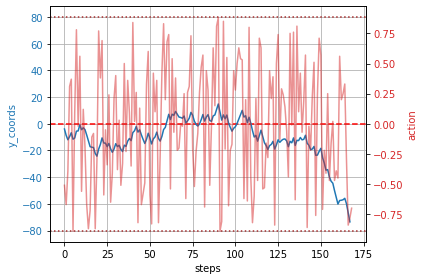

In [286]:
t="[[[4.2858367, 2.4641173], [4.460334, 7.481244], [8.453511, 10.3822975], [13.45275, 9.974758], [18.120651, 11.69122], [18.295149, 16.67546], [23.24649, 15.967284], [27.48673, 18.399467], [32.31636, 19.381563], [32.925705, 14.012485], [35.425705, 9.291754], [39.993435, 11.074469], [44.981255, 10.938452], [46.773094, 5.808299], [48.483192, 0.5634369], [50.983192, 4.3968816], [55.078953, 6.9677196], [60.030296, 7.522396], [64.36042, 9.784928], [67.83372, 13.182976], [69.29557, 8.279373], [70.84066, 12.868782], [74.437355, 16.218933], [77.01255, 20.375805], [81.58028, 22.398413], [85.57345, 19.16548], [88.58253, 22.948364], [92.727715, 25.255999], [94.840805, 29.150043], [99.596085, 27.157621], [104.4024, 25.348204], [109.0703, 23.124577], [113.26365, 20.201904], [115.913246, 15.887471], [120.24338, 18.246637], [125.0249, 19.664747], [129.17009, 16.460878], [133.92537, 14.490413], [135.87903, 18.716778], [139.5358, 22.064152], [143.90889, 24.734497], [146.17885, 20.32934], [151.17885, 20.385843], [155.71039, 22.643484], [160.66173, 23.5938], [165.65868, 24.044693], [170.41396, 22.872684], [173.42303, 19.51475], [178.41618, 19.888264], [183.28804, 21.759954], [183.63681, 27.359985], [187.782, 31.021214], [192.74474, 32.75197], [195.0147, 38.398228], [199.71315, 37.86501], [200.06194, 43.968204], [202.0156, 40.697598], [203.2252, 46.93553], [205.17885, 52.797115], [210.172, 54.262543], [215.1446, 55.118885], [219.2898, 54.00945], [221.4029, 50.98453], [226.36562, 52.948307], [231.32835, 53.67561], [236.17982, 56.030857], [241.17906, 56.999783], [243.21275, 53.494312], [247.49858, 52.218647], [250.57689, 49.760338], [255.57004, 50.998882], [256.6096, 47.660507], [257.73434, 44.454865], [262.6425, 45.211216], [266.2392, 50.174034], [267.27875, 56.592537], [268.9066, 62.725285], [273.77844, 65.14737], [275.2403, 71.38172], [280.02182, 74.6106], [280.3706, 70.9596], [283.58453, 68.41417], [285.12964, 64.92846], [289.66116, 64.124344], [294.6581, 65.557045], [296.03632, 71.59493], [298.6115, 77.22418], [298.9603, 73.63296], [302.55698, 78.39428], [306.09253, 76.292984], [307.6376, 72.98242], [310.1376, 78.71856], [315.08893, 79.15686], [0.0, 0.0]], [[4.996954, -0.043682575], [9.724547, 1.3563462], [13.717725, 3.8310292], [17.191017, -0.10956183], [17.71366, -5.5211816], [18.923267, -1.3613964], [23.920223, -1.9220715], [28.55614, -4.0558124], [33.36245, -2.9901972], [37.777187, -0.99230975], [42.777187, -1.5483445], [46.662918, -5.4485908], [47.098698, -11.046148], [48.138256, -6.6674495], [50.93422, -3.32152], [51.630085, -8.939284], [56.38537, -8.309683], [56.90801, -14.231605], [60.05461, -11.249723], [63.063686, -8.11898], [64.35778, -4.260009], [68.55113, -8.075566], [72.08667, -5.7679853], [77.08591, -7.037196], [77.17317, -3.0978627], [81.70471, -6.4515724], [84.91865, -3.8941503], [89.24877, -7.883786], [94.18722, -10.101145], [98.56031, -13.860516], [103.45105, -13.940797], [106.026245, -19.325022], [108.749435, -16.290424], [113.74867, -17.641773], [117.15867, -15.335786], [117.94084, -21.405016], [122.87928, -21.934393], [124.67112, -28.217924], [129.23885, -27.660757], [130.78394, -33.496357], [135.77176, -34.33446], [140.67989, -34.54194], [145.60393, -36.793995], [147.79579, -33.684013], [150.14314, -39.530922], [153.01102, -37.099743], [155.04471, -34.106853], [160.03786, -36.108276], [164.67377, -35.866806], [169.59781, -38.247517], [174.53625, -38.914978], [179.29153, -41.947998], [184.18228, -44.656136], [189.18228, -46.36908], [192.59227, -51.74213], [196.9224, -55.79808], [197.0969, -62.54368], [200.81262, -61.03126], [205.38034, -60.76817], [208.79033, -58.935806], [213.76294, -60.371925], [218.39886, -60.6405], [223.3981, -62.746265], [224.94319, -60.285416], [229.93102, -62.235447], [234.53354, -62.270245], [237.10872, -60.204857], [242.10187, -62.375126], [246.38771, -66.820816], [251.1153, -70.43747], [251.89748, -67.7235], [255.7832, -66.89491], [256.56537, -74.00047], [261.2013, -74.112045], [266.12534, -75.16386], [0.0, 0.0]], [[3.8302221, -3.1695755], [7.6604443, -0.20785984], [7.9221244, -5.3532205], [9.955808, -0.75428116], [11.080563, 4.3148885], [13.504611, 0.4411119], [16.300575, -3.2225158], [20.868303, -0.76509666], [25.806744, -1.0996275], [29.152397, 2.993808], [29.761744, 8.681773], [33.418514, 6.1814737], [38.399487, 7.2360034], [41.996185, 11.306056], [45.00526, 7.9961147], [49.99308, 8.046615], [54.691544, 6.9462967], [59.6885, 7.305929], [62.55638, 3.5696487], [63.934566, 8.695557], [68.349304, 6.5107594], [73.20078, 5.628857], [77.73232, 8.1483965], [80.81063, 4.543446], [85.00398, 7.472854], [86.63182, 12.427802], [90.517555, 9.314682], [95.490166, 8.851277], [95.66466, 13.786788], [96.01344, 8.7936735], [100.38654, 11.368994], [102.7339, 15.912976], [107.60575, 14.934229], [110.75235, 19.014206], [115.42025, 17.571669], [115.85603, 13.079261], [120.84918, 13.397104], [125.547646, 12.341073], [130.18356, 14.681811], [134.6386, 17.093822], [138.73436, 19.919044], [142.77943, 23.350698], [146.4362, 20.453821], [150.67645, 18.20638], [151.6305, 23.60602], [156.53864, 23.15945], [158.16647, 19.041513], [162.69801, 17.650673], [164.8111, 13.694899], [165.24687, 19.125977], [170.24612, 19.842527], [175.13686, 21.354128], [176.59871, 17.083881], [179.60779, 13.509067], [181.56145, 9.393752], [182.85555, 5.1791883], [186.06947, 9.526963], [188.79268, 6.040936], [188.87993, 11.633856], [192.35323, 15.699357], [196.3464, 13.122336], [200.00317, 10.163748], [204.991, 10.140328], [208.64777, 6.5822067], [211.99341, 2.5912352], [212.16791, -2.635246], [216.66188, -0.5891283], [220.65506, -3.7303982], [225.64821, -3.1654127], [230.28413, -0.89118296], [234.69887, 1.7237403], [238.4146, -1.3548052], [242.86963, 1.2452831], [247.86963, 1.6850652], [251.8628, 5.2580705], [254.65877, 10.0562525], [255.86838, 15.474264], [259.6419, 13.004511], [260.51016, 9.084435], [262.9342, 5.7235637], [263.80246, 11.591627], [264.842, 17.555727], [266.55212, 13.939841], [269.8324, 18.629591], [274.28745, 21.965279], [274.3747, 18.012623], [279.181, 20.79057], [282.71655, 25.181896], [287.04666, 23.735126], [290.98672, 27.772657], [292.19632, 23.724157], [297.16895, 24.079464], [299.28204, 20.885328], [303.22208, 25.107769], [303.74472, 31.385136], [307.63046, 36.01744], [311.10376, 33.99606], [316.06647, 36.081787], [321.0292, 38.131557], [325.35934, 42.42654], [329.4551, 41.32894], [334.2614, 44.52341], [335.6396, 51.238678], [340.62057, 52.86115], [343.8345, 59.016712], [345.04413, 66.468216], [349.95224, 68.07352], [354.75858, 69.06849], [359.72128, 70.91774], [362.29648, 68.86497], [366.0122, 74.274055], [370.96353, 76.96193], [0.0, 0.0]], [[2.3473577, -4.1400785], [6.443118, -6.79686], [7.4826765, -11.523983], [12.445407, -12.256267], [14.945407, -7.8925624], [16.155016, -2.8205318], [19.985239, 0.6009903], [23.330893, 4.475481], [27.10444, 1.2753346], [31.635979, 3.835626], [33.097836, -0.21667801], [34.391933, -4.294978], [39.198242, -2.2956147], [43.61298, -4.223775], [43.87466, 1.1081977], [48.51058, 3.4265058], [52.75082, 6.3368673], [57.68926, 7.563899], [61.462807, 4.6504855], [66.098724, 3.0751867], [69.37902, -0.51490796], [72.17499, -4.649927], [76.90258, -6.2770805], [79.77046, -10.288914], [84.498055, -8.862983], [86.371086, -4.665144], [91.007, -3.1970747], [94.60371, -7.221969], [97.326904, -11.876787], [100.12286, -8.444502], [103.40316, -12.88365], [108.39631, -13.264227], [113.38946, -13.80979], [118.14474, -12.990407], [123.12571, -13.267992], [123.38739, -18.76764], [128.37521, -18.958405], [130.00305, -14.868153], [133.34871, -11.820574], [135.30237, -17.256514], [139.34744, -20.965097], [144.04591, -19.960167], [147.87613, -17.036516], [152.84874, -18.037111], [156.1944, -14.74343], [159.06227, -19.35201], [163.98631, -19.055555], [168.92476, -19.014452], [173.91258, -20.091442], [176.99089, -16.88748], [178.78273, -22.582518], [183.02296, -21.017624], [187.5907, -24.042156], [192.00543, -27.142042], [196.94388, -28.444595], [197.37965, -33.905113], [202.20927, -35.819023], [203.41888, -31.835482], [204.88075, -37.758545], [209.0741, -41.891468], [214.05507, -42.726517], [218.38521, -46.25315], [223.32364, -48.245483], [223.58533, -54.220963], [225.1304, -60.164333], [229.27559, -58.598232], [231.77559, -55.354103], [236.64745, -57.673477], [238.9948, -54.46399], [243.94615, -54.97956], [248.44011, -58.367672], [252.27034, -56.230045], [253.7322, -61.738644], [255.44229, -57.856308], [259.8154, -61.236053], [261.52548, -57.658535], [265.5706, -61.757275], [269.66635, -65.7596], [272.5342, -62.831356], [275.0342, -59.44768], [279.60196, -58.275074], [283.7953, -61.8258], [284.31793, -67.73534], [289.07324, -70.318275], [294.06638, -71.09602], [294.24088, -76.887054], [297.52118, -73.93068], [299.7911, -70.39532], [301.8248, -75.9763], [0.0, 0.0]], [[4.8514786, -1.3369921], [9.824088, -0.99554014], [12.399279, 3.1019652], [17.290016, 3.8904574], [18.07219, 8.797598], [18.85436, 13.575832], [19.377003, 18.492563], [24.267742, 19.504099], [26.767742, 23.792631], [31.097868, 26.121424], [32.476055, 30.805252], [34.900105, 26.266373], [39.2732, 23.704659], [42.141083, 19.455942], [45.008965, 23.317766], [47.356323, 27.373833], [51.68645, 24.546503], [56.32237, 25.939167], [59.979137, 22.190727], [60.327923, 26.940044], [63.051117, 30.618378], [67.0443, 26.999931], [69.31425, 22.199848], [73.02997, 25.196053], [74.657814, 29.674389], [78.25451, 32.934162], [79.46412, 27.98096], [83.749954, 30.582611], [87.74313, 27.445034], [92.37905, 29.109531], [95.97575, 32.446033], [100.26159, 34.878315], [105.22432, 34.36968], [107.17798, 29.867401], [111.7805, 27.820868], [112.90526, 22.707151], [117.87786, 21.820515], [122.659386, 22.876652], [124.77248, 27.070805], [125.982086, 31.639997], [130.78839, 32.626236], [131.48427, 36.92486], [134.42319, 40.327316], [139.38593, 39.086758], [144.35854, 39.253075], [149.30988, 38.341606], [153.24992, 41.48761], [154.79501, 46.304356], [156.50511, 41.89515], [161.37695, 43.172356], [162.2452, 48.13122], [164.35829, 52.70617], [164.53279, 47.60378], [168.363, 50.603497], [173.11829, 48.920883], [176.59158, 52.339848], [179.93724, 48.595608], [183.08385, 52.43615], [186.09291, 56.178047], [186.96115, 50.95506], [187.4838, 55.929134], [192.18227, 54.611538], [196.96379, 53.856625], [199.38783, 58.91022], [203.71796, 62.28128], [205.83105, 58.725216], [208.97766, 63.6683], [213.94038, 65.37265], [218.93353, 66.80927], [220.88719, 63.20837], [225.88414, 64.42422], [227.42923, 60.289433], [231.80232, 58.2094], [236.76506, 59.017628], [237.3744, 64.23811], [240.90994, 61.105022], [242.53778, 66.26488], [243.91597, 71.40319], [245.70781, 67.00248], [250.70781, 67.03596], [253.78612, 71.09027], [258.78308, 71.21214], [260.81674, 66.96775], [264.5903, 63.736423], [269.08426, 65.63579], [271.27612, 60.59225], [271.5378, 55.151546], [272.14716, 59.618057], [277.11975, 58.60795], [280.46542, 54.228867], [281.33365, 48.88037], [283.90884, 44.069107], [288.47656, 45.354248], [293.4006, 45.7499], [297.59396, 47.88272], [302.19647, 49.31423], [305.79318, 45.398228], [307.1714, 39.83856], [312.1714, 39.19163], [317.001, 39.96064], [320.71674, 42.98083], [324.49026, 46.11026], [328.53537, 49.03111], [333.17126, 50.5217], [334.29602, 55.019844], [335.92386, 50.054966], [339.26953, 53.612034], [342.61517, 49.847], [345.76178, 53.60194], [347.79547, 49.064125], [351.6257, 46.027473], [356.56412, 45.18881], [361.2626, 46.908764], [364.47653, 42.882008], [367.34442, 46.93927], [372.01233, 48.723915], [376.54385, 50.752514], [379.55292, 54.524067], [383.59802, 57.449806], [387.07132, 54.14848], [390.4813, 51.01284], [393.5596, 47.52148], [398.09116, 45.606525], [398.95938, 40.76449], [403.19962, 43.535824], [407.02985, 40.49577], [411.88132, 39.611702], [415.76706, 43.300137], [416.3764, 38.9687], [418.08652, 35.026237], [422.8418, 37.29188], [423.62396, 42.966537], [426.34717, 39.33941], [430.1207, 43.311253], [430.64334, 48.94542], [435.31125, 47.72419], [438.38956, 44.447666], [443.34088, 45.7427], [447.386, 49.121006], [452.11356, 47.5811], [452.80945, 52.621418], [457.00278, 55.672188], [461.91092, 55.102856], [461.9982, 50.486507], [466.37128, 48.288948], [471.12656, 46.9676], [471.21384, 42.29481], [473.86343, 38.385498], [475.3253, 43.610283], [479.37036, 41.151306], [483.2006, 38.370895], [487.9282, 37.669815], [488.45084, 43.86565], [489.66043, 50.284115], [492.38364, 47.678867], [494.33728, 54.093117], [498.22302, 59.166508], [502.92148, 59.534683], [504.46655, 66.4832], [508.6599, 71.07151], [513.033, 70.58218], [518.014, 72.866936], [522.96533, 75.70378], [527.90375, 76.89884], [0.0, 0.0]], [[1.6278408, 4.290385], [6.535977, 4.678442], [6.9717555, 9.087348], [11.910197, 7.7127743], [16.800936, 7.984034], [18.673967, 12.013434], [23.129002, 8.976306], [23.651644, 13.354728], [26.798244, 8.544543], [29.145603, 12.093113], [32.292206, 14.962381], [37.18294, 14.874764], [39.90614, 9.505473], [40.77438, 3.4671626], [45.77133, 2.5268934], [50.33906, -0.5416112], [50.687843, -6.646094], [53.555725, -3.4871914], [54.25159, 0.61013013], [58.13732, 2.8197784], [61.482975, 5.57164], [62.607727, -0.20645826], [64.48076, -5.596651], [67.419685, -2.4726012], [69.12979, -8.2581415], [71.08344, -4.7871275], [71.25794, -10.810949], [76.12979, -10.829307], [78.99767, -16.382174], [83.93612, -16.932251], [88.82685, -19.097466], [93.82685, -20.074318], [97.48362, -24.536821], [102.21121, -23.962814], [105.86798, -21.56074], [107.16208, -17.789757], [111.65605, -21.266424], [116.580086, -23.470753], [120.295815, -27.95063], [120.47031, -34.125263], [124.88505, -37.806778], [125.23383, -43.979034], [128.57948, -48.732925], [129.61903, -54.630814], [133.02904, -52.05469], [133.29071, -58.007736], [136.7007, -55.189957], [140.1107, -59.649555], [141.48888, -55.588966], [146.48813, -56.83238], [148.11597, -62.843964], [152.96744, -62.75981], [155.69064, -67.93525], [159.73572, -66.18562], [160.60396, -62.468876], [161.03973, -58.974964], [163.2316, -55.99853], [168.2316, -57.72763], [173.18294, -60.18903], [177.01315, -58.96853], [177.62251, -56.04377], [182.53064, -58.801964], [187.51846, -60.117817], [191.61423, -58.961136], [196.58684, -61.23677], [199.66515, -58.8326], [203.26184, -63.635242], [208.13368, -65.996864], [213.04182, -66.17745], [216.25577, -63.365116], [220.89168, -66.53735], [225.2218, -70.42194], [229.31757, -74.78963], [232.32664, -72.17185], [235.26556, -69.49252], [236.89342, -65.96944], [238.1875, -62.391605], [238.44919, -58.641014], [240.94919, -64.42395], [245.18942, -68.43282], [245.79877, -74.78033], [248.87708, -71.89959], [252.97284, -75.794266], [0.0, 0.0]], [[2.723195, -4.2286754], [7.5746737, -2.9102976], [12.356197, -1.366276], [16.958721, -3.2353947], [21.054482, -6.179906], [25.992924, -5.3914022], [29.878654, -2.3219059], [34.76939, -3.898078], [39.73212, -5.266952], [40.68617, -10.739526], [45.016293, -13.973988], [48.551826, -18.229202], [53.50317, -19.581583], [58.105694, -18.381197], [62.708218, -21.132841], [66.948456, -24.50738], [70.22875, -29.13397], [75.19148, -29.622965], [76.05972, -35.6289], [79.34002, -33.115784], [80.464775, -39.370712], [84.996315, -38.389866], [89.92035, -40.489384], [93.6939, -38.496624], [98.42149, -41.630035], [102.75162, -40.56643], [107.70296, -41.362053], [108.742516, -38.07056], [110.120705, -44.33265], [113.26731, -49.430347], [115.9905, -46.513943], [120.96311, -47.19139], [125.96235, -48.457893], [128.75832, -45.728745], [130.38615, -51.89724], [135.2769, -52.426758], [135.79953, -49.170403], [140.498, -49.289177], [145.498, -51.04569], [150.49115, -52.93689], [152.60423, -50.2318], [157.60347, -52.072548], [161.93361, -56.29175], [165.27925, -54.215946], [166.82434, -50.992302], [168.53444, -47.997894], [173.51541, -50.03382], [178.51541, -51.807392], [181.59372, -49.77538], [185.25049, -48.104866], [189.13622, -46.5401], [194.13622, -48.200985], [198.37646, -52.359783], [203.3278, -54.62302], [208.29053, -56.756653], [208.81317, -63.552288], [213.30714, -67.47974], [215.5771, -73.691696], [0.0, 0.0]], [[1.9536556, -4.568623], [5.610424, -1.3271376], [7.3205247, 3.2347248], [12.126833, 4.525398], [17.089563, 3.6531944], [17.698912, -1.4642887], [21.939152, 1.1095924], [26.926971, 0.5743273], [29.576569, -3.7601194], [33.292294, -7.2075047], [36.949062, -3.9851468], [40.294712, -7.9770813], [44.534954, -5.636679], [45.0576, -10.628663], [48.714363, -13.99494], [51.214363, -18.161871], [53.006203, -13.149933], [57.573933, -10.862477], [61.404156, -7.246105], [65.898125, -9.221114], [70.653404, -10.699024], [73.00076, -6.2024117], [74.04032, -1.0887156], [79.03347, -1.1318241], [83.6012, 1.0590994], [85.146286, 5.9259405], [88.36022, 10.052994], [90.07032, 15.0493355], [90.76619, 10.445164], [94.861946, 13.579435], [98.518715, 17.12765], [101.527794, 21.143797], [106.43593, 19.869818], [109.445, 15.351005], [113.730835, 17.332342], [117.775925, 19.493519], [121.121574, 14.792069], [125.06163, 10.600314], [129.51666, 11.642017], [134.15259, 12.279435], [135.02083, 5.8824263], [138.61752, 7.83539], [138.96631, 11.453161], [143.96326, 10.506492], [147.4988, 5.6872725], [152.38953, 5.57212], [153.68362, -0.4195453], [154.80838, 3.3843102], [158.28168, 6.003148], [159.99178, 9.885448], [163.76532, 5.979061], [166.48851, 9.739996], [171.05624, 7.115578], [176.00758, 7.443712], [180.24782, 4.708619], [183.52812, 0.9109211], [185.40115, 5.1772585], [186.77934, -0.20009677], [191.53462, -2.2183816], [195.07016, 0.81224316], [197.93803, 4.3729186], [198.9776, -1.117172], [203.70518, -0.11127044], [207.85037, -3.0153315], [208.37302, -8.109071], [209.06888, -3.3678415], [213.89851, -4.8876123], [217.49521, -1.8925151], [220.90521, -6.228829], [221.0797, -2.0860236], [222.95274, -7.785691], [226.36273, -12.425366], [227.1449, -18.454777], [231.38515, -22.1776], [232.59476, -18.063814], [236.25153, -22.351425], [241.05783, -22.063505], [241.1451, -17.9573], [244.29169, -22.779325], [246.56165, -19.376627], [247.42989, -15.561695], [251.20343, -13.720945], [253.62749, -11.01142], [254.75224, -7.6017985], [259.73322, -8.810745], [264.14795, -8.456212], [268.8464, -8.680349], [269.36905, -5.561599], [272.3781, -3.394064], [272.6398, -10.144559], [276.29657, -8.534222], [277.59067, -15.286566], [282.5147, -17.813246], [285.0147, -15.379336], [287.8826, -13.672161], [290.82153, -20.16698], [295.5491, -24.560402], [300.43985, -28.257238], [304.27008, -27.536762], [309.2579, -29.446466], [312.53818, -27.840565], [316.3684, -32.95733], [321.36154, -35.09749], [324.15753, -33.264057], [328.9128, -34.0326], [331.4128, -31.897036], [336.21912, -35.428677], [337.25867, -32.714287], [342.11014, -36.252594], [345.94037, -35.593098], [347.7322, -42.754368], [352.29993, -47.32122], [356.13016, -52.99501], [360.62415, -57.766613], [365.59674, -61.02773], [370.32434, -65.53628], [372.03442, -73.26492], [376.07953, -73.4289], [380.1753, -79.750984], [0.0, 0.0]], [[4.2402406, -2.7611284], [9.091719, -4.108334], [13.873243, -5.725269], [15.746276, -1.2309327], [18.824583, 2.5437312], [19.260363, -2.4406135], [24.257317, -2.7538998], [29.129166, -3.932255], [30.591024, 0.9449616], [35.04606, 3.387901], [38.642757, -0.13889892], [38.73002, 4.822082], [42.326717, 8.133044], [46.820686, 5.9824157], [47.945442, 0.97774667], [48.55479, 5.8394766], [53.38442, 6.7981834], [57.57777, 3.80436], [58.702526, 8.145962], [63.675137, 8.073067], [68.24287, 9.559164], [70.51282, 13.534837], [75.18072, 11.489668], [80.08885, 12.267368], [85.0881, 11.881894], [89.8944, 10.225093], [91.52224, 5.1635857], [95.618004, 7.763256], [100.55644, 6.846622], [104.65221, 9.510241], [105.000984, 14.206332], [109.89172, 12.690976], [114.17756, 14.76657], [118.06329, 17.86321], [122.59483, 15.641078], [124.139915, 20.316996], [129.12773, 20.318707], [133.41357, 22.4922], [136.94911, 25.481297], [140.72266, 28.194399], [145.17769, 25.327505], [149.84558, 26.364372], [150.88515, 30.388617], [153.89423, 33.426277], [158.22435, 29.89311], [162.36954, 26.254652], [164.94473, 21.050655], [169.77435, 18.97772], [169.94885, 22.911413], [173.94203, 24.872873], [178.90475, 24.40304], [182.84482, 26.41655], [182.93208, 20.084784], [187.92523, 18.992924], [192.92523, 17.63387], [196.39851, 12.730366], [201.12611, 12.890177], [203.39606, 15.944351], [207.85109, 16.921867], [212.18123, 18.158157], [212.79057, 11.790849], [217.78372, 10.389899], [219.57556, 4.614123], [221.68864, -1.1444029], [224.1127, 2.1573496], [224.37437, 6.0481186], [229.3622, 5.0902743], [231.70955, 8.430232], [235.11955, 3.8146725], [237.3114, 7.493016], [238.09357, 11.704231], [242.87509, 9.531735], [243.74333, 13.622432], [248.74258, 13.079659], [253.7053, 11.799424], [256.7836, 15.31942], [261.41953, 13.018903], [265.3596, 9.574617], [270.29803, 9.960648], [274.4432, 12.247881], [279.07913, 9.878054], [283.96988, 10.434579], [288.2101, 12.49511], [293.20935, 11.553858], [296.9829, 14.010122], [297.41867, 8.032311], [298.3727, 11.839769], [300.3264, 5.912665], [305.1079, 6.1301527], [306.06195, -0.04865075], [309.14026, -5.409835], [314.1372, -6.989247], [319.02795, -9.275015], [320.73804, -6.0455623], [322.77173, -3.2810915], [325.49493, -9.38964], [327.28677, -6.5567083], [328.99686, -3.735203], [330.54196, -10.3346815], [335.54196, -11.896885], [339.99698, -11.212545], [343.21094, -9.170761], [347.04114, -7.6189246], [349.61633, -5.221425], [352.96198, -10.868211], [356.04028, -16.671461], [357.4185, -23.040499], [358.54324, -19.806093], [363.434, -20.250006], [367.42715, -24.506367], [372.09506, -27.704166], [377.0943, -28.8541], [382.08743, -30.182888], [384.81064, -35.14089], [388.8038, -32.71946], [388.9783, -27.908838], [392.86404, -31.065613], [397.861, -31.11709], [400.72888, -35.2782], [401.25153, -30.383484], [406.08115, -29.194172], [411.08038, -29.235523], [414.29434, -25.236795], [419.28748, -24.896137], [424.17822, -23.937195], [426.2913, -28.671299], [427.5854, -33.49475], [430.52432, -29.27478], [435.52356, -28.994799], [438.80386, -32.829796], [443.47177, -34.688263], [446.41068, -30.535608], [448.03854, -25.649242], [450.3859, -21.155191], [454.10162, -24.23654], [457.81732, -20.283382], [461.86243, -22.650517], [466.82516, -22.38083], [469.0951, -26.2206], [472.81082, -28.991428], [474.92392, -23.619154], [477.64713, -18.466248], [480.58603, -21.628382], [482.61972, -25.459278], [485.62878, -20.996422], [490.50064, -19.257763], [495.28217, -20.297155], [498.69217, -16.101856], [501.70123, -11.637088], [506.6526, -11.864876], [510.36832, -14.600409], [515.0042, -15.728507], [519.1, -12.1248045], [524.06274, -11.885072], [525.9357, -6.0159683], [529.01404, -1.052314], [533.05914, 2.6788757], [534.26874, 8.32915], [538.0423, 12.18759], [542.99365, 13.532123], [546.7672, 17.542723], [550.6529, 14.805671], [552.28076, 19.745], [555.56104, 16.547123], [560.3907, 15.668915], [564.48645, 18.849989], [567.06165, 14.572263], [567.5843, 19.487143], [572.47504, 20.684538], [574.8224, 16.392714], [578.9675, 19.315731], [581.5427, 23.633379], [584.7567, 19.843405], [586.79034, 24.59743], [591.07623, 22.270855], [593.65137, 26.859474], [598.58984, 28.130028], [599.19916, 23.80563], [600.1532, 19.49812], [603.2315, 24.113077], [606.70483, 21.129791], [609.7139, 17.758831], [613.9072, 15.654629], [615.6174, 11.547026], [620.5558, 11.563046], [621.68054, 7.4651933], [625.0905, 4.6707153], [628.4362, 1.8985088], [628.6107, 7.8135595], [633.54913, 8.041816], [635.4222, 13.724546], [637.614, 19.271889], [640.6923, 16.32436], [643.97266, 13.237948], [648.8241, 15.126948], [652.16974, 11.980089], [654.5171, 8.298307], [659.46844, 8.619558], [660.8466, 14.563515], [665.7707, 14.705999], [668.3459, 11.452561], [669.8909, 7.607423], [671.43604, 13.233953], [674.30396, 9.875638], [678.13416, 13.858354], [678.56995, 19.722254], [679.0926, 15.5134], [683.9644, 17.219568], [684.91846, 12.68479], [689.7481, 11.9467], [690.87286, 7.7124696], [691.5687, 3.1872249], [696.47687, 4.3031178], [700.19257, 7.819293], [700.5414, 3.0205526], [700.9771, 8.094367], [705.86786, 7.140388], [710.776, 8.26137], [714.3727, 4.96263], [717.3818, 1.0406108], [722.0177, -0.9896894], [724.4418, 3.3507917], [727.1649, 7.4849467], [731.80084, 5.3691535], [732.9256, 10.0297785], [737.5615, 11.575818], [738.1709, 6.36245], [742.6259, 8.279699], [743.92004, 3.299905], [747.45557, 6.4742618], [747.89136, 10.798296], [750.6873, 14.447091], [755.53876, 15.210879], [758.03876, 10.388734], [759.6666, 5.2266154], [763.99677, 7.2933717], [765.7886, 11.888055], [770.5162, 13.46987], [773.0162, 17.567026], [774.22577, 22.29695], [779.22577, 21.956835], [782.9415, 24.972944], [784.56934, 19.975288], [789.1009, 21.96221], [791.37085, 26.332682], [792.58044, 30.98244], [796.29614, 33.906788], [801.27716, 33.116005], [801.3644, 37.61031], [806.23627, 36.062492], [811.2332, 35.289528], [816.1572, 35.278763], [816.41895, 29.180225], [821.20044, 26.598625], [825.95575, 23.68138], [830.62366, 23.962095], [835.6046, 21.751936], [840.543, 20.730478], [841.2389, 13.70878], [841.93475, 6.665903], [843.7266, 0.01801698], [847.4423, -5.413722], [851.9739, -5.499174], [852.2356, -2.924635], [857.0419, -3.8080182], [857.12915, -11.199416], [857.30365, -8.8563385], [860.7769, -15.319674], [865.34467, -15.935934], [865.6063, -13.500591], [870.6056, -16.35066], [874.2023, -22.386284], [876.77747, -20.596521], [878.73114, -27.59048], [882.8269, -26.944242], [887.19995, -31.361998], [892.1384, -34.411777], [893.5166, -41.37237], [895.0617, -38.830536], [895.4975, -35.93939], [900.0652, -40.165207], [904.63293, -44.4071], [909.30084, -48.514088], [910.8459, -46.27426], [915.83905, -49.172577], [917.6309, -56.203815], [921.7267, -55.340958], [926.6993, -57.62229], [930.89264, -62.4362], [935.26575, -61.97033], [939.36145, -66.48505], [942.2294, -72.16333], [947.01086, -75.22529], [949.51086, -72.40581], [954.0049, -71.86878], [957.6616, -77.08717], [962.6609, -78.68478], [0.0, 0.0]], [[3.146602, -3.9050403], [5.1002574, -8.703933], [8.985988, -11.968243], [13.271824, -9.622167], [17.265001, -6.709125], [17.352264, -11.550544], [22.290705, -10.648781], [23.330263, -5.5285993], [28.327217, -5.341527], [31.123182, -0.81511015], [33.919147, -4.4326606], [38.809883, -2.999332], [43.53748, -4.3236547], [45.491135, -8.352166], [45.75281, -12.81408], [47.297897, -17.160305], [52.206036, -17.554314], [57.157375, -17.802967], [57.419056, -22.193178], [61.74918, -24.263689], [62.873936, -18.978746], [66.81399, -15.518598], [68.60583, -10.574459], [71.18102, -14.383797], [76.161995, -14.524067], [80.30718, -17.140408], [84.87491, -14.730313], [86.988, -18.760738], [90.76155, -21.380302], [95.42945, -18.863575], [99.259674, -14.888311], [103.19973, -17.093666], [108.19287, -16.112015], [111.33948, -19.11306], [115.53283, -20.834246], [118.746765, -16.006704], [123.34929, -16.916187], [127.39438, -12.966117], [132.33282, -10.994944], [136.42857, -12.644651], [136.95122, -6.596074], [141.94818, -5.2038417], [146.44214, -1.941938], [147.13802, -6.214487], [152.00986, -4.5159483], [153.96352, -8.311304], [156.61311, -11.656676], [159.8934, -14.767664], [164.08676, -11.660158], [166.58676, -7.0567036], [169.16196, -10.788071], [169.7713, -15.089381], [173.48701, -11.283393], [178.41106, -9.83022], [182.45615, -6.2470264], [183.15201, -10.947253], [187.64598, -12.970347], [191.36171, -9.468199], [191.97105, -4.303342], [196.66951, -2.6847212], [198.54254, 2.1336353], [199.92073, 7.1084933], [202.85966, 3.1602683], [205.79858, 7.1647964], [210.76132, 6.380837], [214.70137, 9.248884], [219.3373, 7.18098], [224.03575, 5.085159], [229.03575, 4.7161407], [234.03271, 4.1432414], [238.56425, 5.8095455], [240.9116, 0.66359437], [245.40558, 2.1306183], [249.6914, 4.1850295], [251.15327, 8.561259], [255.82117, 6.3959546], [258.89948, 1.9659059], [263.502, -0.4783228], [268.45334, -1.6942847], [272.94733, -0.15557696], [276.3573, 3.1092708], [279.0805, 6.969123], [280.87234, 2.027108], [284.46906, 5.039567], [288.8838, 6.8591533], [292.0304, 2.5345087], [297.02734, 1.8482666], [299.2973, 5.9115157], [304.12692, 6.6555085], [304.9091, 10.705837], [305.0836, 14.852777], [305.17084, 8.7522135], [305.95303, 2.761445], [306.3888, 6.657334], [311.0567, 3.7717443], [313.9246, 6.5642157], [315.7976, 0.5184069], [320.43353, -2.6742942], [325.21506, -5.5251007], [328.81177, -3.3623168], [333.2265, -2.1756008], [336.44043, 0.33849177], [338.7104, 3.6301336], [341.64932, 6.7751975], [344.6584, 10.065847], [347.00574, 5.053194], [351.70422, 6.0306454], [353.89606, 0.79504687], [354.7643, 4.917539], [358.361, 0.5340527], [359.0569, -5.084563], [361.5569, -9.915068], [366.22476, -8.6800995], [369.63477, -13.009486], [371.2626, -8.815776], [373.53256, -4.764383], [376.4715, -9.411345], [379.48056, -14.240292], [384.28687, -16.321821], [388.7016, -19.273226], [392.2983, -16.359457], [396.96622, -15.452391], [400.85193, -13.156922], [401.37457, -18.925497], [404.58853, -15.778942], [405.9667, -11.985929], [410.83856, -13.8808155], [415.21164, -12.470549], [419.7794, -11.57751], [424.63086, -11.347118], [429.60345, -12.844041], [433.20016, -17.165504], [434.49426, -13.119285], [439.4935, -14.237777], [440.70312, -10.57595], [442.97305, -16.25786], [443.75525, -12.413054], [448.67926, -12.567224], [452.395, -10.272551], [457.35773, -12.033968], [462.08533, -11.644184], [464.8085, -8.600615], [465.1573, -14.588826], [470.15427, -16.061321], [474.79016, -19.359035], [479.3927, -18.934004], [482.5393, -16.96233], [483.7489, -23.611053], [488.31665, -23.496058], [489.9445, -20.652569], [492.66766, -18.39452], [494.2955, -25.3709], [498.93143, -29.399057], [502.705, -34.751503], [507.2365, -34.34654], [510.6465, -39.876137], [515.4528, -43.03738], [520.44977, -44.513847], [523.85974, -50.06248], [527.7455, -54.95432], [531.281, -60.166077], [534.07697, -57.479786], [538.77545, -57.31264], [543.307, -56.92217], [547.50037, -55.856213], [551.83044, -59.97073], [552.3531, -66.76791], [553.3927, -73.49996], [0.0, 0.0]]]"
a="[[0.31, 0.88, 0.37, -0.01, 0.21, 0.88, -0.08, 0.32, 0.15, -0.83, -0.6, 0.24, 0.04, -0.69, -0.7, 0.6, 0.35, 0.08, 0.3, 0.46, -0.73, 0.72, 0.44, 0.59, 0.24, -0.37, 0.53, 0.34, 0.65, -0.18, -0.16, -0.21, -0.33, -0.58, 0.3, 0.17, -0.34, -0.18, 0.67, 0.43, 0.29, -0.63, 0.0, 0.25, 0.08, 0.02, -0.18, -0.53, -0.03, 0.13, 0.86, 0.34, 0.07, 0.63, -0.2, 0.86, -0.67, 0.76, 0.67, 0.03, -0.06, -0.34, -0.65, 0.07, -0.07, 0.14, -0.01, -0.66, -0.31, -0.52, -0.03, -0.78, -0.77, -0.11, 0.44, 0.78, 0.71, 0.13, 0.73, 0.17, -0.86, -0.5, -0.72, -0.25, 0.02, 0.74, 0.59, -0.86, 0.44, -0.45, -0.72, 0.6, -0.08, 0.09], [0.02, 0.19, 0.37, -0.46, -0.84, 0.76, -0.02, -0.22, 0.16, 0.28, 0.0, -0.39, -0.85, 0.78, 0.56, -0.82, 0.18, -0.84, 0.51, 0.53, 0.75, -0.33, 0.45, -0.01, 0.89, -0.25, 0.5, -0.3, -0.09, -0.29, 0.12, -0.59, 0.57, 0.01, 0.47, -0.81, 0.09, -0.69, 0.24, -0.72, 0.04, 0.11, -0.1, 0.64, -0.62, 0.55, 0.66, -0.03, 0.22, -0.1, 0.09, -0.18, -0.12, 0.0, -0.47, -0.3, -0.88, 0.42, 0.24, 0.47, 0.06, 0.22, 0.01, 0.72, 0.04, 0.23, 0.59, -0.03, -0.31, -0.19, 0.81, 0.39, -0.81, 0.22, 0.1, -0.61], [-0.4, 0.4, -0.87, 0.66, 0.77, -0.61, -0.56, 0.24, -0.09, 0.48, 0.83, -0.43, 0.05, 0.44, -0.53, -0.04, -0.2, -0.02, -0.55, 0.74, -0.28, -0.14, 0.25, -0.52, 0.33, 0.71, -0.39, -0.06, 0.88, -0.86, 0.29, 0.62, -0.13, 0.51, -0.21, -0.85, -0.03, -0.2, 0.22, 0.27, 0.35, 0.36, -0.43, -0.32, 0.79, -0.11, -0.71, -0.25, -0.65, 0.85, 0.01, 0.12, -0.73, -0.53, -0.67, -0.75, 0.5, -0.57, 0.89, 0.46, -0.37, -0.43, -0.04, -0.43, -0.48, -0.88, 0.26, -0.37, 0.03, 0.22, 0.28, -0.42, 0.27, 0.0, 0.37, 0.56, 0.76, -0.41, -0.8, -0.61, 0.8, 0.78, -0.7, 0.49, 0.27, -0.89, 0.16, 0.45, -0.3, 0.38, -0.76, -0.06, -0.65, 0.38, 0.84, 0.39, -0.46, 0.07, 0.07, 0.3, -0.35, 0.16, 0.74, -0.05, 0.5, 0.76, -0.11, -0.16, -0.07, -0.59, 0.42, 0.08, 0.44], [-0.62, -0.35, -0.78, -0.07, 0.6, 0.76, 0.4, 0.48, -0.41, 0.25, -0.73, -0.75, 0.16, -0.28, 0.87, 0.22, 0.32, 0.09, -0.41, -0.22, -0.49, -0.56, -0.19, -0.55, 0.19, 0.68, 0.22, -0.44, -0.57, 0.56, -0.49, 0.03, 0.03, 0.18, 0.05, -0.87, 0.04, 0.71, 0.48, -0.67, -0.36, 0.2, 0.4, -0.06, 0.48, -0.55, 0.1, 0.09, -0.04, 0.52, -0.69, 0.32, -0.24, -0.28, -0.09, -0.85, -0.15, 0.76, -0.73, -0.33, 0.05, -0.3, -0.09, -0.87, -0.72, 0.34, 0.6, -0.13, 0.62, 0.08, -0.26, 0.4, -0.73, 0.7, -0.29, 0.7, -0.36, -0.35, 0.55, 0.6, 0.24, -0.33, -0.84, -0.18, 0.03, -0.88, 0.49, 0.63, -0.66, -0.38], [-0.14, 0.06, 0.59, 0.12, 0.81, 0.81, 0.84, 0.12, 0.6, 0.3, 0.74, -0.61, -0.29, -0.55, 0.55, 0.62, -0.3, 0.22, -0.43, 0.86, 0.57, -0.37, -0.63, 0.42, 0.71, 0.44, -0.76, 0.31, -0.37, 0.22, 0.44, 0.31, -0.07, -0.67, -0.23, -0.77, -0.06, 0.17, 0.65, 0.76, 0.16, 0.82, 0.54, -0.07, 0.06, -0.08, 0.38, 0.72, -0.7, 0.13, 0.8, 0.65, -0.88, 0.4, -0.18, 0.46, -0.48, 0.51, 0.53, -0.8, 0.84, -0.2, -0.17, 0.61, 0.3, -0.65, 0.51, 0.07, 0.03, -0.67, 0.02, -0.72, -0.29, 0.07, 0.83, -0.45, 0.71, 0.74, -0.69, 0.0, 0.52, -0.02, -0.66, -0.41, 0.26, -0.64, -0.87, 0.83, -0.06, -0.48, -0.8, -0.59, 0.24, 0.1, 0.33, 0.23, -0.44, -0.74, 0.0, 0.15, 0.42, 0.41, 0.36, 0.22, 0.77, -0.71, 0.48, -0.48, 0.51, -0.66, -0.4, -0.09, 0.2, -0.5, 0.55, 0.21, 0.25, 0.53, 0.36, -0.46, -0.47, -0.52, -0.25, -0.8, 0.32, -0.4, -0.14, 0.39, -0.83, -0.7, 0.18, 0.81, -0.57, 0.41, 0.84, -0.21, -0.52, 0.08, 0.36, -0.19, 0.82, 0.33, -0.11, -0.89, -0.29, -0.18, -0.89, -0.58, 0.73, -0.36, -0.4, -0.19, 0.84, 0.76, -0.57, 0.67, 0.39, -0.2, 0.72, 0.33, -0.29, 0.05, 0.08, -0.09, 0.7], [0.71, 0.11, 0.85, -0.09, 0.12, 0.68, -0.27, 0.84, -0.51, 0.62, 0.51, 0.12, -0.57, -0.8, 0.02, -0.24, -0.86, 0.55, 0.82, 0.39, 0.48, -0.77, -0.68, 0.54, -0.7, 0.67, -0.88, 0.13, -0.55, 0.09, -0.12, 0.0, -0.43, 0.19, 0.43, 0.75, -0.26, -0.1, -0.42, -0.88, -0.28, -0.86, -0.48, -0.78, 0.47, -0.87, 0.47, -0.47, 0.74, -0.01, -0.71, 0.14, -0.57, 0.36, 0.8, 0.85, 0.64, 0.0, -0.08, 0.4, 0.83, -0.11, 0.04, 0.35, -0.06, 0.52, -0.44, -0.13, 0.11, 0.5, -0.22, -0.3, -0.35, 0.53, 0.54, 0.71, 0.75, 0.87, -0.6, -0.32, -0.83, 0.52, -0.35, -0.65], [-0.57, 0.14, 0.17, -0.23, -0.35, 0.09, 0.39, -0.12, -0.07, -0.79, -0.3, -0.45, -0.08, 0.23, -0.23, -0.32, -0.49, 0.07, -0.8, 0.49, -0.77, 0.25, -0.1, 0.41, -0.19, 0.3, 0.08, 0.78, -0.74, -0.51, 0.57, 0.06, -0.01, 0.56, -0.71, 0.12, 0.84, 0.2, 0.0, -0.03, 0.65, -0.01, -0.3, 0.48, 0.72, 0.7, -0.05, 0.0, 0.52, 0.43, 0.39, 0.0, -0.32, -0.08, -0.07, -0.84, -0.26, -0.63, -0.89], [-0.67, 0.43, 0.7, 0.16, -0.07, -0.83, 0.32, -0.04, -0.58, -0.42, 0.43, -0.48, 0.32, -0.84, -0.43, -0.6, 0.69, 0.24, 0.4, -0.26, -0.18, 0.62, 0.78, -0.03, 0.24, 0.72, 0.5, 0.7, -0.82, 0.35, 0.43, 0.53, -0.11, -0.53, 0.31, 0.36, -0.48, -0.38, 0.27, 0.22, -0.8, 0.44, 0.86, 0.02, -0.45, 0.12, -0.75, 0.77, 0.46, 0.7, -0.41, 0.57, -0.24, 0.08, -0.32, -0.49, 0.68, -0.74, -0.18, 0.45, 0.55, -0.78, 0.19, -0.34, -0.84, 0.82, -0.15, 0.44, -0.47, 0.88, -0.68, -0.47, -0.81, -0.32, 0.76, -0.43, 0.16, 0.89, -0.51, 0.63, 0.8, 0.41, 0.61, 0.77, 0.05, 0.28, 0.2, 0.84, 0.53, -0.87, 0.43, -0.75, -0.1, 0.6, 0.55, -0.54, -0.19, -0.12, 0.4, 0.04, 0.49, -0.4, -0.03, 0.56, 0.18, 0.6, -0.16, 0.78, -0.14, 0.4, -0.69, -0.24, -0.4, -0.26, -0.06, -0.19, -0.7, 0.36, -0.35, -0.88], [-0.32, -0.14, -0.17, 0.68, 0.52, -0.85, -0.02, -0.13, 0.73, 0.27, -0.44, 0.89, 0.44, -0.26, -0.77, 0.83, 0.15, -0.33, 0.77, 0.06, 0.24, 0.63, -0.21, 0.11, -0.01, -0.16, -0.71, 0.35, -0.09, 0.35, 0.86, -0.12, 0.31, 0.39, -0.25, 0.72, 0.04, 0.31, 0.45, 0.41, -0.27, 0.21, 0.78, 0.53, -0.3, -0.34, -0.59, -0.15, 0.88, 0.37, 0.07, 0.38, -0.89, 0.03, 0.0, -0.46, 0.19, 0.63, 0.27, 0.3, -0.83, -0.03, -0.69, -0.65, 0.61, 0.87, 0.04, 0.62, -0.47, 0.64, 0.81, -0.17, 0.8, 0.01, -0.07, 0.52, -0.22, -0.38, 0.09, 0.34, -0.22, 0.12, 0.32, 0.01, 0.41, -0.85, 0.79, -0.67, 0.17, -0.79, -0.52, -0.02, -0.12, 0.7, 0.66, -0.57, 0.69, 0.7, -0.72, 0.0, 0.27, 0.5, 0.4, 0.59, -0.48, -0.52, -0.74, 0.77, 0.12, -0.37, -0.21, 0.01, -0.03, -0.57, 0.37, 0.88, -0.39, -0.02, -0.55, 0.84, 0.15, -0.01, 0.5, 0.03, 0.12, -0.65, -0.75, 0.54, 0.01, -0.49, -0.21, 0.54, 0.71, 0.62, -0.42, 0.42, -0.36, -0.07, -0.63, -0.42, 0.65, 0.57, -0.54, -0.66, 0.53, 0.13, -0.17, 0.47, 0.53, -0.08, -0.42, -0.22, 0.35, -0.07, 0.68, 0.52, 0.36, 0.76, 0.41, 0.08, 0.41, -0.39, 0.71, -0.49, -0.15, 0.35, -0.59, 0.84, 0.12, -0.62, 0.34, 0.59, -0.5, 0.66, -0.31, 0.59, 0.09, -0.83, -0.79, 0.52, -0.46, -0.53, -0.33, -0.7, -0.09, -0.77, -0.47, -0.48, 0.88, -0.09, 0.68, 0.64, -0.52, -0.49, 0.14, -0.48, -0.62, -0.08, 0.74, -0.1, -0.59, -0.72, 0.72, -0.55, 0.4, 0.85, -0.84, 0.13, -0.79, -0.15, -0.77, -0.82, 0.11, 0.42, -0.86, 0.85, -0.12, 0.11, -0.44, -0.53, -0.22, 0.61, 0.57, -0.22, 0.77, 0.22, -0.83, 0.27, -0.75, 0.45, 0.85, 0.56, 0.14, -0.6, -0.71, 0.3, 0.69, 0.19, 0.6, 0.76, 0.0, 0.42, -0.71, 0.25, 0.63, 0.76, 0.42, -0.05, 0.89, -0.13, -0.02, 0.1, -0.87, -0.17, -0.18, 0.21, -0.05, 0.09, -0.82, -0.82, -0.69, -0.42, 0.25, 0.87, 0.16, -0.89, 0.88, -0.46, 0.24, 0.87, -0.01, -0.44, 0.59, -0.67, 0.35, -0.29, -0.09, -0.74, 0.72, 0.85, -0.24, -0.24, -0.21, 0.72, -0.03, -0.69, 0.35, -0.06, -0.33, 0.29, -0.35, -0.55, -0.17, 0.6, 0.26, -0.43, 0.01, -0.48], [-0.51, -0.67, -0.39, 0.31, 0.37, -0.89, 0.09, 0.78, -0.02, 0.56, -0.56, 0.12, -0.19, -0.67, -0.87, -0.72, -0.11, -0.08, -0.87, -0.3, 0.77, 0.38, 0.69, -0.59, -0.05, -0.34, 0.24, -0.65, -0.41, 0.21, 0.4, -0.38, 0.03, -0.51, -0.33, 0.5, -0.23, 0.36, 0.09, -0.35, 0.84, 0.02, 0.26, -0.82, 0.13, -0.67, -0.58, -0.49, 0.33, 0.6, -0.59, -0.83, 0.42, 0.1, 0.36, -0.82, -0.26, 0.42, 0.83, 0.2, 0.68, 0.74, -0.54, 0.54, -0.07, 0.38, -0.22, -0.2, 0.0, -0.02, 0.25, -0.62, 0.26, 0.31, 0.73, -0.21, -0.52, -0.23, -0.08, 0.26, 0.47, 0.57, -0.69, 0.44, 0.28, -0.51, -0.02, 0.63, 0.15, 0.81, 0.88, -0.89, -0.81, 0.85, -0.21, 0.55, -0.68, -0.22, -0.17, 0.44, 0.28, 0.5, 0.63, 0.54, 0.53, -0.62, 0.2, -0.64, 0.8, -0.44, -0.82, -0.6, 0.21, -0.47, 0.71, 0.63, -0.54, -0.53, -0.16, -0.28, 0.44, 0.21, 0.39, -0.84, 0.5, 0.74, -0.13, 0.29, 0.24, 0.14, -0.06, -0.44, 0.75, -0.01, 0.76, -0.63, 0.81, 0.1, 0.42, -0.07, 0.19, 0.57, -0.86, -0.02, -0.22, 0.23, 0.51, -0.76, 0.24, 0.71, 0.57, -0.71, -0.22, -0.41, 0.25, -0.47, -0.16, 0.02, -0.47, -0.39, -0.45, 0.56, 0.2, 0.25, 0.33, -0.3, -0.84, -0.78, -0.7]]"
combine_trajectory_actions(json.loads(t),json.loads(a), 9)

In [238]:
def combine_reward_actions(reward, actions, index):
    t_xs = [i for i in range(len(reward[index]))]
    t_ys = []
    for coordinate in reward[index]:
        t_ys.append(coordinate)
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=10, color='white', linestyle='dotted')
    plt.axhline(y=-10, color='white', linestyle='dotted')
    
    color = 'tab:green'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('reward', color=color)
    ax1.plot(t_xs, t_ys, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(actions[index]))]
    d_ys = []   
    for coordinate in actions[index]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:red'
    ax2.set_ylabel('action', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("reward_actions_combination_{}.png".format(index),facecolor='white', dpi=300, transparent=False)
    plt.show()

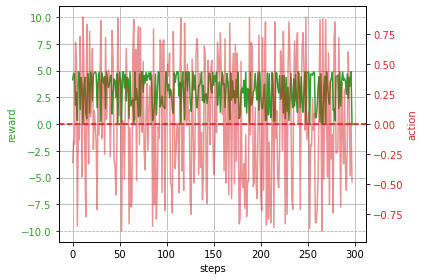

In [277]:
r="[[4.1858363, 0.07449748, 3.8931775, 4.8992386, 4.567902, 0.07449748, 4.8513403, 4.1402407, 4.729629, 0.5093467, 2.4, 4.467727, 4.8878202, 1.6918397, 1.6101007, 2.4, 3.9957602, 4.8513403, 4.230127, 3.373292, 1.3618585, 1.4450849, 3.496699, 2.4751904, 4.467727, 3.8931775, 2.909075, 4.045188, 2.0130913, 4.6552825, 4.7063084, 4.567902, 4.093353, 2.5495963, 4.230127, 4.681524, 4.045188, 4.6552825, 1.8536557, 3.5567684, 4.2730985, 2.1699524, 4.9, 4.431539, 4.8513403, 4.896954, 4.6552825, 2.909075, 4.8931475, 4.77185, 0.24878237, 4.045188, 4.862731, 2.1699524, 4.598463, 0.24878237, 1.8536557, 1.1096095, 1.8536557, 4.8931475, 4.8726096, 4.045188, 2.0130913, 4.862731, 4.862731, 4.7514787, 4.8992386, 1.9336832, 4.1858363, 2.9783075, 4.8931475, 0.93955845, 1.0247552, 4.808136, 3.496699, 0.93955845, 1.5278407, 4.77185, 1.3618585, 4.681524, 0.24878237, 3.113938, 1.4450849, 4.431539, 4.896954, 1.2781868, 2.4751904, 0.24878237, 3.496699, 3.435534, 1.4450849, 2.4, 4.8513403, 1.5051084], [4.896954, 4.627593, 3.8931775, 3.373292, 0.42264232, 1.1096095, 4.896954, 4.535919, 4.7063084, 4.314738, 4.9, 3.78573, 0.3357787, 0.93955845, 2.6959646, 0.5958655, 4.6552825, 0.42264232, 3.046602, 2.909075, 1.1940953, 4.093353, 3.435534, 4.8992386, -0.012737968, 4.431539, 3.113938, 4.230127, 4.838442, 4.2730985, 4.790738, 2.4751904, 2.6231952, 4.8992386, 3.3099918, 0.6821723, 4.838442, 1.6918397, 4.467727, 1.4450849, 4.8878202, 4.808136, 4.824039, 2.0918558, 2.2473578, 2.767882, 1.9336832, 4.8931475, 4.535919, 4.824039, 4.838442, 4.6552825, 4.790738, 4.9, 3.3099918, 4.230127, 0.07449748, 3.615724, 4.467727, 3.3099918, 4.8726096, 4.535919, 4.8992386, 1.4450849, 4.8878202, 4.5025244, 2.4751904, 4.8931475, 4.1858363, 4.627593, 0.6821723, 3.78573, 0.6821723, 4.535919, 4.824039, -1.0092852], [3.7302222, 3.7302222, 0.16167977, 1.9336832, 1.0247552, 2.324048, 2.6959646, 4.467727, 4.838442, 3.245653, 0.5093467, 3.5567684, 4.8809733, 3.496699, 2.909075, 4.8878202, 4.598463, 4.896954, 2.767882, 1.2781868, 4.314738, 4.7514787, 4.431539, 2.9783075, 4.093353, 1.5278407, 3.78573, 4.8726096, 0.07449748, 0.24878237, 4.2730985, 2.2473578, 4.77185, 3.046602, 4.567902, 0.3357787, 4.8931475, 4.598463, 4.535919, 4.3550324, 3.9957602, 3.945085, 3.5567684, 4.1402407, 0.854045, 4.808136, 1.5278407, 4.431539, 2.0130913, 0.3357787, 4.8992386, 4.790738, 1.3618585, 2.909075, 1.8536557, 1.1940953, 3.113938, 2.6231952, -0.012737968, 3.373292, 3.8931775, 3.5567684, 4.8878202, 3.5567684, 3.245653, 0.07449748, 4.39397, 3.8931775, 4.8931475, 4.535919, 4.314738, 3.615724, 4.3550324, 4.9, 3.8931775, 2.6959646, 1.1096095, 3.673548, 0.76824087, 2.324048, 0.76824087, 0.93955845, 1.6101007, 3.1802952, 4.3550324, -0.012737968, 4.7063084, 3.435534, 4.230127, 3.8400538, 1.1096095, 4.8726096, 2.0130913, 3.8400538, 0.42264232, 3.78573, 3.373292, 4.862731, 4.862731, 4.230127, 3.9957602, 4.7063084, 1.2781868, 4.8809733, 3.113938, 1.1096095, 4.808136, 4.7063084, 4.862731, 2.4751904, 3.615724, 4.8513403, 0.16336566], [2.2473578, 3.9957602, 0.93955845, 4.862731, 2.4, 1.1096095, 3.7302222, 3.245653, 3.673548, 4.431539, 1.3618585, 1.1940953, 4.7063084, 4.314738, 0.16167977, 4.535919, 4.1402407, 4.838442, 3.673548, 4.535919, 3.1802952, 2.6959646, 4.627593, 2.767882, 4.627593, 1.773033, 4.535919, 3.496699, 2.6231952, 2.6959646, 3.1802952, 4.8931475, 4.8931475, 4.6552825, 4.8809733, 0.16167977, 4.8878202, 1.5278407, 3.245653, 1.8536557, 3.945085, 4.598463, 3.7302222, 4.8726096, 3.245653, 2.767882, 4.824039, 4.838442, 4.8878202, 2.9783075, 1.6918397, 4.1402407, 4.467727, 4.314738, 4.838442, 0.3357787, 4.729629, 1.1096095, 1.3618585, 4.093353, 4.8809733, 4.230127, 4.838442, 0.16167977, 1.4450849, 4.045188, 2.4, 4.77185, 2.2473578, 4.8513403, 4.39397, 3.7302222, 1.3618585, 1.6101007, 4.2730985, 1.6101007, 3.945085, 3.9957602, 2.767882, 2.4, 4.467727, 4.093353, 0.42264232, 4.6552825, 4.8931475, 0.07449748, 3.1802952, 2.1699524, 1.9336832, 0.5067204], [4.7514787, 4.8726096, 2.4751904, 4.790738, 0.6821723, 0.6821723, 0.42264232, 4.790738, 2.4, 4.230127, 1.2781868, 2.324048, 4.2730985, 2.767882, 2.767882, 2.2473578, 4.230127, 4.535919, 3.5567684, 0.24878237, 2.6231952, 3.8931775, 2.1699524, 3.615724, 1.5278407, 3.496699, 1.1096095, 4.1858363, 3.8931775, 4.535919, 3.496699, 4.1858363, 4.862731, 1.8536557, 4.5025244, 1.0247552, 4.8726096, 4.681524, 2.0130913, 1.1096095, 4.7063084, 0.5958655, 2.8389263, 4.862731, 4.8726096, 4.8513403, 3.8400538, 1.4450849, 1.6101007, 4.77185, 0.76824087, 2.0130913, 0.07449748, 3.7302222, 4.6552825, 3.373292, 3.245653, 3.046602, 2.909075, 0.76824087, 0.42264232, 4.598463, 4.681524, 2.324048, 4.230127, 2.0130913, 3.046602, 4.862731, 4.8931475, 1.8536557, 4.896954, 1.4450849, 4.2730985, 4.862731, 0.5093467, 3.435534, 1.5278407, 1.2781868, 1.6918397, 4.9, 2.9783075, 4.896954, 1.9336832, 3.673548, 4.39397, 2.0918558, 0.16167977, 0.5093467, 4.8726096, 3.245653, 0.76824087, 2.4751904, 4.467727, 4.824039, 4.093353, 4.5025244, 3.496699, 1.2781868, 4.9, 4.729629, 3.615724, 3.673548, 3.945085, 4.535919, 1.0247552, 1.5278407, 3.245653, 3.245653, 3.046602, 1.9336832, 3.7302222, 4.838442, 4.598463, 3.113938, 2.767882, 4.567902, 4.431539, 2.909075, 3.945085, 3.373292, 3.3099918, 2.9783075, 4.431539, 0.76824087, 4.1402407, 3.7302222, 4.7514787, 3.78573, 0.5093467, 1.6101007, 4.6552825, 0.6821723, 2.6231952, 3.673548, 0.42264232, 4.567902, 2.9783075, 4.8513403, 3.945085, 4.627593, 0.5958655, 4.093353, 4.808136, -0.012737968, 4.2730985, 4.6552825, -0.012737968, 2.5495963, 1.3618585, 3.945085, 3.7302222, 4.627593, 0.42264232, 1.1096095, 2.6231952, 1.8536557, 3.78573, 4.598463, 1.4450849, 4.093353, 4.2730985, 4.8809733, 4.8513403, 4.838442, -1.7232326], [1.5278407, 4.808136, 0.3357787, 4.838442, 4.790738, 1.773033, 4.3550324, 0.42264232, 3.046602, 2.2473578, 3.046602, 4.790738, 2.6231952, 0.76824087, 4.896954, 4.467727, 0.24878237, 2.767882, 0.5958655, 3.78573, 3.245653, 1.0247552, 1.773033, 2.8389263, 1.6101007, 1.8536557, 0.07449748, 4.77185, 2.767882, 4.838442, 4.790738, 4.9, 3.5567684, 4.627593, 3.5567684, 1.1940953, 4.39397, 4.824039, 3.615724, 0.07449748, 4.314738, 0.24878237, 3.245653, 0.93955845, 3.3099918, 0.16167977, 3.3099918, 3.3099918, 1.2781868, 4.8992386, 1.5278407, 4.7514787, 2.6231952, 3.945085, 0.76824087, 0.3357787, 2.0918558, 4.9, 4.8513403, 3.7302222, 0.5093467, 4.808136, 4.8878202, 3.9957602, 4.8726096, 2.9783075, 3.496699, 4.77185, 4.808136, 3.113938, 4.535919, 4.230127, 3.9957602, 2.909075, 2.8389263, 1.5278407, 1.1940953, 0.16167977, 2.4, 4.1402407, 0.5093467, 2.9783075, 3.9957602, -1.320242], [2.6231952, 4.7514787, 4.681524, 4.5025244, 3.9957602, 4.838442, 3.78573, 4.790738, 4.862731, 0.854045, 4.230127, 3.435534, 4.8513403, 4.5025244, 4.5025244, 4.1402407, 3.1802952, 4.862731, 0.76824087, 3.1802952, 1.0247552, 4.431539, 4.824039, 3.673548, 4.627593, 4.230127, 4.8513403, 0.93955845, 1.2781868, 3.046602, 2.6231952, 4.8726096, 4.8992386, 2.6959646, 1.5278407, 4.790738, 0.42264232, 4.598463, 4.9, 4.8931475, 2.0130913, 4.8992386, 4.230127, 3.245653, 1.4450849, 1.6101007, 4.8809733, 4.9, 2.9783075, 3.5567684, 3.78573, 4.9, 4.1402407, 4.8513403, 4.862731, 0.42264232, 4.39397, 2.1699524, -3.3460712], [1.8536557, 3.5567684, 1.6101007, 4.7063084, 4.862731, 0.5093467, 4.1402407, 4.8878202, 2.5495963, 3.615724, 3.5567684, 3.245653, 4.1402407, 0.42264232, 3.5567684, 2.4, 1.6918397, 4.467727, 3.7302222, 4.39397, 4.6552825, 2.2473578, 0.93955845, 4.8931475, 4.467727, 1.4450849, 3.113938, 1.6101007, 0.5958655, 3.9957602, 3.5567684, 2.909075, 4.808136, 2.909075, 4.1858363, 3.945085, 3.245653, 3.8400538, 4.3550324, 4.535919, 0.76824087, 3.496699, 0.24878237, 4.896954, 3.435534, 4.790738, 1.1940953, 1.0247552, 3.373292, 1.6101007, 3.673548, 2.6231952, 4.467727, 4.8513403, 4.1402407, 3.1802952, 1.773033, 1.2781868, 4.6552825, 3.435534, 2.767882, 0.93955845, 4.627593, 4.045188, 0.42264232, 0.5958655, 4.729629, 3.496699, 3.3099918, 0.07449748, 1.773033, 3.3099918, 0.6821723, 4.1402407, 1.1096095, 3.5567684, 4.7063084, -0.012737968, 3.046602, 2.1699524, 0.76824087, 3.673548, 2.324048, 1.0247552, 4.8809733, 4.314738, 4.598463, 0.42264232, 2.909075, 0.16167977, 3.5567684, 1.1940953, 4.824039, 2.4, 2.767882, 2.8389263, 4.627593, 4.790738, 3.7302222, 4.8878202, 3.1802952, 3.7302222, 4.8931475, 2.6959646, 4.6552825, 2.4, 4.7063084, 0.93955845, 4.7514787, 3.7302222, 1.6918397, 4.467727, 3.7302222, 4.39397, 4.8726096, 4.627593, 1.6101007, 3.945085, 3.9957602, -3.2588358], [4.1402407, 4.7514787, 4.681524, 1.773033, 2.9783075, 0.3357787, 4.896954, 4.77185, 1.3618585, 4.3550324, 3.496699, -0.012737968, 3.496699, 4.39397, 1.0247552, 0.5093467, 4.729629, 4.093353, 1.0247552, 4.8726096, 4.467727, 2.1699524, 4.567902, 4.808136, 4.8992386, 4.7063084, 1.5278407, 3.9957602, 4.838442, 3.9957602, 0.24878237, 4.790738, 4.1858363, 3.78573, 4.431539, 1.4450849, 4.8878202, 4.1858363, 3.435534, 3.673548, 4.3550324, 4.567902, 0.93955845, 2.909075, 4.230127, 4.045188, 2.4751904, 4.729629, 0.07449748, 3.8931775, 4.862731, 3.8400538, -0.012737968, 4.8931475, 4.9, 3.373292, 4.627593, 2.1699524, 4.3550324, 4.230127, 0.5093467, 4.8931475, 1.6918397, 2.0130913, 2.324048, 0.16167977, 4.8878202, 2.2473578, 3.3099918, 2.0918558, 0.6821723, 4.681524, 0.76824087, 4.8992386, 4.862731, 2.9783075, 4.535919, 3.8400538, 4.838442, 4.045188, 4.535919, 4.790738, 4.1402407, 4.8992386, 3.673548, 0.3357787, 0.854045, 1.8536557, 4.681524, 0.854045, 2.9783075, 4.896954, 4.790738, 1.6101007, 1.9336832, 2.6231952, 1.6918397, 1.6101007, 1.4450849, 4.9, 4.3550324, 3.113938, 3.7302222, 2.4751904, 3.245653, 2.9783075, 1.2781868, 1.0247552, 4.790738, 3.8931775, 4.567902, 4.8992386, 4.8931475, 2.6231952, 3.8931775, 0.07449748, 3.78573, 4.896954, 2.767882, 0.42264232, 4.729629, 4.8992386, 3.113938, 4.8931475, 4.790738, 2.0130913, 1.1940953, 2.8389263, 4.8992386, 3.1802952, 4.567902, 2.8389263, 1.5278407, 2.2473578, 3.615724, 3.615724, 3.945085, 4.862731, 2.1699524, 3.615724, 2.0130913, 2.6231952, 2.8389263, 1.9336832, 2.909075, 4.77185, 4.681524, 3.3099918, 2.909075, 4.8513403, 3.615724, 4.535919, 3.9957602, 4.862731, 1.773033, 2.9783075, 3.945085, 1.1096095, 3.673548, 4.8513403, 3.673548, 3.78573, 1.5278407, 3.1802952, 4.729629, 3.9957602, 2.4751904, 0.42264232, 4.790738, 2.2473578, 4.045188, 2.4751904, 3.113938, 1.9336832, 4.1858363, 2.4751904, 4.838442, 0.5093467, 0.854045, 2.9783075, 3.373292, 2.909075, 4.093353, 1.6101007, 4.838442, 1.0247552, 3.3099918, 3.245653, 0.07449748, 4.838442, 1.773033, 2.0918558, 2.9783075, 3.1802952, 4.7514787, 3.245653, 2.2473578, 4.8513403, 1.2781868, 4.824039, 2.4751904, 1.4450849, 1.4450849, 2.767882, 3.7302222, 0.3357787, 0.42264232, 4.77185, 0.854045, 4.729629, 1.0247552, 0.5958655, 4.808136, 3.615724, 0.24878237, 0.3357787, 4.790738, 4.808136, 3.496699, 2.909075, 4.535919, 2.324048, 2.6231952, 4.535919, 1.0247552, 4.535919, 0.5093467, 4.3550324, 1.1940953, 3.435534, 0.3357787, 2.6959646, 4.7514787, 2.4, 1.5278407, 4.230127, 1.6918397, 4.627593, 2.4, 1.1096095, 4.9, 3.615724, 1.5278407, 4.431539, 2.1699524, 1.1096095, 3.615724, 4.8809733, -0.012737968, 4.77185, 4.896954, 4.824039, 0.16167977, 4.681524, 4.6552825, 4.567902, 4.8809733, 4.838442, 0.5958655, 0.5958655, 1.6918397, 3.615724, 4.431539, 0.16167977, 4.7063084, -0.012737968, 0.07449748, 3.373292, 4.467727, 0.16167977, 4.8992386, 3.496699, 2.4751904, 1.8536557, 3.9957602, 4.2730985, 4.838442, 1.2781868, 1.4450849, 0.3357787, 4.467727, 4.467727, 4.567902, 1.4450849, 4.8931475, 1.6918397, 3.9957602, 4.8726096, 4.093353, 4.2730985, 3.9957602, 2.767882, 4.681524, 2.4, 4.39397, 3.5567684, 4.8992386, -0.0876803], [3.046602, 1.8536557, 3.78573, 4.1858363, 3.8931775, -0.012737968, 4.838442, 0.93955845, 4.896954, 2.6959646, 2.6959646, 4.790738, 4.627593, 1.8536557, 0.16167977, 1.4450849, 4.808136, 4.8513403, 0.16167977, 4.230127, 1.0247552, 3.8400538, 1.6918397, 2.4751904, 4.8809733, 4.045188, 4.467727, 2.0130913, 3.673548, 4.567902, 3.7302222, 3.8400538, 4.8931475, 3.046602, 4.093353, 3.113938, 4.5025244, 3.945085, 4.838442, 3.9957602, 0.42264232, 4.896954, 4.39397, 0.5958655, 4.77185, 1.8536557, 2.5495963, 3.1802952, 4.093353, 2.4, 2.4751904, 0.5093467, 3.615724, 4.824039, 3.945085, 0.5958655, 4.39397, 3.615724, 0.5093467, 4.598463, 1.773033, 1.2781868, 2.8389263, 2.8389263, 4.862731, 3.8400538, 4.535919, 4.598463, 4.9, 4.896954, 4.431539, 2.2473578, 4.39397, 4.1858363, 1.3618585, 4.567902, 2.9783075, 4.5025244, 4.8513403, 4.39397, 3.3099918, 2.6231952, 1.6918397, 3.496699, 4.314738, 3.046602, 4.896954, 2.1699524, 4.729629, 0.6821723, 0.07449748, -0.012737968, 0.6821723, 0.3357787, 4.567902, 2.767882, 1.773033, 4.535919, 4.681524, 3.496699, 4.314738, 3.113938, 2.1699524, 2.8389263, 2.909075, 2.2473578, 4.598463, 2.0918558, 0.76824087, 3.496699, 0.5958655, 2.4, 4.567902, 3.3099918, 1.5278407, 2.1699524, 2.8389263, 2.909075, 4.7063084, 4.314738, 3.496699, 4.567902, 3.78573, 0.42264232, 3.113938, 1.2781868, 4.77185, 4.2730985, 4.467727, 4.7514787, 4.8726096, 3.496699, 1.1940953, 4.8992386, 1.1096095, 2.1699524, 0.6821723, 4.824039, 3.615724, 4.862731, 4.627593, 2.6231952, 0.24878237, 4.896954, 4.535919, 4.5025244, 3.046602, 1.1096095, 4.467727, 1.5278407, 2.6231952, 1.5278407, 4.535919, 3.673548, 4.431539, 3.3099918, 4.7063084, 4.896954, 3.3099918, 3.78573, 3.435534, 2.6959646, 4.598463, 4.431539, 4.093353, 4.230127, 0.42264232, 0.93955845, -1.7232326]]"
a="[[0.31, 0.88, 0.37, -0.01, 0.21, 0.88, -0.08, 0.32, 0.15, -0.83, -0.6, 0.24, 0.04, -0.69, -0.7, 0.6, 0.35, 0.08, 0.3, 0.46, -0.73, 0.72, 0.44, 0.59, 0.24, -0.37, 0.53, 0.34, 0.65, -0.18, -0.16, -0.21, -0.33, -0.58, 0.3, 0.17, -0.34, -0.18, 0.67, 0.43, 0.29, -0.63, 0.0, 0.25, 0.08, 0.02, -0.18, -0.53, -0.03, 0.13, 0.86, 0.34, 0.07, 0.63, -0.2, 0.86, -0.67, 0.76, 0.67, 0.03, -0.06, -0.34, -0.65, 0.07, -0.07, 0.14, -0.01, -0.66, -0.31, -0.52, -0.03, -0.78, -0.77, -0.11, 0.44, 0.78, 0.71, 0.13, 0.73, 0.17, -0.86, -0.5, -0.72, -0.25, 0.02, 0.74, 0.59, -0.86, 0.44, -0.45, -0.72, 0.6, -0.08, 0.09], [0.02, 0.19, 0.37, -0.46, -0.84, 0.76, -0.02, -0.22, 0.16, 0.28, 0.0, -0.39, -0.85, 0.78, 0.56, -0.82, 0.18, -0.84, 0.51, 0.53, 0.75, -0.33, 0.45, -0.01, 0.89, -0.25, 0.5, -0.3, -0.09, -0.29, 0.12, -0.59, 0.57, 0.01, 0.47, -0.81, 0.09, -0.69, 0.24, -0.72, 0.04, 0.11, -0.1, 0.64, -0.62, 0.55, 0.66, -0.03, 0.22, -0.1, 0.09, -0.18, -0.12, 0.0, -0.47, -0.3, -0.88, 0.42, 0.24, 0.47, 0.06, 0.22, 0.01, 0.72, 0.04, 0.23, 0.59, -0.03, -0.31, -0.19, 0.81, 0.39, -0.81, 0.22, 0.1, -0.61], [-0.4, 0.4, -0.87, 0.66, 0.77, -0.61, -0.56, 0.24, -0.09, 0.48, 0.83, -0.43, 0.05, 0.44, -0.53, -0.04, -0.2, -0.02, -0.55, 0.74, -0.28, -0.14, 0.25, -0.52, 0.33, 0.71, -0.39, -0.06, 0.88, -0.86, 0.29, 0.62, -0.13, 0.51, -0.21, -0.85, -0.03, -0.2, 0.22, 0.27, 0.35, 0.36, -0.43, -0.32, 0.79, -0.11, -0.71, -0.25, -0.65, 0.85, 0.01, 0.12, -0.73, -0.53, -0.67, -0.75, 0.5, -0.57, 0.89, 0.46, -0.37, -0.43, -0.04, -0.43, -0.48, -0.88, 0.26, -0.37, 0.03, 0.22, 0.28, -0.42, 0.27, 0.0, 0.37, 0.56, 0.76, -0.41, -0.8, -0.61, 0.8, 0.78, -0.7, 0.49, 0.27, -0.89, 0.16, 0.45, -0.3, 0.38, -0.76, -0.06, -0.65, 0.38, 0.84, 0.39, -0.46, 0.07, 0.07, 0.3, -0.35, 0.16, 0.74, -0.05, 0.5, 0.76, -0.11, -0.16, -0.07, -0.59, 0.42, 0.08, 0.44], [-0.62, -0.35, -0.78, -0.07, 0.6, 0.76, 0.4, 0.48, -0.41, 0.25, -0.73, -0.75, 0.16, -0.28, 0.87, 0.22, 0.32, 0.09, -0.41, -0.22, -0.49, -0.56, -0.19, -0.55, 0.19, 0.68, 0.22, -0.44, -0.57, 0.56, -0.49, 0.03, 0.03, 0.18, 0.05, -0.87, 0.04, 0.71, 0.48, -0.67, -0.36, 0.2, 0.4, -0.06, 0.48, -0.55, 0.1, 0.09, -0.04, 0.52, -0.69, 0.32, -0.24, -0.28, -0.09, -0.85, -0.15, 0.76, -0.73, -0.33, 0.05, -0.3, -0.09, -0.87, -0.72, 0.34, 0.6, -0.13, 0.62, 0.08, -0.26, 0.4, -0.73, 0.7, -0.29, 0.7, -0.36, -0.35, 0.55, 0.6, 0.24, -0.33, -0.84, -0.18, 0.03, -0.88, 0.49, 0.63, -0.66, -0.38], [-0.14, 0.06, 0.59, 0.12, 0.81, 0.81, 0.84, 0.12, 0.6, 0.3, 0.74, -0.61, -0.29, -0.55, 0.55, 0.62, -0.3, 0.22, -0.43, 0.86, 0.57, -0.37, -0.63, 0.42, 0.71, 0.44, -0.76, 0.31, -0.37, 0.22, 0.44, 0.31, -0.07, -0.67, -0.23, -0.77, -0.06, 0.17, 0.65, 0.76, 0.16, 0.82, 0.54, -0.07, 0.06, -0.08, 0.38, 0.72, -0.7, 0.13, 0.8, 0.65, -0.88, 0.4, -0.18, 0.46, -0.48, 0.51, 0.53, -0.8, 0.84, -0.2, -0.17, 0.61, 0.3, -0.65, 0.51, 0.07, 0.03, -0.67, 0.02, -0.72, -0.29, 0.07, 0.83, -0.45, 0.71, 0.74, -0.69, 0.0, 0.52, -0.02, -0.66, -0.41, 0.26, -0.64, -0.87, 0.83, -0.06, -0.48, -0.8, -0.59, 0.24, 0.1, 0.33, 0.23, -0.44, -0.74, 0.0, 0.15, 0.42, 0.41, 0.36, 0.22, 0.77, -0.71, 0.48, -0.48, 0.51, -0.66, -0.4, -0.09, 0.2, -0.5, 0.55, 0.21, 0.25, 0.53, 0.36, -0.46, -0.47, -0.52, -0.25, -0.8, 0.32, -0.4, -0.14, 0.39, -0.83, -0.7, 0.18, 0.81, -0.57, 0.41, 0.84, -0.21, -0.52, 0.08, 0.36, -0.19, 0.82, 0.33, -0.11, -0.89, -0.29, -0.18, -0.89, -0.58, 0.73, -0.36, -0.4, -0.19, 0.84, 0.76, -0.57, 0.67, 0.39, -0.2, 0.72, 0.33, -0.29, 0.05, 0.08, -0.09, 0.7], [0.71, 0.11, 0.85, -0.09, 0.12, 0.68, -0.27, 0.84, -0.51, 0.62, 0.51, 0.12, -0.57, -0.8, 0.02, -0.24, -0.86, 0.55, 0.82, 0.39, 0.48, -0.77, -0.68, 0.54, -0.7, 0.67, -0.88, 0.13, -0.55, 0.09, -0.12, 0.0, -0.43, 0.19, 0.43, 0.75, -0.26, -0.1, -0.42, -0.88, -0.28, -0.86, -0.48, -0.78, 0.47, -0.87, 0.47, -0.47, 0.74, -0.01, -0.71, 0.14, -0.57, 0.36, 0.8, 0.85, 0.64, 0.0, -0.08, 0.4, 0.83, -0.11, 0.04, 0.35, -0.06, 0.52, -0.44, -0.13, 0.11, 0.5, -0.22, -0.3, -0.35, 0.53, 0.54, 0.71, 0.75, 0.87, -0.6, -0.32, -0.83, 0.52, -0.35, -0.65], [-0.57, 0.14, 0.17, -0.23, -0.35, 0.09, 0.39, -0.12, -0.07, -0.79, -0.3, -0.45, -0.08, 0.23, -0.23, -0.32, -0.49, 0.07, -0.8, 0.49, -0.77, 0.25, -0.1, 0.41, -0.19, 0.3, 0.08, 0.78, -0.74, -0.51, 0.57, 0.06, -0.01, 0.56, -0.71, 0.12, 0.84, 0.2, 0.0, -0.03, 0.65, -0.01, -0.3, 0.48, 0.72, 0.7, -0.05, 0.0, 0.52, 0.43, 0.39, 0.0, -0.32, -0.08, -0.07, -0.84, -0.26, -0.63, -0.89], [-0.67, 0.43, 0.7, 0.16, -0.07, -0.83, 0.32, -0.04, -0.58, -0.42, 0.43, -0.48, 0.32, -0.84, -0.43, -0.6, 0.69, 0.24, 0.4, -0.26, -0.18, 0.62, 0.78, -0.03, 0.24, 0.72, 0.5, 0.7, -0.82, 0.35, 0.43, 0.53, -0.11, -0.53, 0.31, 0.36, -0.48, -0.38, 0.27, 0.22, -0.8, 0.44, 0.86, 0.02, -0.45, 0.12, -0.75, 0.77, 0.46, 0.7, -0.41, 0.57, -0.24, 0.08, -0.32, -0.49, 0.68, -0.74, -0.18, 0.45, 0.55, -0.78, 0.19, -0.34, -0.84, 0.82, -0.15, 0.44, -0.47, 0.88, -0.68, -0.47, -0.81, -0.32, 0.76, -0.43, 0.16, 0.89, -0.51, 0.63, 0.8, 0.41, 0.61, 0.77, 0.05, 0.28, 0.2, 0.84, 0.53, -0.87, 0.43, -0.75, -0.1, 0.6, 0.55, -0.54, -0.19, -0.12, 0.4, 0.04, 0.49, -0.4, -0.03, 0.56, 0.18, 0.6, -0.16, 0.78, -0.14, 0.4, -0.69, -0.24, -0.4, -0.26, -0.06, -0.19, -0.7, 0.36, -0.35, -0.88], [-0.32, -0.14, -0.17, 0.68, 0.52, -0.85, -0.02, -0.13, 0.73, 0.27, -0.44, 0.89, 0.44, -0.26, -0.77, 0.83, 0.15, -0.33, 0.77, 0.06, 0.24, 0.63, -0.21, 0.11, -0.01, -0.16, -0.71, 0.35, -0.09, 0.35, 0.86, -0.12, 0.31, 0.39, -0.25, 0.72, 0.04, 0.31, 0.45, 0.41, -0.27, 0.21, 0.78, 0.53, -0.3, -0.34, -0.59, -0.15, 0.88, 0.37, 0.07, 0.38, -0.89, 0.03, 0.0, -0.46, 0.19, 0.63, 0.27, 0.3, -0.83, -0.03, -0.69, -0.65, 0.61, 0.87, 0.04, 0.62, -0.47, 0.64, 0.81, -0.17, 0.8, 0.01, -0.07, 0.52, -0.22, -0.38, 0.09, 0.34, -0.22, 0.12, 0.32, 0.01, 0.41, -0.85, 0.79, -0.67, 0.17, -0.79, -0.52, -0.02, -0.12, 0.7, 0.66, -0.57, 0.69, 0.7, -0.72, 0.0, 0.27, 0.5, 0.4, 0.59, -0.48, -0.52, -0.74, 0.77, 0.12, -0.37, -0.21, 0.01, -0.03, -0.57, 0.37, 0.88, -0.39, -0.02, -0.55, 0.84, 0.15, -0.01, 0.5, 0.03, 0.12, -0.65, -0.75, 0.54, 0.01, -0.49, -0.21, 0.54, 0.71, 0.62, -0.42, 0.42, -0.36, -0.07, -0.63, -0.42, 0.65, 0.57, -0.54, -0.66, 0.53, 0.13, -0.17, 0.47, 0.53, -0.08, -0.42, -0.22, 0.35, -0.07, 0.68, 0.52, 0.36, 0.76, 0.41, 0.08, 0.41, -0.39, 0.71, -0.49, -0.15, 0.35, -0.59, 0.84, 0.12, -0.62, 0.34, 0.59, -0.5, 0.66, -0.31, 0.59, 0.09, -0.83, -0.79, 0.52, -0.46, -0.53, -0.33, -0.7, -0.09, -0.77, -0.47, -0.48, 0.88, -0.09, 0.68, 0.64, -0.52, -0.49, 0.14, -0.48, -0.62, -0.08, 0.74, -0.1, -0.59, -0.72, 0.72, -0.55, 0.4, 0.85, -0.84, 0.13, -0.79, -0.15, -0.77, -0.82, 0.11, 0.42, -0.86, 0.85, -0.12, 0.11, -0.44, -0.53, -0.22, 0.61, 0.57, -0.22, 0.77, 0.22, -0.83, 0.27, -0.75, 0.45, 0.85, 0.56, 0.14, -0.6, -0.71, 0.3, 0.69, 0.19, 0.6, 0.76, 0.0, 0.42, -0.71, 0.25, 0.63, 0.76, 0.42, -0.05, 0.89, -0.13, -0.02, 0.1, -0.87, -0.17, -0.18, 0.21, -0.05, 0.09, -0.82, -0.82, -0.69, -0.42, 0.25, 0.87, 0.16, -0.89, 0.88, -0.46, 0.24, 0.87, -0.01, -0.44, 0.59, -0.67, 0.35, -0.29, -0.09, -0.74, 0.72, 0.85, -0.24, -0.24, -0.21, 0.72, -0.03, -0.69, 0.35, -0.06, -0.33, 0.29, -0.35, -0.55, -0.17, 0.6, 0.26, -0.43, 0.01, -0.48], [-0.51, -0.67, -0.39, 0.31, 0.37, -0.89, 0.09, 0.78, -0.02, 0.56, -0.56, 0.12, -0.19, -0.67, -0.87, -0.72, -0.11, -0.08, -0.87, -0.3, 0.77, 0.38, 0.69, -0.59, -0.05, -0.34, 0.24, -0.65, -0.41, 0.21, 0.4, -0.38, 0.03, -0.51, -0.33, 0.5, -0.23, 0.36, 0.09, -0.35, 0.84, 0.02, 0.26, -0.82, 0.13, -0.67, -0.58, -0.49, 0.33, 0.6, -0.59, -0.83, 0.42, 0.1, 0.36, -0.82, -0.26, 0.42, 0.83, 0.2, 0.68, 0.74, -0.54, 0.54, -0.07, 0.38, -0.22, -0.2, 0.0, -0.02, 0.25, -0.62, 0.26, 0.31, 0.73, -0.21, -0.52, -0.23, -0.08, 0.26, 0.47, 0.57, -0.69, 0.44, 0.28, -0.51, -0.02, 0.63, 0.15, 0.81, 0.88, -0.89, -0.81, 0.85, -0.21, 0.55, -0.68, -0.22, -0.17, 0.44, 0.28, 0.5, 0.63, 0.54, 0.53, -0.62, 0.2, -0.64, 0.8, -0.44, -0.82, -0.6, 0.21, -0.47, 0.71, 0.63, -0.54, -0.53, -0.16, -0.28, 0.44, 0.21, 0.39, -0.84, 0.5, 0.74, -0.13, 0.29, 0.24, 0.14, -0.06, -0.44, 0.75, -0.01, 0.76, -0.63, 0.81, 0.1, 0.42, -0.07, 0.19, 0.57, -0.86, -0.02, -0.22, 0.23, 0.51, -0.76, 0.24, 0.71, 0.57, -0.71, -0.22, -0.41, 0.25, -0.47, -0.16, 0.02, -0.47, -0.39, -0.45, 0.56, 0.2, 0.25, 0.33, -0.3, -0.84, -0.78, -0.7]]"
combine_reward_actions(json.loads(r),json.loads(a), 8)

In [302]:
def combine_all_rewards(min_random, min_agent, max_random, max_agent, flex_random, flex_agent):
    _x = list(range(len(min_agent)))
    
    plt.plot(_x, min_agent, color="green", label="min")
    plt.plot(_x, max_agent, color="red", label="max")
    plt.plot(_x, flex_agent, color="blue", label="dynamic")
    plt.plot(_x, min_random, color="green", alpha=0.5)
    plt.plot(_x, max_random, color="red", alpha=0.5)
    plt.plot(_x, flex_random, color="blue", alpha=0.5)
    plt.grid()
    _x_ticks = list(range(len(min_agent)))
    

    plt.legend(loc="best")
    plt.title("reward vs random")
    plt.autoscale()
    plt.savefig("reward_vs_random.png", dpi=300, facecolor='white', edgecolor='none')
    
    plt.show()

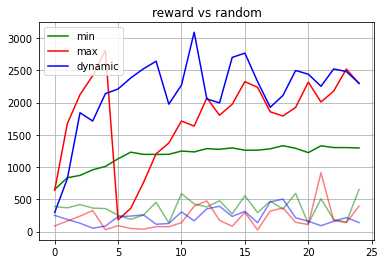

In [303]:
combine_all_rewards([387.53183121809735, 369.0546307213046, 419.97161183832213, 365.0227699415758, 357.2157750818133, 253.8447571536526, 189.91867922153324, 256.74319618940353, 455.1055098287761, 137.00418516993523, 588.6247171638533, 429.04858030285686, 382.7959244772792, 479.42577812075615, 275.2000017538667, 556.0335351526737, 295.0714951585978, 473.24968304205686, 349.7510228669271, 592.9961249670014, 121.92456336971372, 509.8913962673396, 187.5794378137216, 147.13279839605093, 652.87156794779], [653.5587003251354, 835.2106711271167, 871.1631001254927, 957.8513832977958, 1010.5715367024591, 1128.3313111111381, 1231.0547533334257, 1197.287418524262, 1196.2156719213851, 1198.0187150416473, 1248.469982388094, 1235.5090944438248, 1285.9725059128511, 1275.7262517584008, 1297.4635793962943, 1261.8191411481891, 1261.8091162228468, 1283.264681830317, 1331.5641641534469, 1290.8376371342817, 1224.2956087876391, 1330.277846828422, 1302.6489216798366, 1302.65572075119, 1295.5714296243088],[88.40034627914429, 165.05062294006348, 240.0919425189495, 327.3944892883301, 29.850929737091064, 93.6849889755249, 48.41732954978943, 38.05999183654785, 77.25246620178223, 75.76356434822083, 138.33229637145996, 394.8161985576153, 476.7752866744995, 174.66918349266052, 84.20952486991882, 298.2637987136841, 26.554025650024414, 319.1707606315613, 367.3673973083496, 145.02598091959953, 109.93976211547852, 913.6672463417053, 173.52477502822876, 138.33229637145996, 394.8161985576153],[640.1509436837956, 1673.4126919614896, 2124.160027521402, 2416.8865383479, 2808.470640042722, 182.5345413428545, 361.9308745527267, 758.9868472540379, 1206.3652229375439, 1372.6889625751971, 1713.875323394984, 1635.1920674668997, 2071.8431109685826, 1803.8677097156924, 1974.27005942747, 2323.6141014891864, 2236.892961839512, 1856.5385917473957, 1792.3554498348944, 1924.7704312800058, 2317.5444924946314, 2008.21052684851, 2177.4040228897334, 2519.0634839622676, 2293.8909904952466],[252.238451205194, 187.46073246002197, 130.84124267101288, 52.85301089286804, 85.76703929901123, 233.3990587592125, 241.14967489242554, 259.9193646386266, 114.73682065308094, 125.59459738433361, 305.6821970641613, 167.72240640968084, 353.45301412791014, 393.51547162234783, 234.8997197598219, 314.08924739062786, 138.11057937145233, 461.01618755608797, 503.4567517861724, 214.6234324425459, 161.2894994840026, 91.94910755008459, 160.01263075321913, 218.46698139049113, 140.05976647883654],[296.54570193861844, 819.8355517779803, 1842.0586117967964, 1714.0098279697077, 2138.388856265843, 2210.4137344039978, 2381.5006172415615, 2523.5597632236777, 2640.041870598346, 1975.7827275274694, 2270.830369502604, 3089.636458015442, 2056.6250188159943, 1995.0277219963073, 2699.756417264938, 2765.9383927440645, 2324.639143447876, 1926.9952840328217, 2110.3907515621186, 2497.030282278061, 2439.5607340240476, 2252.045290803909, 2520.2519003677367, 2481.2164591693877, 2300.0048108291626])